# The Plos-Search API

### Same as the other PLOS search, but instead, we're retrieving XML data, which marks the in text_citations

## Setup

We first need to import some things and specify the url where the api is to be found:

In [2]:
import json
from urllib2 import urlopen, quote
import time
import string
import pickle
import gzip
import sys,os,glob
import nltk
from nltk.tokenize import word_tokenize
import regex as re
from collections import OrderedDict
import h5py
import cPickle as pickle

from urllib2 import HTTPError
searchUrl = 'http://api.plos.org/search?'

We then define some functoins with which we will make the calls to the api. These were not written by me but put together from stackoverflow,...

Note that in the function "search" we have to provide a key which gives us access to the api ('ezsY3QxtMT6y6tdS6xGX'). You can register for your own key [here](http://api.plos.org/registration/).

In [ ]:
def search(query='*:*'):
        '''
                Basic Solr search functionality.

                This takes in a string or dictionary. If a string is passed, it is assumed to be basic search terms;
                and if a dictionary is passed, the arguments are passed to solr.

                Returns a list containing dictionary objects for each article found.
        '''

        if isinstance(query,str):
                query = { 'q' : quote(query) }        
        else:
                if not query.has_key('q'): query['q'] = '*:*' #make sure we include a 'q' parameter
        query['wt'] = 'xml' #make sure the return type is json
        query['fq'] = quote('doc_type:full AND !article_type_facet:"Issue Image"') #search only for articles
        query['api_key'] = 'nx4f3B9P-WS9DC2G65FT' #'ezsY3QxtMT6y6tdS6xGX'
        
        url = searchUrl;
        

        for part in query:
                url += '%s%s=%s' % ('&' if url is not searchUrl else '',part,query[part])
#         print 'Making request to',url #TEST
        print url
        return json.load(urlopen(url),encoding='UTF-8')['response']['docs']

def singlefield(field,numrows=10):
    '''
Query for a single field. Can optionally specify the number of results to return
'''
    query = {
        'fl' : field,
        'rows' : numrows
    }
    return [f[field] for f in search(query) if f.has_key(field)]

def byIds(dois,fields='title,abstract'):
    '''
Get the specified fields for the specified dois:
http://api.plos.org/solr/search-fields/
'''
    if(isinstance(dois,str)): dois = dois.split(',')
    if isinstance(fields,list): fields = ','.join(fields)
    if 'id' not in fields: fields = 'id,' + fields
    
    query = quote(' OR ').join([ 'id:%s' % (f) for f in dois])
    return search({'q' : query, 'fl': fields})

def ids(limit=10,offset=0):
    '''
Get a list of dois from solr
'''
    results = search({
        'fl' : 'id',
        'start' : offset,
        'rows' : limit,
        'sort' : quote('publication_date desc')
        })
    return [r['id'] for r in results]

## Finding all the dois

First, we make a call to the API requesting a given number of dois, $s$. If we want to get all the dois, we have to make this call repeatedly ($N$ times) such that $s\cdot N>$ number of articles in the Plos database. We make a pause of 12 seconds between each call in order not to get blocked. The recommendation says:

"Please limit your API requests to 7200 requests a day, 300 per hour, 10 per minute and allow 5 seconds for your search to return results. If you exceed this threshold, we will lock out your IP address."

We write the result in a .txt-file.

In [6]:
tau = 12 # time between each request
s=100 # number of dois per call
N=2300 # maximum number of calls to the api (for all dois: N~1000)

g = open('raw_data/plos_list_of_dois2.txt','w')
i = 0
while i < N:
    print 'call: ',i
    id_list = ids(s,i*s)
    for item in id_list:
        g.write(item+'\n')
    i+=1
    time.sleep(tau)
g.close()
print 'finished'

call:  0

call:  1

call:  2

call:  3

call:  4

call:  5

call:  6

call:  7

call:  8

call:  9

call:  10

call:  11

call:  12

call:  13

call:  14

call:  15

call:  16

call:  17

call:  18

call:  19

call:  20

call:  21

call:  22

call:  23

call:  24

call:  25

call:  26

call:  27

call:  28

call:  29

call:  30

call:  31

call:  32

call:  33

call:  34

call:  35

call:  36

call:  37

call:  38

call:  39

call:  40

call:  41

call:  42

call:  43

call:  44

call:  45

call:  46

call:  47

call:  48

call:  49

call:  50

call:  51

call:  52

call:  53

call:  54

call:  55

call:  56

call:  57

call:  58

call:  59

call:  60

call:  61

call:  62

call:  63

call:  64

call:  65

call:  66

call:  67

call:  68

call:  69

call:  70

call:  71

call:  72

call:  73

call:  74

call:  75

call:  76

call:  77

call:  78

call:  79

call:  80

call:  81

call:  82

call:  83

call:  84

call:  85

call:  86

call:  87

call:  88

call:  89

call:  90

call:  91

## Retrieving metadata and full-text given the doi

We first read all the dois that we requested earlier:

In [15]:
f = open('raw_data/plos_list_of_dois2.txt','r')
x = f.readlines()
f.close()
dois = [string.split(h)[0] for h in x] # list of all dois
N = len(dois) # number of dois'
N

188962

In [16]:
len(set(dois))

188962

In [3]:
# A few different xml parsers tried. Used lxml

#import lxml
#xml.parsers.expat.ParserCreate

In [7]:
#import xmltodict
#import untangle
#from xml.dom.minidom import parseString
#from xml.etree import ElementTree as ET

In [3]:
from lxml import etree
journ_dict ={'10.1371/journal.pone': 'plosone', 
             '10.1371/journal.pbio': 'plosbiology',
             '10.1371/journal.pcbio': 'ploscompbiol',
             '10.1371/journal.pgen': 'plosgenetics',
             '10.1371/journal.pmed': 'plosmedicine',
             '10.1371/journal.pntd': 'plosntds',
             '10.1371/journal.ppat': 'plospathogens'}
#xml_dict = {}
f = open('./plos_list_of_dois2.txt','r')
x = f.readlines()
f.close()
dois = [string.split(h)[0] for h in x] # list of all dois
N = len(dois) # number of dois'
from lxml.etree import XMLSyntaxError

In [590]:
# Some examples
a['one'] = 1
a['two'] = 2
address = 'http://journals.plos.org/%s/article/asset?id=%s.XML'%(journ_dict[doi_journ_root], doi)
http://www.plosone.org/article/fetchObject.action?uri=info%3Adoi%2F10.1371%2Fjournal.pcbi.1004728&representation=XML

http://www.plosone.org/article/fetchObject.action?uri=info%3Adoi%2F10.1371%2Fjournal.pone.0086169&representation=XML

OrderedDict([('one', 1), ('two', 2)])

# Here's where some memory issues started. Problem seems to be errors in parsing that are mostly solved. Here though, xml_dicts were done in batches of 1000/10000 and had to manually be accounted for to make sure all data was collected and parsed, which meant a lot of pickling.

In [68]:
#Running through 10,000
#xml_dict = {}
#xml_dict = pickle.load(open('../xml_dicts/xml_dict2.txt', 'rb'))

In [76]:
#with open('../xml_dicts/'+dict_text, 'wb') as handle:
#    pickle.dump(xml_dict, handle, protocol = 2)

In [67]:
#xml_dict = {}

In [77]:
len(xml_dict)

4430

In [73]:
# This assembles dictionaries of XML data. Each paper has a doi as the key. For each section of a paper, the
# marked_title is taken (how the section is tagged in the XML file), but the section key is what the paper calls the
# section. The text is put into the dictionary, which also separates by paragraphs. Important part is we can find
# where 'xref' tags with 'bibr' attributes are, which indicate an in-text reference. 

tau = 12
call_count = 0
dict_num = 29
dict_text = 'xml_dict'+str(dict_num)+'_cleanup.txt'
for doi in dois_remaining[27310:]: #Currently on 85000+24000
#for doi in ['10.1371/journal.pone.0108535']:
    
    call_count += 1
    
    if call_count%50==0:
        time.sleep(tau)    
        print 'Number processed: '+ str(call_count)
    if call_count%1000 == 0:
        with open('../xml_dicts/'+dict_text, 'wb') as handle:
            pickle.dump(xml_dict, handle, protocol = 2)
        if call_count%10000 == 0:
            dict_num += 1
            dict_text = 'xml_dict'+str(dict_num)+'.txt'
            xml_dict = {}
            print('new dictionary started')

    #print(doi)
    
    if 'annotation' not in doi:
        doi_key = doi[16:20]+'_'+doi[21:]
        #doi_journ_root = doi[:-8]
        #print doi[8:]
        address = 'http://www.plosone.org/article/fetchObject.action?uri=info%%3Adoi%%2F10.1371%%2F%s&representation=XML'%(doi[8:])
        #address = 'http://journals.plos.org/%s/article/asset?id=%s.XML'%(journ_dict[doi_journ_root], doi)


        #print(address)
        try:
            root=etree.parse(urlopen(address))
            #print('----')
            cite_order = []
            text_list = []
            xml_dict[doi_key] = OrderedDict() #This keeps each section in the order as it is written
            #section_ind = 0
            for i in root.findall('body'): # Body of text - intro, methods, discussion, etc. Names are unfortunately not standardized
                #section_label = i.xpath('sec/@sec-type')
                #print(section_label)

                for j in list(i): # Section id
                    #section_label = j.xpath('sec/@sec-type')
                    #print section_label
                    section_label = j.get('sec-type')
                    
                    for k in list(j):
                        #section_format = k.tag
                        #print(section_format)
                        if k.tag == 'title':
                            current_sect = k.text
                            xml_dict[doi_key][current_sect] = {}
                            xml_dict[doi_key][current_sect]['text'] = []
                            xml_dict[doi_key][current_sect]['refs'] = []
                            xml_dict[doi_key][current_sect]['attr'] = []
                            xml_dict[doi_key][current_sect]['marked_title'] = section_label
                            #print section_label
                            #print(section_label.xpath('//sec/@sec-type'))
                            #if section_label:
                                #print(section_label[section_ind])
                                #xml_dict[doi_key][current_sect]['marked_title'] = section_label[section_ind]
                                #section_ind+=1
                        elif k.tag == 'p':# or k.tag == 'sec':
                            #print('p')
                            if current_sect in xml_dict[doi_key]:

                                text = k.xpath(".//text()")
                                #print text
                                tags = k.xpath('xref')

                                tag_attr = k.xpath('xref/@ref-type')

                                #tags = k.xpath('/x:xref',namespaces={'x':'ref-type=\"bibr\"'})
                                #tag_text = []
                                #for ind in range(len(tags)):
                                #    if tag_attr[ind] == 'bibr':
                                #        tag_text.append(tags[ind].text)
                                try:
                                    tag_text = [tags[ind].text for ind in range(len(tags)) if tag_attr[ind] == 'bibr']
                                except IndexError:
                                    with open('../failed_dois.txt', 'a') as output:
                                        output.write(doi)
                                        output.write(' (INDE)\n')
                                    print('Index Fail!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                                    print(doi)
                                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')


                                #print tag_text
                                #print tag_attr
                                xml_dict[doi_key][current_sect]['text'].append(list(text))

                                xml_dict[doi_key][current_sect]['refs'].append(tag_text)

                                xml_dict[doi_key][current_sect]['attr'].append(tag_attr)
                            else:
                                print(k.text)
                                
                        elif k.tag == 'sec':
                            
                            for m in list(k):
                                if m.tag == 'p':
                                    if current_sect in xml_dict[doi_key]:

                                        text = m.xpath(".//text()")
                                        #print text
                                        tags = m.xpath('xref')

                                        tag_attr = m.xpath('xref/@ref-type')

                                        try:
                                            tag_text = [tags[ind].text for ind in range(len(tags)) if tag_attr[ind] == 'bibr']
                                        except IndexError:
                                            with open('../failed_dois.txt', 'a') as output:
                                                output.write(doi)
                                                output.write(' (INDE)\n')
                                            print('Index Fail!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                                            print(doi)
                                            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                                        except XMLSyntaxError:
                                            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                                            print(doi)
                                            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

                                        xml_dict[doi_key][current_sect]['text'].append(list(text))

                                        xml_dict[doi_key][current_sect]['refs'].append(tag_text)

                                        xml_dict[doi_key][current_sect]['attr'].append(tag_attr)
                                    else:
                                        print(m.text)
                                    
                                elif m.tag == 'sec':
                                    for n in list(m):
                                        if n.tag == 'p':
                                            if current_sect in xml_dict[doi_key]:

                                                text = n.xpath(".//text()")
                                                #print text
                                                tags = n.xpath('xref')

                                                tag_attr = n.xpath('xref/@ref-type')

                                                try:
                                                    tag_text = [tags[ind].text for ind in range(len(tags)) if tag_attr[ind] == 'bibr']
                                                except IndexError:
                                                    with open('../failed_dois.txt', 'a') as output:
                                                        output.write(doi)
                                                        output.write(' (INDE)\n')
                                                    print('Index Fail!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                                                    print(doi)
                                                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                                                except XMLSyntaxError:
                                                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                                                    print(doi)
                                                    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

                                                xml_dict[doi_key][current_sect]['text'].append(list(text))

                                                xml_dict[doi_key][current_sect]['refs'].append(tag_text)

                                                xml_dict[doi_key][current_sect]['attr'].append(tag_attr)
                                            else:
                                                print(n.text)

                            


                        else:
                            pass #could be supplementary material
        except HTTPError:
            with open('../failed_dois.txt', 'a') as output:
                output.write(doi)
                output.write(' (HTTP)\n')
            print('HTTP Fail!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(doi)
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                            #print k.tagx
        except XMLSyntaxError:
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(doi)
            print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

Number processed: 50
Number processed: 100
Number processed: 150
This Perspective discusses the following new study published in 
Homedes N, Ugalde A (2009) Twenty-Five Years of Convoluted Health Reforms in Mexico. PLoS Med 6(8): e1000124. 
Nuria Homedes and Antonio Ugalde discuss 25 years of reform to the Mexican health care system and argue that although costs and accessibility have increased, health inequities, efficiency, productivity, and quality of care have not improved.
This Perspective discusses the following new study published in 
Mäusezahl D, Christen A, Duran Pacheco G, Alvarez Tellez F, Iriarte M, et al. (2009) Solar Drinking Water Disinfection (SODIS) to Reduce Childhood Diarrhoea in Rural Bolivia: A Cluster-Randomized, Controlled Trial. PLoS Med 6: e1000125. 
Daniel Mäusezahl and colleagues conducted a cluster-randomized controlled trial in rural Bolivia of solar drinking water disinfection, and find only moderate compliance with the intervention and no evidence of redu

In [74]:
len(dois_remaining)

31740

In [65]:
xml_dict['pone_0108535']['Results']

{'attr': [['bibr',
   'fig',
   'fig',
   'supplementary-material',
   'fig',
   'fig',
   'fig',
   'fig',
   'fig'],
  ['supplementary-material', 'fig', 'fig', 'fig', 'fig'],
  [],
  ['bibr',
   'bibr',
   'bibr',
   'fig',
   'fig',
   'fig',
   'supplementary-material',
   'bibr',
   'fig'],
  ['fig', 'fig', 'fig', 'fig', 'fig'],
  ['fig', 'fig', 'fig'],
  ['fig', 'bibr', 'fig', 'supplementary-material'],
  ['fig', 'fig'],
  ['supplementary-material', 'supplementary-material', 'fig'],
  ['bibr', 'bibr', 'fig', 'fig'],
  ['fig', 'bibr', 'bibr', 'fig', 'fig'],
  ['fig', 'fig', 'fig'],
  ['supplementary-material', 'bibr', 'bibr'],
  []],
 'marked_title': None,
 'refs': [['[19]'],
  [],
  [],
  ['[10]', '[30]', '[32]', '[21]'],
  [],
  [],
  ['[13]'],
  [],
  [],
  ['[33]', '[13]'],
  ['[34]', '[35]'],
  [],
  ['[36]', '[37]'],
  []],
 'text': [['To clarify the contribution of DSL ligands to cell adhesion, we employed OP9 stromal cells transduced with each ligand gene or control vector

In [ ]:
'''xml_dict_full = pickle.load(open('Users/Nathan/xml_dict1.txt', 'rb'))

xml_frag = pickle.load(open('Users/Nathan/xml_dict2.txt', 'rb'))
'''

In [22]:
list(xml_dict_real.keys())[0:4]

OrderedDict([('Introduction',
              {'attr': [['bibr', 'bibr', 'bibr', 'bibr'],
                ['bibr', 'bibr', 'bibr', 'bibr', 'bibr', 'bibr', 'bibr']],
               'marked_title': 'intro',
               'refs': [['1', '2', '3', '4'],
                ['5', '6', '8', '6', '7', '9', '10']],
               'text': [['Enhanced pain sensitivity is a hallmark of inflammation and is a debilitating feature of many clinical diseases, including chronic Human Immunodeficiency Virus-1 (HIV-1) infections [',
                 '1',
                 ', ',
                 '2',
                 ']. However the underlying causes of chronic pain remain poorly defined [',
                 '3',
                 ']. Pain hypersensitivity in rats with inflamed joints correlated with elevated IDO expression in brain, and pain hypersensitivity induced following treatments to induce chronic inflammation did not manifest in mice lacking intact IDO1 genes [',
                 '4',
                 '

In [23]:
#x_test = pickle.load(open('../xml_dict1.txt', 'rb'))

In [22]:
# Again, when memory issues were a problem, had to do piecewise. Shouldn't have to recompile XML dicts again, though
xml_dict = {}
dict_num = 25
#while len(xml_dict)<30000:
for i in range(5):
    print('started ' + str(dict_num))
    dict_file = '../xml_dicts/xml_dict' + str(dict_num)+'.txt'
    xml_frag = pickle.load(open(dict_file, 'rb'))
    xml_dict.update(xml_frag)
    print('finished ' + str(dict_num))
    print(len(xml_dict.keys()))
    dict_num += 1

started 25
finished 25
4431
started 26
finished 26
8428
started 27
finished 27
11265
started 28
finished 28
21557
started 29
finished 29
25987


In [7]:
xml_dict_part_1['pone_0028509']

OrderedDict([('Introduction',
              {'attr': [['bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr'],
                ['bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr'],
                []],
               'marked_title': None,
               'refs': [['[1]', '[2]', '[3]', '[4]', '[5]', '[6]', '[7]'],
                ['[8]',
                 '[9]',
                 '[10]',
                 '[11]',
                 '[12]',
                 '[13]',
                 '[14]',
                 '[15]',
                 '[16]',
                 '[17]',
                 '[4]',
                 '[18]',
                 '[19]'],
    

In [7]:
xml_dict_part_1[list(xml_dict_part_1.keys())[1000]]

OrderedDict([('Introduction',
              {'attr': [['bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr'],
                ['bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr'],
                ['bibr',
                 'bibr',
                 'bibr',
                 'fig',
                 'bibr',
                 'bibr',
           

In [13]:
'''keys_list_2 = []
dict_num = 1
for i in range(9):
    print('started ' + str(dict_num))
    #dict_file = '../xml_dicts/xml_dict' + str(dict_num)+'.txt'
    dict_file = '../Dropbox/PLOS_xmls_2/xml_dict_rev' + str(dict_num)+'.txt'
    xml_frag = pickle.load(open(dict_file, 'rb'))
    #xml_dict_part_1.update(xml_frag)
    print('finished ' + str(dict_num))
    #print(len(xml_dict_part_1.keys()))
    dict_num += 1
    keys_list_2.append(list(xml_frag.keys()))'''

started 1
finished 1
started 2
finished 2
started 3
finished 3
started 4
finished 4
started 5
finished 5
started 6
finished 6
started 7
finished 7
started 8
finished 8
started 9
finished 9


In [14]:
'''keys_list_flat_2 = [item for sublist in keys_list_2 for item in sublist]
print(len(keys_list_flat_2))
print(len(set(keys_list_flat_2)))'''

78375
56366


In [12]:
'''keys_list_flat = [item for sublist in keys_list for item in sublist]
print(len(keys_list_flat))
print(len(set(keys_list_flat)))'''

143529
142135


In [19]:
'''len(set(keys_list_flat).union(set(keys_list_flat_2)))'''

169125

In [20]:
'''rev_keys = []
for i in keys_list_flat_2:
    if i not in keys_list_flat:
        rev_keys.append(i)'''

In [1]:
#with open('../xml_dicts/xml_dict_part_1.txt', 'wb') as handle:
#    pickle.dump(xml_dict_part_1, handle, protocol = 2)
#del xml_dict_part_1

In [ ]:
'''xml_dict_part_2 = {}
dict_num = 8
for i in range(8):
    print('started ' + str(dict_num))
    dict_file = '../xml_dicts/xml_dict' + str(dict_num)+'.txt'
    xml_frag = pickle.load(open(dict_file, 'rb'))
    xml_dict_part_2.update(xml_frag)
    print('finished ' + str(dict_num))
    print(len(xml_dict_part_2.keys()))
    dict_num += 1'''

In [ ]:
#xml_dict_part_2 = {}
'''dict_num = 1
for i in range(10):
    dict_file = '../Dropbox/PLOS_xmls_2/xml_dict_rev' + str(dict_num)+'.txt'
    print('started ' + str(dict_num))
    xml_frag = pickle.load(open(dict_file, 'rb'))
    xml_dict_real.update(xml_frag)
    print('finished ' + str(dict_num))
    print(len(xml_dict_real.keys()))
    dict_num += 1'''

started 6
finished 6
165742
started 7
finished 7
175464
started 8
finished 8
184328
started 9


In [6]:
ref_dict = pickle.load(open('../ref_dict_1.txt', 'rb'))

In [7]:
ref_dict_1_keys = ref_dict.keys()

In [13]:
len(ref_dict)

0

In [23]:
ref_dict = {}

In [24]:
len(xml_dict)

25987

In [25]:
# Compiling ref_dict. This is a dictionary which has the basic information about where the in-text citations are.
# Each reference has a set of occurences (ordinal), and each occurence has the following info:

# [(Section title per author, Section label per xml tag), 
# (0, character count in paper, total character count of paper, word count in paper, total word count of paper),
# (index of section in paper, character count in section, total character count of section, word count in section, total word count of section)
# (index of paragraph in paper, character count in paragraph, total character count of paragraph, word count in paragraph, total word count of paragraph)]

# The 0 in the second tuple is a dummy for consistency of formatting. Sentence-level positions are possible later

ref_dict_label = 7
k=0
for ii in range(1):
    #print('started ' + str(dict_num))
    #dict_file = '../xml_dicts/xml_dict' + str(dict_num)+'.txt'
    #print('loading dict')
    #xml_dict = pickle.load(open(dict_file, 'rb'))
    #print('successfully loaded dict')
    #xml_dict_part_2.update(xml_frag)
    #print(len(xml_dict_part_2.keys()))
    
    for doi in xml_dict.keys():
        for sect in xml_dict[doi].keys(): # Intro, methods, results, discussion
            xml_dict[doi][sect]['ref_flags']= [-1]*len(xml_dict[doi][sect]['text'])
            for para_ind in range(len(xml_dict[doi][sect]['text'])): # Go through each paragraph

                current_ind = 0
                ref_flags = [-1]*len(xml_dict[doi][sect]['text'][para_ind])
                #sect_dict[sect]['ref_flags']= []
                for frag_ind in range(len(xml_dict[doi][sect]['text'][para_ind])):
                    fragment = xml_dict[doi][sect]['text'][para_ind][frag_ind]
                    #print fragment
                    #print xml_dict[doi][sect]['refs'][para_ind][current_ind]
                    #print current_ind
                    #print sect, para_ind, ref_flags
                    if len(xml_dict[doi][sect]['refs'][para_ind])> 0:
                        if fragment == xml_dict[doi][sect]['refs'][para_ind][current_ind]:
                            #print True
                            ref_flags[frag_ind] = 1
                            #print current_ind
                            if current_ind != len(xml_dict[doi][sect]['refs'][para_ind])-1:
                                current_ind += 1
                            else:
                                pass
                        else:
                            ref_flags[frag_ind] = 0
                    else:
                        ref_flags[frag_ind] = 0
                xml_dict[doi][sect]['ref_flags'][para_ind] = ref_flags

    ref_modifiers = re.compile(r'(^[\s\,\-\-\᠆\‐\‑\‒\–\—\―\﹘\﹣\－\–]+$)', re.UNICODE)
    hyphens = re.compile(r'(^[\s\-\-\᠆\‐\‑\‒\–\—\―\﹘\﹣\－\–]+$)', re.UNICODE)
    numeric = re.compile(r'([\[\]\s\d]+)')
    dig_re = re.compile(r'([\d]+)')
    alphanum = re.compile(r'([A-Za-z]+)')




    #ref_dict = {}
    #list_of_journs = ['plosone','plos']
    #for journal in list_of_journs:
    #    url = 'http://journals.plos.org/%s/article/asset?id=%s.XML'%()

    
    for doi in list(xml_dict.keys()):
        if k%1000==0:
            print(k)
        k+=1
        #print(doi)
        ref_dict[doi] = {}
        #ref_dict[doi]['UT'] = None
        ref_dict[doi]['refs'] = {}
        #ref_dict[doi]['text_lengths'] = {}
        sect_keys = xml_dict[doi].keys() # Still an OrderedDict

        ref_vals = [] #actual reference indicator (1,2,3,4..)
        sect_name = []
        sect_alt_names = []
        sect_indices = []
        sect_pos = [] #character position in section
        para_pos = [] #character position in paragraph
        sect_lengths = []
        para_lengths = []

        paper_char_count = 0 # Note that this is as the paper is written (probably should use IMRaD structure for most analyses)
        paper_char_pos = []

        paper_sect_index = 0 
        paper_para_index = 0 # Index of paragraph (entire paper)
        paper_para_pos = []
        paper_sect_pos = []

        paper_word_pos = []
        sect_word_pos = []

        paper_word_count = 0
        sect_word_lengths = []
        para_word_lengths = []

        para_word_pos = []
        sect_word_pos = []

        for sect_ind in range(len(sect_keys)):
            sect = sect_keys[sect_ind] # Note that section is actually what the section are named authorially, not the PLOS designation
            if 'marked_title' in xml_dict[doi][sect]:
                sect_xml_name = xml_dict[doi][sect]['marked_title'] # This is the xml designation (more uniform across papers)
            sect_char_count = 0
            sect_word_count = 0
            para_indices = []
            #para_word_pos

            for para_ind in range(len(xml_dict[doi][sect]['text'])):
                wait_iter = 0
                para_char_count = 0
                para_word_count = 0
                #print(para_ind)
                for frag_ind in range(len(xml_dict[doi][sect]['text'][para_ind])):
                    if wait_iter == 0: # this to make sure there's no doubling up when there's a hyphenated reference
                        text = xml_dict[doi][sect]['text'][para_ind][frag_ind].encode('utf-8')
                        ref_flag = xml_dict[doi][sect]['ref_flags'][para_ind][frag_ind]
                        #print text
                        #print(ref_flag)
                        if ref_flag == 0: # If it's just text, add the text to the running character counts
                            paper_char_count += len(text)
                            sect_char_count += len(text)
                            para_char_count += len(text)
                            word_count = len(word_tokenize(text.decode('utf-8')))
                            paper_word_count += word_count
                            sect_word_count += word_count
                            para_word_count += word_count

                        elif ref_flag ==1: # If the text is flagged as a reference
                            current_ref = xml_dict[doi][sect]['text'][para_ind][frag_ind]
                            #print(current_ref)
                            #if re.search(numeric, current_ref) and re.search(dig_re, current_ref): #Check if current reference is numeric (allows brackets). Make sure isnt a table/figure
                            if not re.search(alphanum, current_ref) and re.search(numeric, current_ref) and re.search(dig_re, current_ref):    
                                #print(True)
                                try:
                                    next_text = xml_dict[doi][sect]['text'][para_ind][frag_ind+1]
                                except KeyError:
                                    next_text = ''
                                except IndexError:
                                    next_text = ''
                                    #print(current_ref)
                                    #print(xml_dict[doi][sect]['text'][para_ind])
                                    #print('Index error found (upper)')
                                    #print(doi)
                                    #print(current_ref)
                                    #print('length: ')
                                    #print(len(xml_dict[doi][sect]['text'][para_ind]))
                                    #print(frag_ind)
                                #print(next_text)
                                if re.match(hyphens, next_text): #Check if the next text is a hyphen
                                    try:
                                        next_ref = xml_dict[doi][sect]['text'][para_ind][frag_ind+2] #!!Changed 'ref_flags' to 'text'?? Should i have done this?
                                    except KeyError:
                                        next_ref = ''
                                    except IndexError:
                                        next_ref = ''
                                    #print(xml_dict[doi][sect]['ref_flags'][para_ind])
                                    #if re.search(numeric, next_ref) and re.search(dig_re, next_ref): #Check if the next -xref- is just a number. (i.e. doesn't include alphanumericals for a figure or table)
                                    if not re.search(alphanum, next_ref) and re.search(numeric, next_ref) and re.search(dig_re, next_ref):
                                        #print(current_ref)
                                        digits = [int(s) for s in re.findall('\d+', current_ref+' '+next_ref)]
                                        #print(len(digits))
                                        try:
                                            dif = digits[1]-digits[0]
                                        except IndexError:

                                            print 'Index error found'
                                            print(digits)
                                            print(doi)
                                        
                                        #print(digits)
                                        #print(current_ref)
                                        #print(next_ref)
                                        #print(text)
                                        #print(next_text)
                                        
                                        for j in range(dif+1):
                                            
                                            
                                            ref_vals.append(digits[0]+j) # Actual reference value
                                            sect_name.append(sect) # Name of the section
                                            sect_alt_names.append(sect_xml_name) # XML section name (more consistent)
                                            sect_indices.append(sect_ind) # Index of the section 
                                            para_indices.append(para_ind) # Index of the paragraph (inside in the section)
                                            sect_pos.append(sect_char_count) # Char position in the section
                                            para_pos.append(para_char_count) # Char position in the paragraph
                                            paper_para_pos.append(paper_para_index) # Index of the paragraph (paper-wide)
                                            paper_char_pos.append(paper_char_count) # Char position in paper

                                            paper_word_pos.append(paper_word_count)
                                            sect_word_pos.append(sect_word_count)
                                            para_word_pos.append(para_word_count)


                                            #save the reference and the position
                                            pass

                                        wait_iter = 2 #Marks that we've checked the two fragments after the current one

                                    else:
                                        digits = [int(s) for s in re.findall('\d+', current_ref)] # change this later to something better
                                        #print(current_ref)
                                        ref_vals.append(digits[0])
                                        sect_name.append(sect)
                                        sect_alt_names.append(sect_xml_name)
                                        sect_indices.append(sect_ind)
                                        para_indices.append(para_ind)
                                        sect_pos.append(sect_char_count)
                                        para_pos.append(para_char_count)
                                        paper_para_pos.append(paper_para_index)
                                        paper_char_pos.append(paper_char_count)

                                        paper_word_pos.append(paper_word_count)
                                        sect_word_pos.append(sect_word_count)
                                        para_word_pos.append(para_word_count)
                                        # save current_ref and position

                                else:
                                    digits = [int(s) for s in re.findall('\d+', current_ref)] # change this later
                                    # Then the current_ref needs to be added solely. Note commas don't change this
                                    #print(digits)
                                    try:
                                        ref_vals.append(digits[0])
                                    except IndexError:
                                        print digits
                                        print doi
                                        print current_ref
                                    sect_name.append(sect)
                                    sect_alt_names.append(sect_xml_name)
                                    sect_indices.append(sect_ind)
                                    para_indices.append(para_ind)
                                    sect_pos.append(sect_char_count)
                                    para_pos.append(para_char_count)
                                    paper_para_pos.append(paper_para_index)
                                    paper_char_pos.append(paper_char_count)

                                    paper_word_pos.append(paper_word_count)
                                    sect_word_pos.append(sect_word_count)
                                    para_word_pos.append(para_word_count)
                                    # Save the current_ref and position
                                    pass

                            else: # If the xref flag is not numeric (e.g. italicized word)
                                #Just add length to running char count
                                paper_char_count += len(text)
                                sect_char_count += len(text)
                                para_char_count += len(text)
                                word_count = len(word_tokenize(text.decode('utf-8')))
                                paper_word_count += word_count
                                sect_word_count += word_count
                                para_char_count += word_count

                        else:
                            wait_iter = wait_iter - 1
                            pass
                para_lengths.append(para_char_count) # access by the paper-wide paragraph list, paper_para_pos
                para_word_lengths.append(para_word_count)
                paper_para_index += 1

            sect_lengths.append(sect_char_count) # access by sect_indices value
            sect_word_lengths.append(sect_word_count)
            paper_sect_index += 1

        for it_cite_ind in range(len(ref_vals)):
            it_cite = ref_vals[it_cite_ind]
            if it_cite not in ref_dict[doi]['refs']:
                ref_dict[doi]['refs'][it_cite] = {}
                #ref_dict[doi]['references'][it_ref]['UT'] = None
                ref_dict[doi]['refs'][it_cite]['occs'] = {}
                ordinal = 1
            else:
                ordinal = max(ref_dict[doi]['refs'][it_cite]['occs'].keys())+1

            section_length = sect_lengths[sect_indices[it_cite_ind]]
            section_index_it_cite = sect_indices[it_cite_ind]

            paragraph_length = para_lengths[paper_para_pos[it_cite_ind]]
            para_index_it_cite = paper_para_pos[it_cite_ind]

            section_word_length = sect_word_lengths[sect_indices[it_cite_ind]]
            paragraph_word_length = para_word_lengths[paper_para_pos[it_cite_ind]]

            # Reference dictionary ordinal has [section name, paper_location, section_location, paragraph_location]. If tuple, is (text source index, character position, length of source text (chars), word_position, length of words of source text)
            ref_dict[doi]['refs'][it_cite]['occs'][ordinal] = [(sect_name[it_cite_ind], sect_alt_names[it_cite_ind]), (0, paper_char_pos[it_cite_ind], paper_char_count, paper_word_pos[it_cite_ind], paper_word_count), (section_index_it_cite, sect_pos[it_cite_ind], section_length, sect_word_pos[it_cite_ind], section_word_length), (para_index_it_cite, para_pos[it_cite_ind], paragraph_length, para_word_pos[it_cite_ind], paragraph_word_length)] 

            #sect_lengths.append(sect_char_count)
    
    
    
    print('finished ' + str(dict_num))
    dict_num+=1
    #if k>=100:

#ref_dict_file = '../ref_dicts/ref_dict_' + str(ref_dict_label)+'.txt'
#print('Dumping the dictionary')
#with open(ref_dict_file, 'wb') as handle:
#    pickle.dump(ref_dict, handle, protocol = 2)
#print('Done pickling')
ref_dict_label+= 1
        #ref_dict = {}



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
finished 30
Dumping the dictionary
Done pickling


# Below is code that is either defunct, redundant, or moved to the PLOS_WOS_dicts notebook. Particularly plotting efforts and previous regular expression attempts.

In [23]:

alphanum = re.compile(r'([A-Za-z]+)')
#next_ref ='http://www.ncbi.nlm.nih.gov/pubmed/18294957?dopt=AbstractPlus&holding=f1000,f1000m,isrctn'
next_ref = '[5, 10-12]'
if not re.search(alphanum, next_ref) and re.search(numeric, next_ref):
    print(True)

True


In [5]:
'''ref_keys = []
ref_dict = {}
for ii in range(9):
    if (ii+1) == 4:
        pass
    else:
        print(ii+1)
        print('started ' + str(ii+1))
        ref_dict_file = '../ref_dict_' + str(ii+1)+'.txt'
        #print('loading dict')
        ref_dict_frag = pickle.load(open(ref_dict_file, 'rb'))
        ref_keys.extend(list(ref_dict_frag.keys()))
        ref_dict.update(ref_dict_frag)'''

1
started 1
2
started 2
3
started 3
5
started 5
6
started 6
7
started 7
8
started 8
9
started 9


In [22]:
#new_key = dois[0][16:20]+'_'+dois[0][21:]
#print(new_key)

#doi_keys = [x[7] for x ]
doi_keys = []
for i in range(len(dois)):
    doi = dois[i]
    if 'annotation' not in doi:
        new_key = dois[i][16:20]+'_'+dois[i][21:]
        doi_keys.append(new_key)

In [23]:

len(ref_dict.keys())
leftover_keys = set(doi_keys).difference(list(ref_dict.keys()))

In [36]:
dois_remaining = []
for i in range(len(dois)):
    doi = dois[i]

    new_key = dois[i][16:20]+'_'+dois[i][21:]
    if new_key in leftover_keys:
        dois_remaining.append(doi)

In [ ]:
ref_dict_file = '../ref_dict_2_test.txt'
with open(ref_dict_file, 'wb') as handle:
    pickle.dump(ref_dict, handle, protocol = 2)

In [13]:
ref_dict[list(ref_dict.keys())[19000]]

{'refs': {1: {'occs': {1: [('Introduction', None),
     (0, 322, 22804, 61, 4243),
     (0, 322, 3599, 61, 603),
     (0, 322, 896, 61, 144)]}},
  2: {'occs': {1: [('Introduction', None),
     (0, 1557, 22804, 255, 4243),
     (0, 1557, 3599, 255, 603),
     (1, 661, 955, 111, 161)]}},
  3: {'occs': {1: [('Introduction', None),
     (0, 1559, 22804, 256, 4243),
     (0, 1559, 3599, 256, 603),
     (1, 663, 955, 112, 161)]}},
  4: {'occs': {1: [('Introduction', None),
     (0, 1667, 22804, 276, 4243),
     (0, 1667, 3599, 276, 603),
     (1, 771, 955, 132, 161)],
    2: [('Discussion', None),
     (0, 19924, 22804, 3743, 4243),
     (3, 1680, 4560, 282, 782),
     (28, 824, 2430, 143, 427)]}},
  5: {'occs': {1: [('Introduction', None),
     (0, 1669, 22804, 277, 4243),
     (0, 1669, 3599, 277, 603),
     (1, 773, 955, 133, 161)]}},
  6: {'occs': {1: [('Introduction', None),
     (0, 1682, 22804, 279, 4243),
     (0, 1682, 3599, 279, 603),
     (1, 786, 955, 135, 161)],
    2: [('Discus

In [ ]:
sys.getsizeof(ref_dict[list(ref_dict.keys())[130]])

In [156]:
xml_dict['pgen_1006105']

OrderedDict([('The Epigenome-wide Association Study (EWAS)',
              {'attr': [['bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr']],
               'marked_title': None,
               'ref_flags': [[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]],
               'refs': [['1', '2', '3', '4', '5', '6', '7']],
               'text': [[u'\u201cEpigenetic\u201d processes have been defined in numerous ways: one example from Adrian Bird in 2007 uses the broad description \u201cthe structural adaptation of chromosomal regions so as to register, signal, or perpetuate altered activity states\u201d [',
                 '1',
                 ']. Such activity states, when read out as transcription of genes, represent candidates for mediating between environmental, genetic, or stochastic factors and downstream phenotypes of the organism [',
                 '2',
                 ']. In t

In [592]:
for doi in xml_dict.keys():
    sect_keys = list(xml_dict[doi].keys())
    print(doi)
    for sect_ind in sect_keys:
        print sect_ind
    print('\n')
    #(sect_keys = list(xml_dict[doi].keys()))

pone_0157756
Introduction
Methods
Findings
Discussion
Conclusion


pone_0157715
Introduction
Framework for the mathematical methods
Results
Discussion
Supporting Information


pone_0157723
Introduction
Materials and Methods
Results
Discussion
Supporting Information


pone_0157720
Introduction
Materials and Methods
Results
Discussion


pgen_1006105
The Epigenome-wide Association Study (EWAS)
The EWAS as an Exemplar of Study Designs Problems in Disease -omics
Problems Interpreting EWAS Results
How to Strengthen EWAS and Other Disease -omics Study Designs
Conclusions


pone_0157740
Introduction
Materials and Methods
Results
Discussion
Supporting Information


pone_0157790
Background
Methods
Results
Discussion
Conclusions
Supporting Information


pone_0157789
Introduction
Methods
Results
Discussion


pone_0157763
Introduction
Results
Discussion
Materials and Methods
Supporting Information


pone_0157762
Introduction
Results
Discussion
Materials and Methods




In [38]:
import nltk
from nltk.tokenize import word_tokenize
import regex as re

In [35]:
xml_dict['pone_0133526']['Introduction']['marked_title']


KeyError: 'pone_0133526'

In [170]:
ref_modifiers = re.compile(r'(^[\s\,\-\-\᠆\‐\‑\‒\–\—\―\﹘\﹣\－\–]+$)', re.UNICODE)
hyphens = re.compile(r'(^[\s\-\-\᠆\‐\‑\‒\–\—\―\﹘\﹣\－\–]+$)', re.UNICODE)
numeric = re.compile(r'([\[\]\s\d]+)')
dig_re = re.compile(r'([\d]+)')




#ref_dict = {}
#list_of_journs = ['plosone','plos']
#for journal in list_of_journs:
#    url = 'http://journals.plos.org/%s/article/asset?id=%s.XML'%()

k = 0
for doi in list(xml_dict.keys()):
    if k%10000==0:
        print k
    k+=1
    #print(doi)
    ref_dict[doi] = {}
    #ref_dict[doi]['UT'] = None
    ref_dict[doi]['refs'] = {}
    ref_dict[doi]['text_lengths'] = {}
    sect_keys = xml_dict[doi].keys() # Still an OrderedDict
    
    ref_vals = [] #actual reference indicator (1,2,3,4..)
    sect_name = []
    sect_alt_names = []
    sect_indices = []
    sect_pos = [] #character position in section
    para_pos = [] #character position in paragraph
    sect_lengths = []
    para_lengths = []
    
    paper_char_count = 0 # Note that this is as the paper is written (probably should use IMRaD structure for most analyses)
    paper_char_pos = []
    
    paper_sect_index = 0 
    paper_para_index = 0 # Index of paragraph (entire paper)
    paper_para_pos = []
    paper_sect_pos = []
    
    paper_word_pos = []
    sect_word_pos = []
    
    paper_word_count = 0
    sect_word_lengths = []
    para_word_lengths = []
    
    para_word_pos = []
    sect_word_pos = []
    
    for sect_ind in range(len(sect_keys)):
        sect = sect_keys[sect_ind] # Note that section is actually what the section are named authorially, not the PLOS designation
        if 'marked_title' in xml_dict[doi][sect]:
            sect_xml_name = xml_dict[doi][sect]['marked_title'] # This is the xml designation (more uniform across papers)
        sect_char_count = 0
        sect_word_count = 0
        para_indices = []
        #para_word_pos

        for para_ind in range(len(xml_dict[doi][sect]['text'])):
            wait_iter = 0
            para_char_count = 0
            para_word_count = 0
            #print(para_ind)
            for frag_ind in range(len(xml_dict[doi][sect]['text'][para_ind])):
                if wait_iter == 0: # this to make sure there's no doubling up when there's a hyphenated reference
                    text = xml_dict[doi][sect]['text'][para_ind][frag_ind].encode('utf-8')
                    #print(text)
                    ref_flag = xml_dict[doi][sect]['ref_flags'][para_ind][frag_ind]
                    #print text
                    #print(ref_flag)
                    if ref_flag == 0: # If it's just text, add the text to the running character counts
                        paper_char_count += len(text)
                        sect_char_count += len(text)
                        para_char_count += len(text)
                        word_count = len(word_tokenize(text.decode('utf-8')))
                        paper_word_count += word_count
                        sect_word_count += word_count
                        para_word_count += word_count

                    elif ref_flag ==1: # If the text is flagged as a reference
                        current_ref = xml_dict[doi][sect]['text'][para_ind][frag_ind]
                        #print(current_ref)
                        if re.search(numeric, current_ref) and re.search(dig_re, current_ref): #Check if current reference is numeric (allows brackets). Make sure isnt a table/figure
                            #print(True)
                            try:
                                next_text = xml_dict[doi][sect]['text'][para_ind][frag_ind+1]
                            except KeyError:
                                next_text = ''
                            except IndexError:
                                next_text = ''
                                #print(current_ref)
                                #print(xml_dict[doi][sect]['text'][para_ind])
                                #print('Index error found (upper)')
                                #print(doi)
                                #print(current_ref)
                                #print('length: ')
                                #print(len(xml_dict[doi][sect]['text'][para_ind]))
                                #print(frag_ind)
                            #print(next_text)
                            if re.match(hyphens, next_text): #Check if the next text is a hyphen
                                try:
                                    next_ref = xml_dict[doi][sect]['text'][para_ind][frag_ind+2] #!!Changed 'ref_flags' to 'text'?? Should i have done this?
                                except KeyError:
                                    next_ref = ''
                                except IndexError:
                                    next_ref = ''
                                #print(xml_dict[doi][sect]['ref_flags'][para_ind])
                                if re.search(numeric, next_ref) and re.search(dig_re, next_ref): #Check if the next -xref- is just a number. (i.e. doesn't include alphanumericals for a figure or table)
                                    #print(current_ref)
                                    digits = [int(s) for s in re.findall('\d+', current_ref+' '+next_ref)]
                                    #print(len(digits))
                                    try:
                                        dif = digits[1]-digits[0]
                                    except IndexError:
                                        
                                        print 'Index error found'
                                        print(digits)
                                        print(doi)

                                    for j in range(dif+1):
                                        ref_vals.append(digits[0]+j) # Actual reference value
                                        sect_name.append(sect) # Name of the section
                                        sect_alt_names.append(sect_xml_name) # XML section name (more consistent)
                                        sect_indices.append(sect_ind) # Index of the section 
                                        para_indices.append(para_ind) # Index of the paragraph (inside in the section)
                                        sect_pos.append(sect_char_count) # Char position in the section
                                        para_pos.append(para_char_count) # Char position in the paragraph
                                        paper_para_pos.append(paper_para_index) # Index of the paragraph (paper-wide)
                                        paper_char_pos.append(paper_char_count) # Char position in paper
                                        
                                        paper_word_pos.append(paper_word_count)
                                        sect_word_pos.append(sect_word_count)
                                        para_word_pos.append(para_word_count)


                                        #save the reference and the position
                                        pass

                                    wait_iter = 2 #Marks that we've checked the two fragments after the current one

                                else:
                                    digits = [int(s) for s in re.findall('\d+', current_ref)] # change this later to something better
                                    #print(current_ref)
                                    ref_vals.append(digits[0])
                                    sect_name.append(sect)
                                    sect_alt_names.append(sect_xml_name)
                                    sect_indices.append(sect_ind)
                                    para_indices.append(para_ind)
                                    sect_pos.append(sect_char_count)
                                    para_pos.append(para_char_count)
                                    paper_para_pos.append(paper_para_index)
                                    paper_char_pos.append(paper_char_count)
                                    
                                    paper_word_pos.append(paper_word_count)
                                    sect_word_pos.append(sect_word_count)
                                    para_word_pos.append(para_word_count)
                                    # save current_ref and position

                            else:
                                digits = [int(s) for s in re.findall('\d+', current_ref)] # change this later
                                # Then the current_ref needs to be added solely. Note commas don't change this
                                #print(digits)
                                try:
                                    ref_vals.append(digits[0])
                                except IndexError:
                                    print digits
                                    print doi
                                    print current_ref
                                sect_name.append(sect)
                                sect_alt_names.append(sect_xml_name)
                                sect_indices.append(sect_ind)
                                para_indices.append(para_ind)
                                sect_pos.append(sect_char_count)
                                para_pos.append(para_char_count)
                                paper_para_pos.append(paper_para_index)
                                paper_char_pos.append(paper_char_count)
                                
                                paper_word_pos.append(paper_word_count)
                                sect_word_pos.append(sect_word_count)
                                para_word_pos.append(para_word_count)
                                # Save the current_ref and position
                                pass

                        else: # If the xref flag is not numeric (e.g. italicized word)
                            #Just add length to running char count
                            paper_char_count += len(text)
                            sect_char_count += len(text)
                            para_char_count += len(text)
                            word_count = len(word_tokenize(text.decode('utf-8')))
                            paper_word_count += word_count
                            sect_word_count += word_count
                            para_char_count += word_count
                            
                    else:
                        wait_iter = wait_iter - 1
                        pass
            para_lengths.append(para_char_count) # access by the paper-wide paragraph list, paper_para_pos
            para_word_lengths.append(para_word_count)
            paper_para_index += 1
        
        sect_lengths.append(sect_char_count) # access by sect_indices value
        sect_word_lengths.append(sect_word_count)
        paper_sect_index += 1
   
    for it_cite_ind in range(len(ref_vals)):
        it_cite = ref_vals[it_cite_ind]
        if it_cite not in ref_dict[doi]['refs']:
            ref_dict[doi]['refs'][it_cite] = {}
            #ref_dict[doi]['references'][it_ref]['UT'] = None
            ref_dict[doi]['refs'][it_cite]['occs'] = {}
            ordinal = 1
        else:
            ordinal = max(ref_dict[doi]['refs'][it_cite]['occs'].keys())+1
        
        section_length = sect_lengths[sect_indices[it_cite_ind]]
        section_index_it_cite = sect_indices[it_cite_ind]
        
        paragraph_length = para_lengths[paper_para_pos[it_cite_ind]]
        para_index_it_cite = paper_para_pos[it_cite_ind]
        
        section_word_length = sect_word_lengths[sect_indices[it_cite_ind]]
        paragraph_word_length = para_word_lengths[paper_para_pos[it_cite_ind]]
        
        # Reference dictionary ordinal has [section name, paper_location, section_location, paragraph_location]. If tuple, is (text source index, character position, length of source text (chars), word_position, length of words of source text)
        ref_dict[doi]['refs'][it_cite]['occs'][ordinal] = [(sect_name[it_cite_ind], sect_alt_names[it_cite_ind]), (0, paper_char_pos[it_cite_ind], paper_char_count, paper_word_pos[it_cite_ind], paper_word_count), (section_index_it_cite, sect_pos[it_cite_ind], section_length, sect_word_pos[it_cite_ind], section_word_length), (para_index_it_cite, para_pos[it_cite_ind], paragraph_length, para_word_pos[it_cite_ind], paragraph_word_length)] 
    
        #sect_lengths.append(sect_char_count)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


In [ ]:
with open('../xml_dict_part_1.txt', 'wb') as handle:
    pickle.dump(xml_dict_part_1, handle, protocol = 2)

In [33]:
xml_dict[list(xml_dict.keys())[0]]

OrderedDict([('Introduction',
              {'attr': [['bibr', 'bibr', 'bibr'],
                ['bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr'],
                ['bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr',
                 'bibr'],
                ['bibr', 'bibr', 'bibr', 'bibr'],
                ['bibr', 'bibr', 'bibr'],
                []],
               'marked_title': 'intro',
               'refs': [['1', '2', '3'],
                ['1',
                 '4',
                 '5',
                 '6',
                 '7',
                 '8',
                 '9',
                 '6',
                 '10',


In [28]:
ref_dict[list(ref_dict.keys())[65]]


{'refs': {1: {'occs': {1: [('Introduction', None),
     (0, 342, 8224, 56, 1336),
     (0, 342, 2156, 56, 350),
     (0, 342, 755, 56, 120)]}},
  8: {'occs': {1: [('Introduction', None),
     (0, 570, 8224, 90, 1336),
     (0, 570, 2156, 90, 350),
     (0, 570, 755, 90, 120)],
    2: [('Discussion', None),
     (0, 7400, 8224, 1195, 1336),
     (3, 5244, 6068, 845, 986),
     (8, 126, 950, 18, 159)]}},
  10: {'occs': {1: [('Introduction', None),
     (0, 345, 8224, 57, 1336),
     (0, 345, 2156, 57, 350),
     (0, 345, 755, 57, 120)]}},
  11: {'occs': {1: [('Introduction', None),
     (0, 572, 8224, 91, 1336),
     (0, 572, 2156, 91, 350),
     (0, 572, 755, 91, 120)],
    2: [('Discussion', None),
     (0, 7402, 8224, 1196, 1336),
     (3, 5246, 6068, 846, 986),
     (8, 128, 950, 19, 159)]}},
  12: {'occs': {1: [('Introduction', None),
     (0, 1471, 8224, 233, 1336),
     (0, 1471, 2156, 233, 350),
     (2, 205, 890, 29, 146)]}},
  13: {'occs': {1: [('Discussion', None),
     (0, 44

In [287]:
len(xml_dict_part_2)

NameError: name 'xml_dict_part_2' is not defined

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


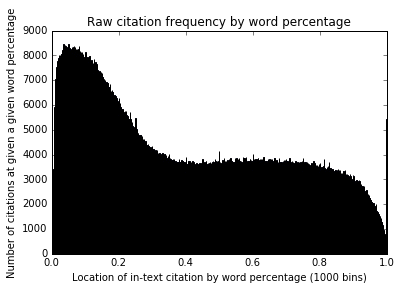

In [245]:
sect_actual_names ={}
sect_xml_names = {}
keys = list(ref_dict.keys())
location_pcts = np.array([])
i = 0
for doi in keys:
    i+=1
    if i%10000 ==0:
        print i
    #print(doi)
    any_cite_location = np.array([])
    any_cite_paper_length = np.array([])
    for it_cite in ref_dict[doi]['refs']:
        for ordinal in ref_dict[doi]['refs'][it_cite]['occs']:
            fields = ref_dict[doi]['refs'][it_cite]['occs'][ordinal]
            section_names = fields[0]
            paper_location = fields[1]
            section_location = fields[2]
            paragraph_location = fields[3]
            
            
            #whole paper location:
            any_cite_location = np.append(any_cite_location, paper_location[3])
            any_cite_paper_length = np.append(any_cite_paper_length, paper_location[4])
            #print(any_cite_location)
            
            #print(fields)
            '''if section_names[0] not in sect_actual_names:
                sect_actual_names[section_names[0]] = 1
            else:
                sect_actual_names[section_names[0]] +=1
                
            if section_names[1] not in sect_xml_names:
                sect_xml_names[section_names[1]] = 1
            else:
                sect_xml_names[section_names[1]] += 1'''
    
    location_pcts = np.append(location_pcts, any_cite_location/any_cite_paper_length)
plt.title('Raw citation frequency by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by word percentage (1000 bins)')
plt.hist(location_pcts, bins = 1000)
plt.show()
#print(sect_xml_names)

#print(sect_actual_names)

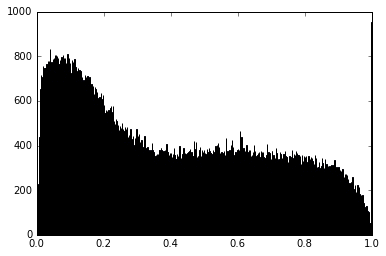

In [242]:
sect_actual_names ={}
sect_xml_names = {}
keys = list(ref_dict.keys())
location_pcts = np.array([])

for doi in keys[0:10000]:
    #print(doi)
    any_cite_location = np.array([])
    any_cite_paper_length = np.array([])
    for it_cite in ref_dict[doi]['refs']:
        for ordinal in ref_dict[doi]['refs'][it_cite]['occs']:
            fields = ref_dict[doi]['refs'][it_cite]['occs'][ordinal]
            section_names = fields[0]
            paper_location = fields[1]
            section_location = fields[2]
            paragraph_location = fields[3]
            
            
            #whole paper location:
            any_cite_location = np.append(any_cite_location, paper_location[1])
            any_cite_paper_length = np.append(any_cite_paper_length, paper_location[2])
            #print(any_cite_location)
            
            #print(fields)
            '''if section_names[0] not in sect_actual_names:
                sect_actual_names[section_names[0]] = 1
            else:
                sect_actual_names[section_names[0]] +=1
                
            if section_names[1] not in sect_xml_names:
                sect_xml_names[section_names[1]] = 1
            else:
                sect_xml_names[section_names[1]] += 1'''
    
    location_pcts = np.append(location_pcts, any_cite_location/any_cite_paper_length)
    
plt.title('Raw citation frequency by character percentage')
plt.ylabel('Number of citations at given a given char percentage')
plt.xlabel('Location of in-text citation by char percentage (1000 bins)')

plt.hist(location_pcts, bins = 1000)
plt.show()
#print(sect_xml_names)

#print(sect_actual_names)

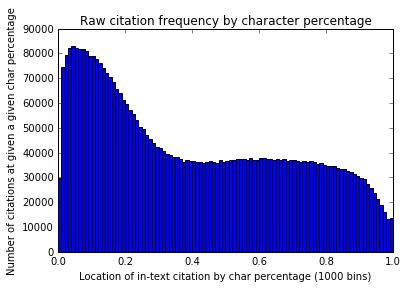

In [273]:
plt.title('Raw citation frequency by character percentage')
plt.ylabel('Number of citations at given a given char percentage')
plt.xlabel('Location of in-text citation by char percentage (1000 bins)')

plt.hist(location_pcts, bins = 100)
plt.show()

In [220]:
sect_actual_names

{None: 405,
 '\tDiscussion': 26,
 '\tIntroduction': 58,
 u'(Re-)interpreting Old Cues\u2014The ': 7,
 '1 Introduction': 284,
 '1 Mathematical Formulation': 1,
 '1. Introduction': 472,
 '1F1S Restricted Degree Sequence Problem is a Self-Reduced Counting Problem': 3,
 '2 Level-Set Formalism': 4,
 '2 Materials and Methods': 9,
 '2 Method of Solution': 2,
 '2 Preliminaries': 4,
 '2 Related Literature': 28,
 '2. Materials and Methods': 15,
 '2.2. Experimental procedure': 3,
 '2D and 3D Hybrid MKD-SRC': 1,
 '3 Comparisons and Tests': 3,
 '3 Discussion': 6,
 '3 Learning Algorithms: An Overview': 2,
 '3 Methodology': 3,
 '3 Methods': 2,
 '3 Results and Discussion': 14,
 '3 The model': 1,
 '3. Fuzzy Kappa': 4,
 '3. Results': 12,
 '3. Results and Discussions': 2,
 '4 Algorithm on Quad/Oc-tree Data Structures': 2,
 '4 Comparison and Discussion': 2,
 '4 Discussion': 41,
 '4 Local stability analysis': 3,
 '4 Results and Discussion': 8,
 '4. Applicational Examples': 2,
 '4. Discussion': 335,
 '5 Con

In [17]:
ref_dict = pickle.load(open('../ref_dict1.txt', 'rb'))

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


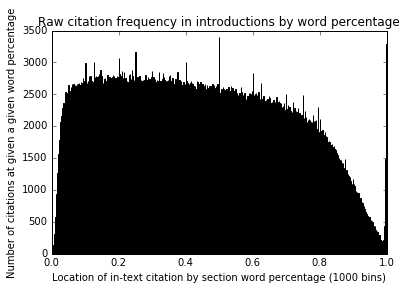

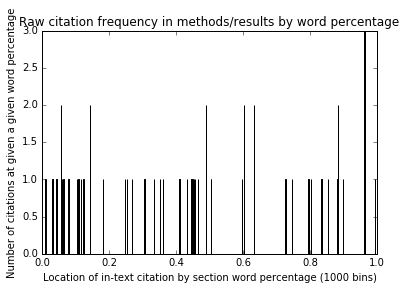

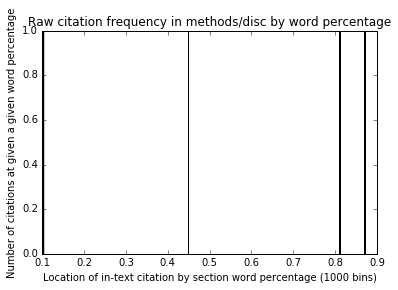

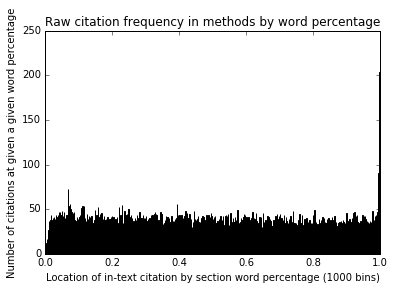

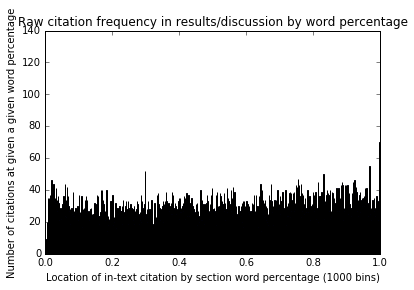

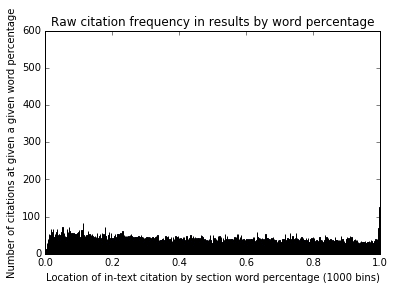

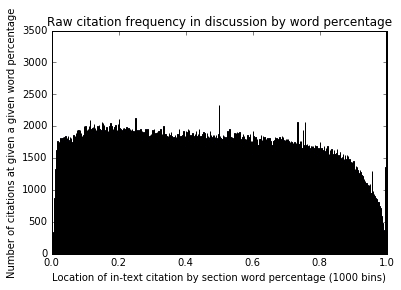

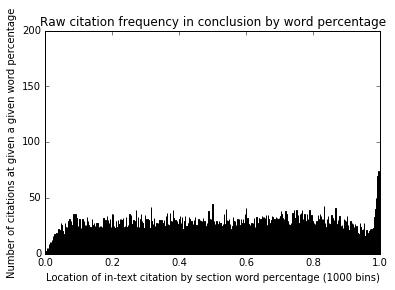

In [22]:
import regex as re

intro_re = re.compile(r'(intro)')
method_re = re.compile(r'(method)')
results_re = re.compile(r'(results)')
disc_re = re.compile(r'(disc)')
concl_re = re.compile(r'(conclu)')
backgr_re = re.compile(r'(backgr)')
mater_re = re.compile(r'(mater)')

keys = list(ref_dict.keys())
intro_location_pcts = np.array([])
methods_results_location_pcts = np.array([])
methods_disc_location_pcts = np.array([])
methods_location_pcts = np.array([])
results_disc_location_pcts = np.array([])
results_location_pcts = np.array([])
disc_location_pcts = np.array([])
concl_location_pcts = np.array([])

i = 0
for doi in keys[0:100000]:
    i+=1
    if i%10000 ==0:
        print i
    #print(doi)
    
    any_cite_location = np.array([])
    any_cite_paper_length = np.array([])
    
    
    intro_location = np.array([])
    intro_paper_length = np.array([])
    
    methods_results_location = np.array([])
    methods_results_paper_length = np.array([])
    
    methods_disc_location = np.array([])
    methods_disc_paper_length = np.array([])

    methods_location = np.array([])
    methods_paper_length = np.array([])

    results_disc_location = np.array([])
    results_disc_paper_length = np.array([])

    results_location = np.array([])
    results_paper_length = np.array([])

    disc_location = np.array([])
    disc_paper_length = np.array([])

    concl_location = np.array([])
    concl_paper_length = np.array([])    
    
    for it_cite in ref_dict[doi]['refs']:
        for ordinal in ref_dict[doi]['refs'][it_cite]['occs']:
            fields = ref_dict[doi]['refs'][it_cite]['occs'][ordinal]
            section_names = fields[0]
            paper_location = fields[1]
            section_location = fields[2]
            paragraph_location = fields[3]
            
            
            if section_names[0] != None:
                if re.search(intro_re, section_names[0].lower()) or re.search(backgr_re, section_names[0].lower()):
                
                
                    #print section_location
                    #print paper_location

                #whole paper location:
                    intro_location = np.append(intro_location, section_location[3])
                    intro_paper_length = np.append(intro_paper_length, section_location[4])
            
                elif re.search(method_re, section_names[0].lower()) or re.search(mater_re, section_names[0].lower()):
                    if re.search(results_re, section_names[0].lower()):
                        methods_results_location = np.append(methods_results_location, section_location[3])
                        methods_results_paper_length = np.append(methods_results_paper_length, section_location[4])
                        
                    elif re.search(disc_re, section_names[0].lower()):
                        methods_disc_location = np.append(methods_disc_location, section_location[3])
                        methods_disc_paper_length = np.append(methods_disc_paper_length, section_location[4])
                        
                    else:
                        methods_location = np.append(methods_location, section_location[3])
                        methods_paper_length = np.append(methods_paper_length, section_location[4])
                        
                elif re.search(results_re, section_names[0].lower()):
                    
                    if re.search(disc_re, section_names[0].lower()):
                        results_disc_location = np.append(results_disc_location, section_location[3])
                        results_disc_paper_length = np.append(results_disc_paper_length, section_location[4])
                        
                    else:
                        results_location = np.append(results_location, section_location[3])
                        results_paper_length = np.append(results_paper_length, section_location[4])
                        
                elif re.search(disc_re, section_names[0].lower()):
                    disc_location = np.append(disc_location, section_location[3])
                    disc_paper_length = np.append(disc_paper_length, section_location[4])
                    
                elif re.search(concl_re, section_names[0].lower()):
                    concl_location = np.append(concl_location, section_location[3])
                    concl_paper_length = np.append(concl_paper_length, section_location[4])
                else:
                    pass
            else:
                pass
           

    intro_location_pcts = np.append(intro_location_pcts, intro_location/intro_paper_length)

    methods_results_location_pcts = np.append(methods_results_location_pcts, methods_results_location/methods_results_paper_length)

    methods_disc_location_pcts = np.append(methods_disc_location_pcts, methods_disc_location/methods_disc_paper_length)

    methods_location_pcts = np.append(methods_location_pcts, methods_location/methods_paper_length)

    results_disc_location_pcts = np.append(results_disc_location_pcts, results_disc_location/results_disc_paper_length)

    results_location_pcts = np.append(results_location_pcts, results_location/results_paper_length)

    disc_location_pcts = np.append(disc_location_pcts, disc_location/disc_paper_length)

    concl_location_pcts = np.append(concl_location_pcts, concl_location/concl_paper_length)
 
    
    
    
plt.title('Raw citation frequency in introductions by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(intro_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in methods/results by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(methods_results_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in methods/disc by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(methods_disc_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in methods by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(methods_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in results/discussion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(results_disc_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in results by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(results_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in discussion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(disc_location_pcts, bins = 1000)
plt.show()
plt.title('Raw citation frequency in conclusion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (1000 bins)')
plt.hist(concl_location_pcts, bins = 1000)
plt.show()
#print(sect_xml_names)



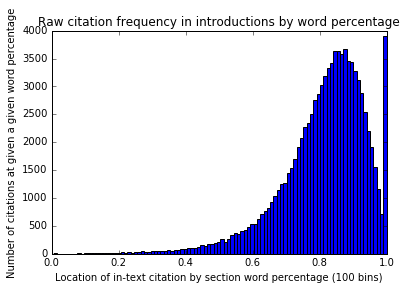

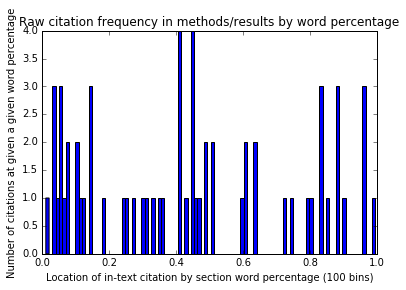

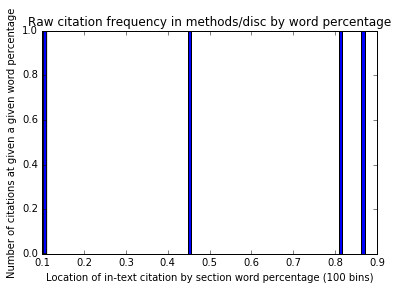

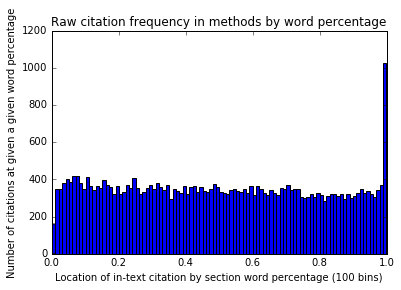

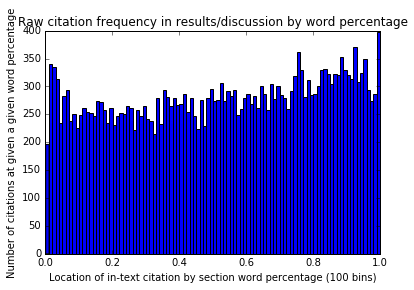

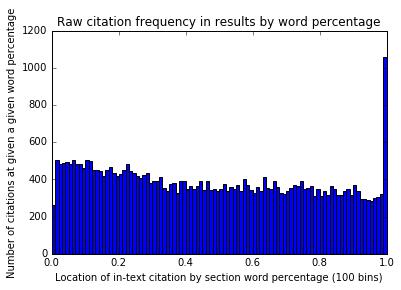

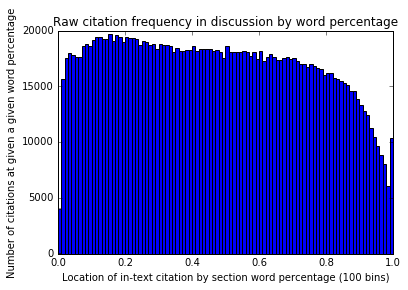

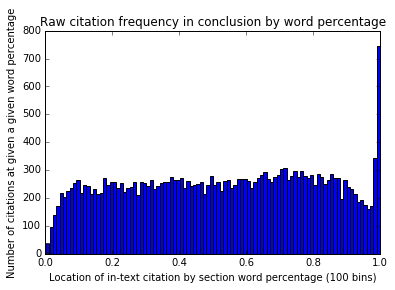

In [275]:

plt.title('Raw citation frequency in introductions by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (100 bins)')
plt.hist(intro_location_pcts, bins = 100)
plt.show()
plt.title('Raw citation frequency in methods/results by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (100 bins)')
plt.hist(methods_results_location_pcts, bins = 100)
plt.show()
plt.title('Raw citation frequency in methods/disc by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (100 bins)')
plt.hist(methods_disc_location_pcts, bins = 100)
plt.show()
plt.title('Raw citation frequency in methods by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (100 bins)')
plt.hist(methods_location_pcts, bins = 100)
plt.show()
plt.title('Raw citation frequency in results/discussion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (100 bins)')
plt.hist(results_disc_location_pcts, bins = 100)
plt.show()
plt.title('Raw citation frequency in results by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (100 bins)')
plt.hist(results_location_pcts, bins = 100)
plt.show()
plt.title('Raw citation frequency in discussion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (100 bins)')
plt.hist(disc_location_pcts, bins = 100)
plt.show()
plt.title('Raw citation frequency in conclusion by word percentage')
plt.ylabel('Number of citations at given a given word percentage')
plt.xlabel('Location of in-text citation by section word percentage (100 bins)')
plt.hist(concl_location_pcts, bins = 100)
plt.show()

In [256]:
len(intro_location_pcts)

93449

In [149]:
next_ref = '1]'
numeric = re.compile(r'([\[\]\s\d]+)')
dig_re = re.compile('[0-9]')#|(\])')
if re.search(dig_re, next_ref):
    print(True)

True


In [112]:
#xml_dict['pone_0105721']
xml_dict['pone_0105721']['Introduction']['text'][0][3]

'[1]'

NameError: name 'plos_dict' is not defined

In [279]:
ref_dict['pone_0105722']

{'refs': {1: {'occs': {1: [('Introduction', None),
     (0, 180, 15579, 27, 2628),
     (0, 180, 1852, 27, 309),
     (0, 180, 180, 27, 27)]}},
  2: {'occs': {1: [('Introduction', None),
     (0, 648, 15579, 102, 2628),
     (0, 648, 1852, 102, 309),
     (1, 468, 471, 75, 76)],
    2: [('Introduction', None),
     (0, 1255, 15579, 213, 2628),
     (0, 1255, 1852, 213, 309),
     (2, 604, 605, 110, 111)],
    3: [('Methods', 'methods'),
     (0, 2491, 15579, 413, 2628),
     (1, 639, 4683, 104, 772),
     (5, 639, 639, 104, 104)]}},
  3: {'occs': {1: [('Introduction', None),
     (0, 651, 15579, 103, 2628),
     (0, 651, 1852, 103, 309),
     (1, 471, 471, 76, 76)]}},
  4: {'occs': {1: [('Introduction', None),
     (0, 727, 15579, 118, 2628),
     (0, 727, 1852, 118, 309),
     (2, 76, 605, 15, 111)]}},
  5: {'occs': {1: [('Introduction', None),
     (0, 888, 15579, 149, 2628),
     (0, 888, 1852, 149, 309),
     (2, 237, 605, 46, 111)]}},
  6: {'occs': {1: [('Introduction', None),
   

In [13]:
from scipy import stats
stats.gaussian_kde

In [671]:
xml_dict['pone_0157715']

OrderedDict([('Introduction',
              {'attr': [['bibr', 'bibr', 'bibr', 'bibr', 'bibr'],
                ['bibr', 'bibr'],
                ['bibr', 'bibr'],
                ['bibr']],
               'ref_flags': [[0,
                 1,
                 0,
                 0,
                 0,
                 0,
                 0,
                 1,
                 0,
                 0,
                 0,
                 0,
                 0,
                 1,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 1,
                 0,
                 0,
                 0,
                 0,
                 0,
                 1,
                 0],
                [0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
                 0,
               

In [687]:
ref_dict['pone_0157720']['refs']

{1: {'occs': {1: ['Introduction',
    (0, 167, 12162),
    (0, 167, 4295),
    (0, 167, 987)]}},
 2: {'occs': {1: ['Introduction',
    (0, 282, 12162),
    (0, 282, 4295),
    (0, 282, 987)]}},
 3: {'occs': {1: ['Introduction',
    (0, 284, 12162),
    (0, 284, 4295),
    (0, 284, 987)]}},
 4: {'occs': {1: ['Introduction',
    (0, 341, 12162),
    (0, 341, 4295),
    (0, 341, 987)]}},
 5: {'occs': {1: ['Introduction',
    (0, 368, 12162),
    (0, 368, 4295),
    (0, 368, 987)]}},
 6: {'occs': {1: ['Introduction',
    (0, 393, 12162),
    (0, 393, 4295),
    (0, 393, 987)]}},
 7: {'occs': {1: ['Introduction',
    (0, 425, 12162),
    (0, 425, 4295),
    (0, 425, 987)]}},
 8: {'occs': {1: ['Introduction',
    (0, 427, 12162),
    (0, 427, 4295),
    (0, 427, 987)]}},
 9: {'occs': {1: ['Introduction',
    (0, 549, 12162),
    (0, 549, 4295),
    (0, 549, 987)]}},
 10: {'occs': {1: ['Introduction',
    (0, 551, 12162),
    (0, 551, 4295),
    (0, 551, 987)]}},
 11: {'occs': {1: ['Introduct

In [544]:
journ_dict ={'10.1371/journal.pone': 'plosone', '10.1371/journal.pgen': 'plosgenetics'} #Fill in later
journ_abbrev='10.1371/journal.pone'
doi = '10.1371/journal.pone.0000001'
address = 'http://journals.plos.org/%s/article/asset?id=%s.XML'%(journ_dict[journ_abbrev], doi)
address
#doi[16:20]+'_'+doi[21:]

'http://journals.plos.org/plosone/article/asset?id=10.1371/journal.pone.0000001.XML'

In [520]:
cite_order = []
text_list = []
sect_dict = {}
for i in root.findall('body'): # Body of text - intro, methods, discussion
    
    for j in list(i): # Section id
        
            #section = j.
        for k in list(j):
            if k.tag == 'title':
                current_sect = k.text
                sect_dict[current_sect] = {}
                sect_dict[current_sect]['text'] = []
                sect_dict[current_sect]['refs'] = []
            elif k.tag == 'p':

                text = k.xpath(".//text()")
                tags = k.xpath('xref')

                tag_text = [x.text for x in tags]
                
                #print text
                sect_dict[current_sect]['text'].append(list(text))
                
                sect_dict[current_sect]['refs'].append(tag_text)
            else:
                print k.tag
                

sec
sec
sec
sec
sec
sec
sec
sec
sec
sec
sec
sec
sec
sec
sec
sec
sec
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material
supplementary-material


In [521]:

for sect in sect_dict.keys(): # Intro, methods, results, discussion
    sect_dict[sect]['ref_flags']= [-1]*len(sect_dict[sect]['text'])
    for para_ind in range(len(sect_dict[sect]['text'])): # Go through each paragraph
        
        current_ind = 0
        ref_flags = [-1]*len(sect_dict[sect]['text'][para_ind])
        #sect_dict[sect]['ref_flags']= []
        for frag_ind in range(len(sect_dict[sect]['text'][para_ind])):
            fragment = sect_dict[sect]['text'][para_ind][frag_ind]
            #print fragment
            #print sect_dict[sect]['refs'][para_ind][current_ind]
            #print fragment
            #print current_ind
            #print sect, para_ind, ref_flags
            if len(sect_dict[sect]['refs'][para_ind])> 0:
                if fragment == sect_dict[sect]['refs'][para_ind][current_ind]:
                    #print True
                    ref_flags[frag_ind] = 1
                    #print current_ind
                    if current_ind != len(sect_dict[sect]['refs'][para_ind])-1:
                        current_ind += 1
                    else:
                        pass
                else:
                    ref_flags[frag_ind] = 0
            else:
                ref_flags[frag_ind] = 0
        sect_dict[sect]['ref_flags'][para_ind] = ref_flags
            
        

In [522]:
sect_dict['Introduction']

{'ref_flags': [[0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
  [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
  [0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   0],
  [0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0],
  [0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0]],
 'refs': [['[1]', '[2]', '[3]', '[4]', '[5]', '[6]'],
  ['[7]', '[9]', '[7]', '[10]', '[11]'],
  ['[12]',
   '[13]',
   '[10]',
   '[14]',
   '[13]',
   '[15]',
   '[16]',
   '[17]',
   '[18]',
   '[19]'],
  ['[2]',
   

In [523]:
import regex as re

def in_text_cite_finder_xml(text):
    #matches = re.compile(r'(\[[\d\,\s\-\[\]]+\])', re.UNICODE)
    chars_to_remove = ['-', '᠆', '‐', '‑', '‒', '–', '—', '―', '﹘', '﹣', '－', '–']
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
    text = re.sub(rx, '-', text)

    results = []
    positions = []
    for m in matches.finditer(text):
        string = m[0].replace('[','')
        string = string.replace(']','')
        #print(string + '\n')
        #print(str(m.start()) + '!!!!!!')
        pos = m.start()
        
ref_modifiers = re.compile(r'(^[\s\,\-\-\᠆\‐\‑\‒\–\—\―\﹘\﹣\－\–]+$)', re.UNICODE)
hyphens = re.compile(r'(^[\s\-\-\᠆\‐\‑\‒\–\—\―\﹘\﹣\－\–]+$)', re.UNICODE)
numeric = re.compile(r'([\[\]\s\d]+)')

# Will need to store each section's total length for later (IMRaD character position)

ref_vals = [] #reference number 1,2,3,4...
sect_names = []
sect_lengths = []
para_lengths = []
sect_pos = [] #character position in section
para_pos = [] #character position in paragraph

ref_dict = {}
list_of_journs = ['plosone','plos']
for journal in list_of_journs:
    url = 'http://journals.plos.org/%s/article/asset?id=%s.XML'%()
        
for sect in sect_dict:
    sect_char_count = 0
    
    for para_ind in sect_dict[sect]['text']:
        para_char_count = 0
        
        for frag_ind in sect_dict[sect]['text'][para_ind]:
            if wait_iter == 0: # this to make sure there's no doubling up when there's a hyphenated reference
                text = sect_dict[sect]['text'][para_ind][frag_ind].encode('utf-8')
                ref_flag = sect_dict[sect]['ref_flags'][para_ind][frag_ind]

                if ref_flag == 0: # If it's just text, add the text to the running character counts
                    sect_char_count += len(text)
                    para_char_count += len(text)

                elif ref_flag ==1: # If the text is flagged as a reference
                    current_ref = sect_dict[sect]['text'][para_ind][frag_ind]

                    if re.match(numeric, current_ref): #Check if current reference is numeric (allows brackets). Make sure isnt a table/figure
                        try:
                            next_text = sect_dict[sect]['text'][para_ind][frag_ind+1]
                        except KeyError:
                            next_text = None

                        if re.match(hyphens, next_text): #Check if the next text is a hyphen
                            try:
                                next_ref = sect_dict[sect]['ref_flags'][para_ind][frag_ind+2]
                            except KeyError:
                                next_ref = None

                            if re.match(numeric, next_ref): #Check if the next -xref- is just a number. (i.e. doesn't include alphanumericals for a figure or table)
                                digits = [int(s) for s in re.findall('\d+', current_ref+' '+next_ref)]
                                dif = digits[1]-digits[0]

                                for j in range(dif+1):
                                    ref_vals.append(digits[0]+j)
                                    sect_pos.append(sect_char_count)
                                    para_pos.append(para_char_count)

                                    #save the reference and the position
                                    pass

                                wait_iter = 2 #Marks that we've checked the two fragments after the current one

                            else:
                                digits = [int(s) for s in re.findall('\d+', current_ref)] # change this later to something better
                                ref_vals.append(digits[0])
                                sect_pos.append(sect_char_count)
                                para_pos.append(para_char_count)
                                # save current_ref and position

                        else:
                            digits = [int(s) for s in re.findall('\d+', current_ref)] # change this later
                            # Then the current_ref needs to be added solely. Note commas don't change this
                            ref_vals.append(digits[0])
                            sect_pos.append(sect_char_count)
                            para_pos.append(para_char_count)
                            # Save the current_ref and position
                            pass

                    else: # If the xref flag is not numeric (e.g. italicized word)
                        #Just add length to running char count
                        sect_char_count += len(text)
                        para_char_count += len(text)
                else:
                    wait_iter = wait_iter - 1
                    pass
        para_lengths.append(para_char_count)
    sect_dict[sect]['sect_length']=sect_char_count
    #sect_lengths.append(sect_char_count)

SyntaxError: invalid syntax (<ipython-input-523-e31e32d6e539>, line 35)

In [529]:
for k in range(5-2+1):
    print(2+k)

2
3
4
5


In [12]:
import regex as re
ref_modifiers = re.compile(r'(^[\s\,\-\-\᠆\‐\‑\‒\–\—\―\﹘\﹣\－\–]+$)', re.UNICODE)
test = ' -, '
if re.match(ref_modifiers, test):
    print(True)

True


In [501]:
sect_dict['Introduction']['text'][0]

['Since the 1970s, biologists have directed substantial research effort to understanding adaptive sex-biased allocation of maternal resources in animals and plants. Biologists have proposed numerous hypotheses for sex-biases, including local resource competition ',
 '[1]',
 u'\u2013',
 '[2]',
 u', \u201cadvantaged daughters\u201d ',
 '[3]',
 ', local resource enhancement ',
 '[4]',
 u'\u2013',
 '[5]',
 u', the \u201csafe bet\u201d/reproductive value ',
 '[6]',
 u'\u2013',
 '[7]',
 ' and sex-differentiated sources of mortality ',
 '[8]',
 '. The most well-known and investigated, though, remains the Trivers-Willard hypothesis ',
 '[9]',
 '. Trivers and Willard hypothesized that a female, as a function of her condition, is expected to preferentially allocate resources to the sex that provides greater marginal return on that investment ',
 '[9]',
 '. In polygynous mating systems characterized by male-male competition, they predicted that good condition females would bias resource allocatio

In [454]:
g = [-1]*len(sect_dict['Methods']['text'][1])
g

[-1]

In [316]:
for paragraph in text_list:
    for line in paragraph:
        print line

Since the 1970s, biologists have directed substantial research effort to understanding adaptive sex-biased allocation of maternal resources in animals and plants. Biologists have proposed numerous hypotheses for sex-biases, including local resource competition 
[1]
–
[2]
, “advantaged daughters” 
[3]
, local resource enhancement 
[4]
–
[5]
, the “safe bet”/reproductive value 
[6]
–
[7]
 and sex-differentiated sources of mortality 
[8]
. The most well-known and investigated, though, remains the Trivers-Willard hypothesis 
[9]
. Trivers and Willard hypothesized that a female, as a function of her condition, is expected to preferentially allocate resources to the sex that provides greater marginal return on that investment 
[9]
. In polygynous mating systems characterized by male-male competition, they predicted that good condition females would bias resource allocation in favor of sons because males profit more form additional investment than do females 
[9]
. Collectively, the hypothese

In [123]:
a = '10.1371/journal.pone.0157772'
address = 'http://journals.plos.org/plosone/article/asset?id=10.1371/journal.pone.0086169.XML'
b = urlopen(address)
c = b.read()
    #b = xmltodict.parse(fd.read())
#result=byIds(a,fields=list_fields_str)
doc = ET.parse(c)

IOError: [Errno 63] File name too long: '<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE article\n  PUBLIC "-//NLM//DTD Journal Publishing DTD v3.0 20080202//EN" "http://dtd.nlm.nih.gov/publishing/3.0/journalpublishing3.dtd">\n<article xmlns:mml="http://www.w3.org/1998/Math/MathML" xmlns:xlink="http://www.w3.org/1999/xlink" article-type="research-article" dtd-version="3.0" xml:lang="en">\n<front>\n<journal-meta>\n<journal-id journal-id-type="nlm-ta">PLoS ONE</journal-id>\n<journal-id journal-id-type="publisher-id">plos</journal-id>\n<journal-id journal-id-type="pmc">plosone</journal-id><journal-title-group>\n<journal-title>PLoS ONE</journal-title></journal-title-group>\n<issn pub-type="epub">1932-6203</issn>\n<publisher>\n<publisher-name>Public Library of Science</publisher-name>\n<publisher-loc>San Francisco, USA</publisher-loc></publisher>\n</journal-meta>\n<article-meta>\n<article-id pub-id-type="publisher-id">PONE-D-13-32985</article-id>\n<article-id pub-id-type="doi">10.1371/journal.pone.0086169</article-id>\n<article-categories><subj-group subj-group-type="heading"><subject>Research Article</subject></subj-group><subj-group subj-group-type="Discipline-v2"><subject>Biology</subject><subj-group><subject>Ecology</subject><subj-group><subject>Behavioral ecology</subject></subj-group></subj-group><subj-group><subject>Evolutionary biology</subject><subj-group><subject>Evolutionary developmental biology</subject><subject>Evolutionary theory</subject></subj-group></subj-group><subj-group><subject>Zoology</subject><subj-group><subject>Animal physiology</subject><subject>Mammalogy</subject></subj-group></subj-group></subj-group><subj-group subj-group-type="Discipline-v2"><subject>Social and behavioral sciences</subject><subj-group><subject>Anthropology</subject><subj-group><subject>Biological anthropology</subject></subj-group></subj-group></subj-group><subj-group subj-group-type="Discipline-v2"><subject>Veterinary science</subject><subj-group><subject>Animal management</subject><subj-group><subject>Animal nutrition</subject><subject>Animal performance</subject></subj-group></subj-group></subj-group></article-categories>\n<title-group>\n<article-title>Holsteins Favor Heifers, Not Bulls: Biased Milk Production Programmed during Pregnancy as a Function of Fetal Sex</article-title>\n<alt-title alt-title-type="running-head">Fetal Sex Programs Milk Synthesis in Dairy Cows</alt-title>\n</title-group>\n<contrib-group>\n<contrib contrib-type="author" xlink:type="simple"><name name-style="western"><surname>Hinde</surname><given-names>Katie</given-names></name><xref ref-type="aff" rid="aff1"><sup>1</sup></xref><xref ref-type="aff" rid="aff4"><sup>4</sup></xref><xref ref-type="aff" rid="aff5"><sup>5</sup></xref><xref ref-type="corresp" rid="cor1"><sup>*</sup></xref></contrib>\n<contrib contrib-type="author" xlink:type="simple"><name name-style="western"><surname>Carpenter</surname><given-names>Abigail J.</given-names></name><xref ref-type="aff" rid="aff2"><sup>2</sup></xref></contrib>\n<contrib contrib-type="author" xlink:type="simple"><name name-style="western"><surname>Clay</surname><given-names>John S.</given-names></name><xref ref-type="aff" rid="aff3"><sup>3</sup></xref></contrib>\n<contrib contrib-type="author" xlink:type="simple"><name name-style="western"><surname>Bradford</surname><given-names>Barry J.</given-names></name><xref ref-type="aff" rid="aff2"><sup>2</sup></xref></contrib>\n</contrib-group>\n<aff id="aff1"><label>1</label><addr-line>Department of Human Evolutionary Biology, Harvard University, Cambridge, Massachusetts, United States of America</addr-line></aff>\n<aff id="aff2"><label>2</label><addr-line>Department of Animal Sciences and Industry, Kansas State University, Manhattan, Kansas, United States of America</addr-line></aff>\n<aff id="aff3"><label>3</label><addr-line>Dairy Records Management Systems, Raleigh, North Carolina, United States of America</addr-line></aff>\n<aff id="aff4"><label>4</label><addr-line>Nutrition Laboratory, Smithsonian Conservation Biology Institute, National Zoological Park, Washington, District of Columbia, United States of America</addr-line></aff>\n<aff id="aff5"><label>5</label><addr-line>Brain, Mind, and Behavior Unit, California National Primate Research Center, University of California Davis, Davis, California, United States of America</addr-line></aff>\n<contrib-group>\n<contrib contrib-type="editor" xlink:type="simple"><name name-style="western"><surname>Cameron</surname><given-names>Elissa Z.</given-names></name>\n<role>Editor</role>\n<xref ref-type="aff" rid="edit1"/></contrib>\n</contrib-group>\n<aff id="edit1"><addr-line>University of Tasmania, Australia</addr-line></aff>\n<author-notes>\n<corresp id="cor1">* E-mail: <email xlink:type="simple">khinde@fas.harvard.edu</email></corresp>\n<fn fn-type="conflict"><p>The authors have declared that no competing interests exist.</p></fn>\n<fn fn-type="con"><p>Conceived and designed the experiments: KH BJB AC. Analyzed the data: BJB AC KH. Contributed reagents/materials/analysis tools: JC. Wrote the paper: KH BJB AC. Provided comments on manuscript: JC.</p></fn>\n</author-notes>\n<pub-date pub-type="collection"><year>2014</year></pub-date>\n<pub-date pub-type="epub"><day>3</day><month>2</month><year>2014</year></pub-date>\n<volume>9</volume>\n<issue>2</issue>\n<elocation-id>e86169</elocation-id>\n<history>\n<date date-type="received"><day>12</day><month>8</month><year>2013</year></date>\n<date date-type="accepted"><day>6</day><month>12</month><year>2013</year></date>\n</history>\n<permissions>\n<copyright-year>2014</copyright-year>\n<copyright-holder>Hinde et al</copyright-holder><license xlink:type="simple"><license-p>This is an open-access article distributed under the terms of the <ext-link ext-link-type="uri" xlink:href="http://creativecommons.org/licenses/by/4.0/" xlink:type="simple">Creative Commons Attribution License</ext-link>, which permits unrestricted use, distribution, and reproduction in any medium, provided the original author and source are credited.</license-p></license></permissions>\n<abstract>\n<p>Mammalian females pay high energetic costs for reproduction, the greatest of which is imposed by lactation. The synthesis of milk requires, in part, the mobilization of bodily reserves to nourish developing young. Numerous hypotheses have been advanced to predict how mothers will differentially invest in sons and daughters, however few studies have addressed sex-biased milk synthesis. Here we leverage the dairy cow model to investigate such phenomena. Using 2.39 million lactation records from 1.49 million dairy cows, we demonstrate that the sex of the fetus influences the capacity of the mammary gland to synthesize milk during lactation. Cows favor daughters, producing significantly more milk for daughters than for sons across lactation. Using a sub-sample of this dataset (N\xe2\x80\x8a=\xe2\x80\x8a113,750 subjects) we further demonstrate that the effects of fetal sex interact dynamically across parities, whereby the sex of the fetus being gestated can enhance or diminish the production of milk during an established lactation. Moreover the sex of the fetus gestated on the first parity has persistent consequences for milk synthesis on the subsequent parity. Specifically, gestation of a daughter on the first parity increases milk production by \xe2\x88\xbc445 kg over the first two lactations. Our results identify a dramatic and sustained programming of mammary function by offspring <italic>in utero</italic>. Nutritional and endocrine conditions <italic>in utero</italic> are known to have pronounced and long-term effects on progeny, but the ways in which the progeny has sustained physiological effects on the dam have received little attention to date.</p>\n</abstract>\n<funding-group><funding-statement>Contribution no. 13-391-J from the Kansas Agricultural Experiment Station to BJB and AJC supported, in part, the study. The funders had no role in study design, data collection and analysis, decision to publish, or preparation of the manuscript. No additional external funding was received for this study.</funding-statement></funding-group><counts><page-count count="7"/></counts></article-meta>\n</front>\n<body><sec id="s1">\n<title>Introduction</title>\n<p>Since the 1970s, biologists have directed substantial research effort to understanding adaptive sex-biased allocation of maternal resources in animals and plants. Biologists have proposed numerous hypotheses for sex-biases, including local resource competition <xref ref-type="bibr" rid="pone.0086169-Clark1">[1]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Silk1">[2]</xref>, \xe2\x80\x9cadvantaged daughters\xe2\x80\x9d <xref ref-type="bibr" rid="pone.0086169-Simpson1">[3]</xref>, local resource enhancement <xref ref-type="bibr" rid="pone.0086169-Emlen1">[4]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Silk2">[5]</xref>, the \xe2\x80\x9csafe bet\xe2\x80\x9d/reproductive value <xref ref-type="bibr" rid="pone.0086169-Shibata1">[6]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Leimar1">[7]</xref> and sex-differentiated sources of mortality <xref ref-type="bibr" rid="pone.0086169-Smith1">[8]</xref>. The most well-known and investigated, though, remains the Trivers-Willard hypothesis <xref ref-type="bibr" rid="pone.0086169-Trivers1">[9]</xref>. Trivers and Willard hypothesized that a female, as a function of her condition, is expected to preferentially allocate resources to the sex that provides greater marginal return on that investment <xref ref-type="bibr" rid="pone.0086169-Trivers1">[9]</xref>. In polygynous mating systems characterized by male-male competition, they predicted that good condition females would bias resource allocation in favor of sons because males profit more form additional investment than do females <xref ref-type="bibr" rid="pone.0086169-Trivers1">[9]</xref>. Collectively, the hypotheses proposed in the literature can be loosely grouped according to the extent that the directionality of the sex-bias is contingent on maternal condition; however, the predictions deriving from these hypotheses are not always mutually exclusive, complicating interpretation of empirical results <xref ref-type="bibr" rid="pone.0086169-Cockburn1">[10]</xref>. Large-bodied ungulates are frequently used for investigating sex-biased maternal allocation because male body size contributes substantially to success in competitive access to mating opportunities, but evidence for systematic sex-biases has been equivocal <xref ref-type="bibr" rid="pone.0086169-Cockburn1">[10]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Plabon1">[14]</xref>.</p>\n<p>Although sex-ratio at birth has been the primary outcome investigated, post-natal maternal physiological transfer and behavioral care afford females substantial flexibility in sex-biased resource allocation <xref ref-type="bibr" rid="pone.0086169-Hewison1">[12]</xref>. Sex-biased nursing behavior has been investigated as a possible proxy for sex-biased milk production in numerous mammalian taxa <xref ref-type="bibr" rid="pone.0086169-Cameron2">[15]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-CluttonBrock1">[21]</xref>. Suckling behavior, however, is not useful for estimating milk energy transfer as verified by experimental use of radio-labeled isotopes in <italic>Equus caballus</italic> <xref ref-type="bibr" rid="pone.0086169-Cameron3">[22]</xref>. Direct evidence for sex-biased milk synthesis among non-domesticated species has now been reported in ungulates (<italic>Cervus elaphus hispanicus</italic>, <xref ref-type="bibr" rid="pone.0086169-LandeteCastillejos1">[23]</xref>), rodents (<italic>Myodes glareolus</italic> <xref ref-type="bibr" rid="pone.0086169-Koskela1">[24]</xref>), primates (<italic>Macaca mulatta</italic> <xref ref-type="bibr" rid="pone.0086169-Hinde1">[25]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Hinde2">[26]</xref>; <italic>Homo sapiens</italic> <xref ref-type="bibr" rid="pone.0086169-Fujita1">[27]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Thakkar1">[29]</xref>, but see also <xref ref-type="bibr" rid="pone.0086169-Quinn1">[30]</xref> for exception), and marsupials (<italic>Macropus eugenii,</italic> <xref ref-type="bibr" rid="pone.0086169-Robert1">[31]</xref>). Drawing systematic conclusions from the studies to date, however, is challenging in part because most have been limited by relatively small sample sizes or report milk composition without accounting for milk yield. The most comprehensive data derive from Iberian red deer (<italic>Cervus elaphus hispanicus</italic>) and rhesus macaques (<italic>Macaca mulatta</italic>). Landete-Castillejos and colleagues showed that hinds favored sons by producing more milk with higher protein content for them <xref ref-type="bibr" rid="pone.0086169-LandeteCastillejos1">[23]</xref>. This bias did not vary as a function of maternal mass or age <xref ref-type="bibr" rid="pone.0086169-LandeteCastillejos1">[23]</xref>. Among rhesus macaques, mothers produced higher milk energy density [kcal/g] for sons <xref ref-type="bibr" rid="pone.0086169-Hinde2">[26]</xref> due to higher fat content <xref ref-type="bibr" rid="pone.0086169-Hinde1">[25]</xref>. There was additionally an interaction with maternal life-history; smaller, younger mothers produced even higher fat and protein concentrations for sons and lower concentrations for daughters than did multiparous mothers <xref ref-type="bibr" rid="pone.0086169-Hinde1">[25]</xref>. However, at peak lactation, mothers of daughters, across parities, produced greater milk volume that offset the reduced energetic density of milk for daughters <xref ref-type="bibr" rid="pone.0086169-Hinde2">[26]</xref>. These studies failed to support sex-bias hypotheses that predict mothers in better condition will preferentially allocate resources to a particular sex, suggesting instead that there may be systematic sex-biases that are independent of maternal condition.</p>\n<p>Mother\xe2\x80\x99s milk, however, is particularly difficult to evaluate when investigating adaptive allocation of maternal resources. Milk synthesis is unlikely to be at the maternal optimum because of parent-offspring conflict <xref ref-type="bibr" rid="pone.0086169-Trivers2">[32]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Godfray1">[33]</xref>. Rather milk reflects a complex physiological and behavioral negotiation between the mother and offspring <xref ref-type="bibr" rid="pone.0086169-Hinde3">[34]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Neville1">[35]</xref>. Functional development of the mammary gland initially occurs during pregnancy and is orchestrated by maternal and placental hormones, particularly placental lactogen, estrogen, and progesterone <xref ref-type="bibr" rid="pone.0086169-Akers1">[36]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Sternlicht1">[38]</xref>. Post-natally, local regulation of milk synthesis is maintained by milk removal via offspring suckling <xref ref-type="bibr" rid="pone.0086169-Akers1">[36]</xref>, <xref ref-type="bibr" rid="pone.0086169-Daly1">39</xref> but maternal rejection can prevent or limit milk intake <xref ref-type="bibr" rid="pone.0086169-Sthulov1">[18]</xref>. As a result, sex-biased milk synthesis may reflect differential cellular capacity in the mammary gland, programmed via hormonal signals from the fetal-placental unit, or post-natally through sex-biased nursing behavior <xref ref-type="bibr" rid="pone.0086169-Hinde2">[26]</xref>. There has been only one study that has investigated mechanisms underlying sex-biased milk synthesis. Koskela and colleagues used an elegant cross-fostering design in bank voles (<italic>Myodes glareolus</italic>) to demonstrate that all-female litters received significantly greater milk yield than did all-male litters, regardless of litter size or maternal condition <xref ref-type="bibr" rid="pone.0086169-Koskela1">[24]</xref>. The manipulation was conducted after females gave birth, and the extent to which pre-natal mammary gland development may have been sensitive to litter sex-ratio was not reported. Litter size during gestation has been shown to influence mammary gland development in sheep <xref ref-type="bibr" rid="pone.0086169-Rattray1">[40]</xref> and milk volume in goats <xref ref-type="bibr" rid="pone.0086169-Hayden1">[41]</xref>, but the effect of fetal sex on milk synthesis has not been investigated.</p>\n<p>We investigated the magnitude and direction of sex-biased milk synthesis in the Holstein breed of <italic>Bos taurus.</italic> Although intensive artificial selection has shaped cattle during recent centuries, domesticated cattle are derived from large-bodied, sexually-dimorphic aurochs (<italic>Bos primigenius</italic>) <xref ref-type="bibr" rid="pone.0086169-AjmoneMarsan1">[42]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Grigson1">[43]</xref>. Among beef cattle, several small studies have revealed sex-biased milk production that favors sons <xref ref-type="bibr" rid="pone.0086169-Minick1">[44]</xref>, favors daughters <xref ref-type="bibr" rid="pone.0086169-Rutledge1">[45]</xref>, or no sex-biases <xref ref-type="bibr" rid="pone.0086169-Christian1">[46]</xref>. In contrast, standardized husbandry practices, systematic milking procedures, detailed record-keeping, and large samples sizes make the dairy cow a powerful model for the exploration of maternal milk synthesis from both functional and mechanistic perspectives <xref ref-type="bibr" rid="pone.0086169-Neville1">[35]</xref>, <xref ref-type="bibr" rid="pone.0086169-Loor1">[47]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Rowson1">[48]</xref>. Birth sex-ratio in dairy cows is male-biased <xref ref-type="bibr" rid="pone.0086169-SilvadelRo1">[49]</xref>, suggesting that mechanisms for sex-biases are operating in this taxon. Moreover the basic architecture for lactation is more highly conserved than other components of the genome, even for an animal artificially selected for milk yield <xref ref-type="bibr" rid="pone.0086169-Lemay1">[50]</xref>. Notably, because calves are removed from the dam within hours of parturition, this model system allowed us to investigate pre-natal mechanisms of sex-biased milk synthesis independent of post-natal maternal care and infant suckling behavior. Importantly, dairy cows are concurrently pregnant during lactation, typically 200+ days of the 305-day lactation <xref ref-type="bibr" rid="pone.0086169-GonzlezRecio1">[51]</xref>. We therefore predicted that milk synthesis on the first lactation could be affected not only by the sex of the calf produced, but also by the sex of the fetus gestated during lactation. We also predicted that mammary gland programming in response to fetal sex would persist into the subsequent lactation because the capacity to synthesize milk is, to some extent, cumulative across parities <xref ref-type="bibr" rid="pone.0086169-Lang1">[52]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Miller1">[54]</xref>. These complex predictions are clarified by schematic representation (<xref ref-type="fig" rid="pone-0086169-g001">Figure 1</xref>).</p>\n<fig id="pone-0086169-g001" position="float"><object-id pub-id-type="doi">10.1371/journal.pone.0086169.g001</object-id><label>Figure 1</label><caption>\n<title>Hypothesis: milk production is influenced by fetal sex across lactations.</title>\n<p>Fetal sex in pregnancy 1 may alter milk production across multiple lactations because of the critical steps in mammary development that occur during the first pregnancy. In the cow, pregnancy 2 typically overlaps with lactation 1, providing opportunity for calf sex in parity 2 to impact milk production in the first lactation.</p>\n</caption><graphic mimetype="image" xlink:href="info:doi/10.1371/journal.pone.0086169.g001" position="float" xlink:type="simple"/></fig></sec><sec id="s2" sec-type="methods">\n<title>Methods</title>\n<p>To investigate sex-biased milk synthesis, we acquired all lactation records from 1995 to 1999 in the database managed by Dairy Records Management Systems (<ext-link ext-link-type="uri" xlink:href="http://www.drms.org" xlink:type="simple">http://www.drms.org</ext-link>). Whole-lactation milk yield and composition data were derived from monthly yield and composition data collected on commercial dairy farms across the United States. Standardized lactation curves, characterized over 5 decades of research, were then used to predict production between the monthly data points. Production is adjusted for breed, region, season and parity during the calculation of whole-lactation milk and component production, which was standardized to a 305-day lactation. These records are used daily by most of the 50,000 dairy farmers in the U.S. to make management decisions. Detailed discussions of the program and data analysis have been published elsewhere <xref ref-type="bibr" rid="pone.0086169-Wiggans1">[55]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-VanRaden1">[56]</xref>. Data from the late 1990\xe2\x80\x99s were used to avoid the influence of sex-selected semen in artificial breeding programs in the commercial dairy industry, which became common in the mid-2000\xe2\x80\x99s <xref ref-type="bibr" rid="pone.0086169-Norman1">[57]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Garner1">[58]</xref>. Additionally, this period of time allowed for analysis of the effects of recombinant bovine somatotropin (bST) <xref ref-type="bibr" rid="pone.0086169-Chilliard1">[59]</xref>, approved in 1993 for commercial use in the U.S. The DRMS database includes a field for reporting administration of bST that was introduced into their software (PCDart) from the start of the commercial availability of bST.</p>\n<p>Several steps were taken to clean the data prior to analysis. Only records from Holstein cattle were retained, and lactations that began with either twin births or abortions were excluded. Lactations with missing or corrupt lactation number, year, or calf sex designations were deleted. Duplicate records for a single lactation within cow were eliminated, and records for lactation \xe2\x89\xa56 (representing 3.02% of lactations in the database) were excluded to enable repeated measures analysis of lactations with adequate representation in the database. If at least 1 of the first 5 test days, typically conducted monthly, were flagged for bST administration, then the lactation was considered bST-positive (N\xe2\x80\x8a=\xe2\x80\x8a100,478; 3.9% of lactations). The final database consisted of 2.39 million lactation records, representing 1.49 million individual Holstein cows, however due to missing data in certain fields, some analyses included fewer lactations and final analysis sample sizes are reported for each analysis. Mixed models were used to evaluate the fixed effects of calf sex, parity, bST, and interactions and the random effect of year according to the following model:</p>\n<disp-formula id="pone.0086169.e001"><graphic position="anchor" xlink:href="info:doi/10.1371/journal.pone.0086169.e001" xlink:type="simple"/></disp-formula>\n<p>where Y<sub>ijkl</sub> is a dependent variable, \xc2\xb5 is the overall mean, S<sub>i</sub> is the fixed effect of calf sex (i\xe2\x80\x8a=\xe2\x80\x8a1 to 2), P<sub>j</sub> is the fixed effect of parity (j\xe2\x80\x8a=\xe2\x80\x8a1 to 5), B<sub>k</sub> is the fixed effect of bST (k\xe2\x80\x8a=\xe2\x80\x8a1 to 2), Y<sub>l</sub> is the random effect of year (l\xe2\x80\x8a=\xe2\x80\x8a1 to 5), SP<sub>ij</sub> is the interaction of calf sex and parity, SB<sub>ik</sub> is the interaction of calf sex and bST, SPB<sub>ijk</sub> is the interaction of calf sex, parity, and bST, and e<sub>ijkl</sub> is the residual error. Repeated lactations within cow were fit to a heterogeneous autoregressive (ARH <xref ref-type="bibr" rid="pone.0086169-Clark1">[1]</xref>) covariance structure. Analyses were completed using the Mixed Procedure of SAS (version 9.3; SAS Institute, Cary, NC). Significant interactions were investigated using the SLICE option and means were separated using the PDIFF option of SAS, with significance declared at <italic>P</italic> &lt;0.05.</p>\n<p>To exclude potentially confounding effects of dystocia and bST treatment on results and to evaluate carryover effects of calf sex on multiple lactations, a more conservative data set was generated. All bST-positive lactations were deleted, and only those beginning with a calving difficulty score of 1 or 2 (no or minimal difficulty) were retained. Finally, the data were narrowed to only those cows with both lactations 1 and 2 represented, leaving 113,750 cows. Data for 305-day milk yield in lactations 1 and 2 were modeled with the fixed effects of calf sex<sub>1</sub>, calf sex<sub>2</sub>, calf sex<sub>1</sub> \xc3\x97 calf sex<sub>2</sub>, and year. Analyses were completed using the Mixed Procedure of SAS (SAS Institute) and means were separated using the PDIFF option of SAS, with significance declared at <italic>P</italic> &lt;0.05.</p>\n</sec><sec id="s3">\n<title>Results</title>\n<sec id="s3a">\n<title>Sex-Biased Milk Synthesis: Full Dataset</title>\n<p>Holsteins biased milk production in favor of daughters, producing significantly more milk over the 305 days of standard lactation after gestating a daughter (<xref ref-type="fig" rid="pone-0086169-g002">Fig. 2</xref>). These findings are based on 2.39 million lactation records from approximately 1.49 million female cows. First-parity cows giving birth to a daughter produced 142\xc2\xb15.4 kg more milk over the 305-day lactation period than did those giving birth to a son (7,612 vs. 7,470\xc2\xb169 kg, <italic>P</italic>&lt;0.001). Similar, though marginally smaller, effects were observed in parities 2\xe2\x80\x935 (<xref ref-type="fig" rid="pone-0086169-g002">Fig. 2A</xref>). The overall effect amounted to a 1.3% increase in whole-lactation milk production for cows bearing daughters (<xref ref-type="table" rid="pone-0086169-t001">Table 1</xref>). Extrapolation from total lactation production values revealed that milk composition was similar after gestation of a son or daughter. Fat concentration was 3.61% after gestation of a daughter and 3.62% after gestation of a son; protein concentrations were the same (3.17%).</p>\n<fig id="pone-0086169-g002" position="float"><object-id pub-id-type="doi">10.1371/journal.pone.0086169.g002</object-id><label>Figure 2</label><caption>\n<title>Daughters result in greater lactation productivity, and this effect is altered by exogenous somatotropin (bST) administration.</title>\n<p>Lactation records from Holstein cows (N\xe2\x80\x8a=\xe2\x80\x8a2.39 million lactations) were analyzed to determine effects of calf sex, parity, use of bST, and their interactions on 305-day milk production. Calf sex influence on milk production was dependent on bST use (interaction <italic>P</italic>&lt;0.01). A) In the absence of bST, daughters resulted in significantly greater milk production compared to sons across all parities (all <italic>P</italic>&lt;0.001). B) Lactations influenced by bST administration failed to consistently demonstrate the daughter bias. Daughters still conferred an advantage in first-parity cows administered bST (<italic>P</italic>&lt;0.05), but did not significantly influence milk yield in parity 2\xe2\x80\x935 cows. Values are differences of LS means \xc2\xb1 SED.</p>\n</caption><graphic mimetype="image" xlink:href="info:doi/10.1371/journal.pone.0086169.g002" position="float" xlink:type="simple"/></fig><table-wrap id="pone-0086169-t001" position="float"><object-id pub-id-type="doi">10.1371/journal.pone.0086169.t001</object-id><label>Table 1</label><caption>\n<title>Influence of calf sex, in the presence and absence of exogenous somatotropin (bST), on lactation productivity.</title>\n</caption><alternatives><graphic id="pone-0086169-t001-1" position="float" mimetype="image" xlink:href="info:doi/10.1371/journal.pone.0086169.t001" xlink:type="simple"/>\n<table><colgroup span="1"><col align="left" span="1"/><col align="center" span="1"/><col align="center" span="1"/><col align="center" span="1"/><col align="center" span="1"/><col align="center" span="1"/><col align="center" span="1"/><col align="center" span="1"/><col align="center" span="1"/><col align="center" span="1"/><col align="center" span="1"/></colgroup>\n<thead>\n<tr>\n<td align="left" rowspan="1" colspan="1"/>\n<td colspan="3" align="left" rowspan="1">No bST</td>\n<td colspan="3" align="left" rowspan="1">bST</td>\n<td align="left" rowspan="1" colspan="1"/>\n<td colspan="3" align="left" rowspan="1">P value</td>\n</tr>\n<tr>\n<td align="left" rowspan="1" colspan="1">Cow Milk Production</td>\n<td align="left" rowspan="1" colspan="1">Daughter</td>\n<td align="left" rowspan="1" colspan="1">Son</td>\n<td align="left" rowspan="1" colspan="1">SEM</td>\n<td align="left" rowspan="1" colspan="1">Daughter</td>\n<td align="left" rowspan="1" colspan="1">Son</td>\n<td align="left" rowspan="1" colspan="1">SEM</td>\n<td align="left" rowspan="1" colspan="1">N (lactations)</td>\n<td align="left" rowspan="1" colspan="1">Sex</td>\n<td align="left" rowspan="1" colspan="1">bST</td>\n<td align="left" rowspan="1" colspan="1">Interaction</td>\n</tr>\n</thead>\n<tbody>\n<tr>\n<td align="left" rowspan="1" colspan="1">305-day milk yield (kg)</td>\n<td align="left" rowspan="1" colspan="1">8172.8</td>\n<td align="left" rowspan="1" colspan="1">8064.9</td>\n<td align="left" rowspan="1" colspan="1">68.6</td>\n<td align="left" rowspan="1" colspan="1">9123.4</td>\n<td align="left" rowspan="1" colspan="1">9094.8</td>\n<td align="left" rowspan="1" colspan="1">70.8</td>\n<td align="left" rowspan="1" colspan="1">2,391,300</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.001</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.001</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.01</td>\n</tr>\n<tr>\n<td align="left" rowspan="1" colspan="1">305-day fat yield (kg)</td>\n<td align="left" rowspan="1" colspan="1">295.56</td>\n<td align="left" rowspan="1" colspan="1">291.46</td>\n<td align="left" rowspan="1" colspan="1">3.25</td>\n<td align="left" rowspan="1" colspan="1">329.5</td>\n<td align="left" rowspan="1" colspan="1">328.11</td>\n<td align="left" rowspan="1" colspan="1">3.4</td>\n<td align="left" rowspan="1" colspan="1">2,125,643</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.001</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.001</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.01</td>\n</tr>\n<tr>\n<td align="left" rowspan="1" colspan="1">305-day protein yield (kg)</td>\n<td align="left" rowspan="1" colspan="1">258.78</td>\n<td align="left" rowspan="1" colspan="1">255.61</td>\n<td align="left" rowspan="1" colspan="1">2.06</td>\n<td align="left" rowspan="1" colspan="1">291.05</td>\n<td align="left" rowspan="1" colspan="1">290.26</td>\n<td align="left" rowspan="1" colspan="1">2.16</td>\n<td align="left" rowspan="1" colspan="1">2,108,796</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.001</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.001</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.01</td>\n</tr>\n<tr>\n<td align="left" rowspan="1" colspan="1">Peak milk (kg/d)</td>\n<td align="left" rowspan="1" colspan="1">36.97</td>\n<td align="left" rowspan="1" colspan="1">36.36</td>\n<td align="left" rowspan="1" colspan="1">0.34</td>\n<td align="left" rowspan="1" colspan="1">40.52</td>\n<td align="left" rowspan="1" colspan="1">40.38</td>\n<td align="left" rowspan="1" colspan="1">0.35</td>\n<td align="left" rowspan="1" colspan="1">825,175</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.001</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.001</td>\n<td align="left" rowspan="1" colspan="1">&lt;0.01</td>\n</tr>\n</tbody>\n</table>\n</alternatives></table-wrap>\n<p>The disparity between milk produced following birth of a son vs. a daughter was largely eliminated by the use of bST. A recombinant, exogenous form of the growth hormone somatotropin, bST promotes endocrine alterations to partition a greater proportion of nutrient supply to the mammary gland, thereby increasing milk production <xref ref-type="bibr" rid="pone.0086169-Bauman1">[60]</xref>. Recombinant bST is approved for exogenous administration to dairy cows beginning at week 9 of lactation. In our sample, bST accounted for a 12% increase in whole-lactation milk yield (<xref ref-type="table" rid="pone-0086169-t001">Table 1</xref>). On first parity, cows administered bST still produced significantly higher milk yield if they had a daughter (8,681 vs. 8,631\xc2\xb171 kg, <italic>P</italic>&lt;0.05), but sex-biased milk synthesis was not observed in parities 2\xe2\x80\x935 (<xref ref-type="fig" rid="pone-0086169-g002">Fig. 2B</xref>).</p>\n</sec><sec id="s3b">\n<title>Sex-Biased Milk Synthesis: Conservative Sample</title>\n<p>Male calves are typically larger than females, and pose a greater risk of dystocia <xref ref-type="bibr" rid="pone.0086169-Gianola1">[61]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Dematawena1">[62]</xref>. Dystocia is associated with decreases in whole-lactation milk production <xref ref-type="bibr" rid="pone.0086169-Dematawena1">[62]</xref>, and we hypothesized that the milk yield advantage conferred by a daughter might have been at least partly due to decreased incidence of dystocia compared to delivery of sons. Indeed, in our data, the odds of a son inducing dystocia (calving difficulty score \xe2\x89\xa53 on a scale of 1 to 5) were significantly greater than for daughters (5.6 vs. 4.2% incidence, <italic>P</italic>&lt;0.001, odds ratio 95% CI: 1.32\xe2\x80\x931.35). Nevertheless, sex-biased milk synthesis remained when analysis was restricted to a subset of the dataset (N\xe2\x80\x8a=\xe2\x80\x8a113,750) that excluded cases of bST and dystocia, and included information on individual cows across the first and second parity. On first parity, cows producing daughters had significantly greater 305-day milk yield, with an advantage of 1.6% relative to cows producing sons (7,947 vs. 7,818\xc2\xb19.6 kg, <italic>P</italic>&lt;0.001). The daughter advantage was also observed in parity 2, although the magnitude of the difference was reduced (0.83%; 8,515 vs. 8,445\xc2\xb137 kg, <italic>P</italic>&lt;0.001). These results indicate that the milk production advantage associated with birth of a daughter is not attributable to prevention of dystocia.</p>\n</sec><sec id="s3c">\n<title>Inter-Parity Consequences of Fetal Sex</title>\n<p>Milk production on first lactation was associated with the sex of the fetus on the second pregnancy because the two overlapped temporally (<xref ref-type="fig" rid="pone-0086169-g003">Figure 3A</xref>). Across the first two parities in the subset that excluded cases of bST and dystocia, birth combinations could be son<sub>1</sub>son<sub>2</sub>, son<sub>1</sub>daughter<sub>2</sub>, daughter<sub>1</sub>son<sub>2</sub>, and daughter<sub>1</sub>daughter<sub>2</sub>. Cows that had first produced a son and were gestating a son for their second pregnancy synthesized significantly less milk over 305 days than did all other groups (<italic>P</italic>&lt;0.001; son<sub>1</sub>son<sub>2</sub>\xe2\x80\x8a=\xe2\x80\x8a7,768\xc2\xb111.4 kg, N\xe2\x80\x8a=\xe2\x80\x8a32,294). Gestation of a daughter on the second pregnancy could partially \xe2\x80\x9crescue\xe2\x80\x9d milk synthesis on the first lactation if a son had been produced previously (<italic>P</italic>&lt;0.001; son<sub>1</sub>daughter<sub>2</sub>\xe2\x80\x8a=\xe2\x80\x8a7,876\xc2\xb112.2 kg, N\xe2\x80\x8a=\xe2\x80\x8a27,807), but remained significantly less than cows that had produced a daughter on their first pregnancy (<italic>P</italic>&lt;0.001). Fetal sex on the second pregnancy didn\xe2\x80\x99t have any effect for cows that produced a daughter on pregnancy 1 (daughter<sub>1</sub>son<sub>2</sub> and daughter<sub>1</sub>daughter<sub>2</sub> were 7,940\xc2\xb112.3 kg, N\xe2\x80\x8a=\xe2\x80\x8a27,834 and 7,954\xc2\xb112.6 kg, N\xe2\x80\x8a=\xe2\x80\x8a25,815, respectively; <italic>P</italic>\xe2\x80\x8a=\xe2\x80\x8a0.36).</p>\n<fig id="pone-0086169-g003" position="float"><object-id pub-id-type="doi">10.1371/journal.pone.0086169.g003</object-id><label>Figure 3</label><caption>\n<title>Daughters confer milk production advantages post-natally, during gestation, and across multiple lactations.</title>\n<p>Cows (n\xe2\x80\x8a=\xe2\x80\x8a113,750) with both first and second parity lactation records, with no reports of dystocia or bST administration, were used to assess effects of calf sex on milk production in the first 2 lactations. Groups are labeled by calf sex (S\xe2\x80\x8a=\xe2\x80\x8ason, D\xe2\x80\x8a=\xe2\x80\x8adaughter), with the pregnancy denoted by subscript. Values are LS means \xc2\xb1 SEM. Means labeled with different letters differ (<italic>P</italic>&lt;0.001), and those with common labels do not (<italic>P</italic>&gt;0.10). A) First-parity cows having a daughter produced significantly more milk than those having a son, but gestating a daughter in pregnancy 2 increased milk production in cows that had a son first. B) Second-parity milk production is greatest in cows that had a daughter in pregnancy 1. Additionally, cows with a son in pregnancy 1 showed increased milk production if they had a daughter in pregnancy 2.</p>\n</caption><graphic mimetype="image" xlink:href="info:doi/10.1371/journal.pone.0086169.g003" position="float" xlink:type="simple"/></fig>\n<p>Fetal sex on the first parity had persistent effects on milk production during the second lactation (<xref ref-type="fig" rid="pone-0086169-g003">Figure 3B</xref>). Cows that produced a son on their first parity were handicapped in their milk production on their second lactation (<italic>P</italic>&lt;0.001), particularly if they gestated a son on the second pregnancy as well (son<sub>1</sub>son<sub>2</sub>\xe2\x80\x8a=\xe2\x80\x8a8,345\xc2\xb118.9 kg). Production of a daughter on the second parity partially increased milk production on second lactation (<italic>P</italic>&lt;0.001; son<sub>1</sub>daughter<sub>2</sub>\xe2\x80\x8a=\xe2\x80\x8a8,539\xc2\xb119.4 kg). Cows that produced a daughter on their first parity produced significantly more milk on their second lactation (<italic>P</italic>&lt;0.001), regardless of the sex of the calf on the second parity (daughter<sub>1</sub>son<sub>2</sub> and daughter<sub>1</sub>daughter<sub>2</sub> were 8,614\xc2\xb119.6 kg and 8,605\xc2\xb119.8 kg, respectively; <italic>P</italic>\xe2\x80\x8a=\xe2\x80\x8a0.19).</p>\n</sec></sec><sec id="s4">\n<title>Discussion</title>\n<p>Holstein dairy cows demonstrate a significant biological effect of sex-biased milk production in favor of daughters. In dairying, calves are removed on the day of birth and standardized mechanical procedures are used for milking, therefore post-natal sex-bias does not explain the results presented here. Instead milk production varied as a function of fetal sex, indicating that functional development of the mammary gland is influenced pre-natally. Importantly, lower milk yield for sons was not compensated by higher protein and fat production; total production of milk energy was greater in cows that gestated daughters. Among rhesus monkeys, mothers rearing daughters produce more milk, but of significantly lower milk energy density- the aggregated calories derived from fat, protein, and sugar- than do mothers of sons <xref ref-type="bibr" rid="pone.0086169-Hinde2">[26]</xref>. To our knowledge, the results reported here are the first to document that fetal sex influences milk production. Moreover the effects on milk production were dynamic and persistent across parities. Importantly, gestation of a daughter on the first parity increased milk production across the first two lactations and was protective against the negative effects of male gestation on the second parity. In contrast, gestating a son on the first parity suppressed milk production on the first two lactations, but the conception of a daughter on the second parity partially improved milk production. Nutritional and endocrine conditions <italic>in utero</italic> are known to have pronounced and long-term effects on progeny <xref ref-type="bibr" rid="pone.0086169-Rutherford1">[63]</xref>, but the ways in which the progeny has sustained physiological effects on the dam have been less studied.</p>\n<p>Sex-differentiated programming of the mammary gland is further substantiated by the greater effect of bST administration in cows gestating sons than cows gestating daughters. Postnatal administration of recombinant bovine somatotropin (bST) in multiparous cows overwhelmed the prenatal effects of offspring sex, but had a greater effect in cows gestating sons. Somatotropin, or growth hormone (GH), is produced in the anterior pituitary, stimulated by GH-releasing hormone. Most notably, GH influences metabolism in hepatic and adipose tissues, shunting more maternal bodily reserves to milk synthesis <xref ref-type="bibr" rid="pone.0086169-Akers2">[64]</xref>. Insulin-like growth factors are believed to be the major mediators of the effect of GH on the mammary gland <xref ref-type="bibr" rid="pone.0086169-Bauman1">[60]</xref>, however GH also directly affects the mammary gland and increases milk synthesis <xref ref-type="bibr" rid="pone.0086169-PlathGabler1">[65]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Johnson1">[66]</xref>. While the mean production parameters increased with the administration of bST for cows producing both daughters and sons, the proportional increase in milk production was greater for multiparous cows gestating sons. Rose and colleagues reported that cows that had low milk yield responses to bST treatment within a herd had greater milk yields before bST treatment compared to cows with a high response in milk yield <xref ref-type="bibr" rid="pone.0086169-Rose1">[67]</xref>. This is consistent with our results that cows birthing daughters had elevated milk production and a lower response to exogenous bST administration compared to their counterparts bearing sons. We posit that mechanisms underlying lower initial milk production and greater individual response to bST administration are likely responsible for the greater response to bST in cows with sons. Administration of bST in many ways represents an \xe2\x80\x9cexperimental\xe2\x80\x9d manipulation of mammary gland programming and reveals possible mechanistic pathways through which sex-biases are operating. Although bST was able to overwhelm sex-biased milk synthesis among multiparous cows, significant sex-bias remained among primiparous cows whose mammary glands had functionally developed for the first time in the context of the fetal sex of the first gestation. The magnitude of sex bias is strongest among first parity rhesus monkeys <xref ref-type="bibr" rid="pone.0086169-Hinde1">[25]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Hinde2">[26]</xref> and possibly humans <xref ref-type="bibr" rid="pone.0086169-Powe1">[28]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Thakkar1">[29]</xref> and Tamar wallabies <xref ref-type="bibr" rid="pone.0086169-Robert1">[31]</xref> in which primiparous females have been disproportionately represented in published studies. The effect of fetal sex may diminish to some extent among multiparous females due to the aggregate effects on mammary gland architecture of sequential gestations of different fetal sexes. Alternatively, maternal investment tactics may change as a function of residual reproductive value <xref ref-type="bibr" rid="pone.0086169-Williams1">[68]</xref> or targeted effort during critical developmental windows <xref ref-type="bibr" rid="pone.0086169-Cameron4">[69]</xref>.</p>\n<p>These biological findings may have economic impact for the modern dairy industry. With the widespread availability of sexed-selected semen for use in artificial breeding programs, dairy managers have the option of achieving approximately 90% female pregnancies rather than a natural rate near 47% <xref ref-type="bibr" rid="pone.0086169-SilvadelRo1">[49]</xref>. There are many factors for managers to consider when evaluating the profitability of sexed semen use, including decreased conception rate <xref ref-type="bibr" rid="pone.0086169-Norman1">[57]</xref> and increased semen cost. Some published analyses have been skeptical of the economic merit of using sexed semen on dairy operations <xref ref-type="bibr" rid="pone.0086169-Olynk1">[70]</xref>, although the cost of the cell sorting technology continues to drop, making recent analyses more favorable <xref ref-type="bibr" rid="pone.0086169-Ribeiro1">[71]</xref>. Accounting for the impact of a female calf on lactation productivity revealed by our analysis, however, further improves the expected profitability of sexed semen use. It is common to use sexed semen for breeding nulliparous heifers only, and given the long-term impact of a first-parity daughter, the production benefits of this management strategy are substantial. The cumulative increase in milk yield over two lactations for a cow giving birth to a daughter on the first parity rather than consecutive bulls is \xe2\x88\xbc445 kg (<xref ref-type="fig" rid="pone-0086169-g003">Fig. 3</xref>). The impact of sexed semen on the structure of the dairy industry has been a complex question already <xref ref-type="bibr" rid="pone.0086169-DeVries1">[72]</xref>, but these results highlight a key factor that has not previously been considered.</p>\n<p>The precise mechanistic pathways through which fetal sex influences mammary gland development remain unknown. Fetal-origin hormones may translocate via maternal circulation to bind directly to receptors in the dam\xe2\x80\x99s mammary gland influencing functional development and subsequent milk synthesis. Among ungulates, ruminants may be especially valuable for understanding mammary gland development during pregnancy as a function of fetal sex because of their cotyledonary placenta. Klisch and Mess posited that for ruminants, an evolutionary \xe2\x80\x9carms race\xe2\x80\x9d between the mother and fetus <xref ref-type="bibr" rid="pone.0086169-Moore1">[73]</xref> for glucose transport, necessitated by the lack of gastrointestinal glucose supply <xref ref-type="bibr" rid="pone.0086169-Aschenbach1">[74]</xref>, resulted in selective pressure that favored an \xe2\x80\x9cinefficient\xe2\x80\x9d placenta <xref ref-type="bibr" rid="pone.0086169-Klisch1">[75]</xref>. For example, the placenta of the domestic cow has \xe2\x88\xbc5 times the surface area as the horse placenta even though the two species produce similarly sized neonates <xref ref-type="bibr" rid="pone.0086169-Baur1">[76]</xref>. As a byproduct of the greater placental surface area, fetal steroidal hormones can readily diffuse into maternal circulation <xref ref-type="bibr" rid="pone.0086169-Klisch1">[75]</xref>. Concentrations of estrogens and androgens differ between male and female fetuses and, if in maternal circulation, potentially enhance or inhibit mammary gland development and consequently milk synthesis during lactation. In dairy cows, fetal steroid hormones are present from the first trimester and are critical for the development of fetal sex organs <xref ref-type="bibr" rid="pone.0086169-Yang1">[77]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Nilsson1">[78]</xref>. Insulin-like peptide 3 (INSL3), another fetal-origin bioactive, increases in maternal circulation across pregnancy in dairy cows gestating sons and decreases in cows gestating daughters <xref ref-type="bibr" rid="pone.0086169-AnandIvell1">[79]</xref> but the influences of fetal-origin INSL3 on the mammary gland are not known. Functional development of the mammary gland in taxa characterized by highly invasive hemochorial placentas may also be susceptible to fetal hormones; indeed the majority of reports of sex-biased milk synthesis in the literature are from taxa that have greater placental invasion and/or placental surface area <xref ref-type="bibr" rid="pone.0086169-Rutherford1">[63]</xref>, <xref ref-type="bibr" rid="pone.0086169-Baur1">[76]</xref>, <xref ref-type="bibr" rid="pone.0086169-Capellini1">[80]</xref>. Suggestively, human mothers with higher concentrations of circulating androgens during the 2<sup>nd</sup> trimester had a lower probability of sustaining breastfeeding to three months post-partum <xref ref-type="bibr" rid="pone.0086169-Carlsen1">[81]</xref>. The higher circulating androgens may have originated from fetal sons, but the effect of fetal sex was not directly analyzed in that study, nor was milk synthesis measured. Indirectly, fetal sex may influence the production of placental lactogen, a primary hormonal driver of mammary gland development during pregnancy <xref ref-type="bibr" rid="pone.0086169-Akers1">[36]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Sternlicht1">[38]</xref> but as of yet differences in placental lactogen as a function of fetal sex have not been reported.</p>\n<p>Daughter-biased milk synthesis may reflect adaptive maternal allocation in response to fetal sex, adaptive fetal manipulation of maternal physiology, or may be a by-product of the maternal-fetal interface. Importantly, uniformly biased milk production in favor of daughters across maternal conditions does not support the Trivers-Willard hypothesis <xref ref-type="bibr" rid="pone.0086169-Trivers1">[9]</xref>, or other hypotheses positing facultative sex-biased allocation of resources as a function of maternal condition <xref ref-type="bibr" rid="pone.0086169-Cockburn1">[10]</xref>. Dairy cows have a male-biased birth ratio; in the absence of sex-specific artificial insemination, between 50\xe2\x80\x9354% of calves born are male <xref ref-type="bibr" rid="pone.0086169-SilvadelRo1">[49]</xref>, <xref ref-type="bibr" rid="pone.0086169-Foote1">[82]</xref>. The mediating effect of maternal condition on birth-sex ratio has been inconsistent <xref ref-type="bibr" rid="pone.0086169-Meier1">[83]</xref> as has been the directionality of birth sex-ratio bias. Better-condition cows may produce more sons <xref ref-type="bibr" rid="pone.0086169-Roche1">[84]</xref> or daughters <xref ref-type="bibr" rid="pone.0086169-Hohenbrink1">[85]</xref>. Integrating the results presented here, dairy cows produce more sons, but seemingly favor daughters with more milk. Mammalian mothers in polygynous taxa may preferentially allocate physiological resources to daughters so that they are able to initiate reproduction at relatively younger ages than do sons <xref ref-type="bibr" rid="pone.0086169-Hinde2">[26]</xref>, <xref ref-type="bibr" rid="pone.0086169-Hinde4">[86]</xref>. For female mammals, because of the temporal constraints of pregnancy and lactation, lifetime reproductive success of daughters will be contingent on the length of their reproductive careers, a function of age at first birth and longevity <xref ref-type="bibr" rid="pone.0086169-Blomquist1">[87]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Martin1">[88]</xref>. Among sexually dimorphic polygynous taxa, the temporal constraints are relaxed for males, who benefit from growing bigger and stronger <xref ref-type="bibr" rid="pone.0086169-Willisch1">[89]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-FestaBianchet1">[90]</xref>, allowing males more time to compensate for deficits in early life maternal investment before becoming reproductively active <xref ref-type="bibr" rid="pone.0086169-Bercovitch2">[91]</xref>. Daughter-biased milk production may involve life-history tradeoffs for both cows and their daughters. High milk production in dairy cows is generally associated with reduced fertility, health, and survival depending on environmental conditions <xref ref-type="bibr" rid="pone.0086169-Windig1">[92]</xref>. Moreover daughters gestated during lactation have moderately reduced survival and milk production in their own adulthood <xref ref-type="bibr" rid="pone.0086169-GonzlezRecio2">[93]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Berry1">[94]</xref>. Although we do not know whether the magnitude of the effects presented here is correlated with such consequences, future research should investigate the fitness effects of daughter-biased milk synthesis both in the short-term (i.e. inter-birth interval), across the lifetime, and inter-generationally.</p>\n<p>The question remains though, under natural conditions how do bull calves grow faster during the post-natal period if their dams are producing less milk, and therefore lower total protein and fat production? One explanation may be that females bias nursing behavior such that milk production is up-regulated for sons, a tactic we could not evaluate in conventional dairying as calves are removed after birth. Landete-Castillejos and colleagues revealed that among captive Iberian red deer, dams rearing sons had greater total milk production and total protein production <xref ref-type="bibr" rid="pone.0086169-LandeteCastillejos1">[23]</xref>, possibly due to post-natal hind-calf behavioral dynamics. However in the one study to date of cow maternal behavior, cows do not show any sex biases in nursing behavior <xref ref-type="bibr" rid="pone.0086169-Sthulov1">[18]</xref>. In beef cattle that are reared by their dam, sons are born bigger and have better post-natal growth than do daughters, but only one out of three studies has shown any evidence of male-biased milk synthesis <xref ref-type="bibr" rid="pone.0086169-Minick1">[44]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Christian1">[46]</xref>. In the absence of post-natal behavioral modifications of prenatal mammary gland programming, the presence and concentration of other milk bioactives such as immunofactors and hormones that influence offspring development <xref ref-type="bibr" rid="pone.0086169-Neville1">[35]</xref> may differ in milk produced for sons and daughters. Notably, investigations of sexually dimorphic developmental trajectories, however, overwhelmingly essentialize the role of the mother and sex-biased allocation of maternal resources. More often overlooked are sexually differentiated mechanisms within offspring that influence utilization and assimilation of early life nutrition and environmental signals <xref ref-type="bibr" rid="pone.0086169-Hinde2">[26]</xref>, <xref ref-type="bibr" rid="pone.0086169-Badyaev1">[95]</xref>\xe2\x80\x93<xref ref-type="bibr" rid="pone.0086169-Aiken1">[96]</xref>. Consideration of progeny-specific adaptations as well as biased maternal effort will contribute to a better understanding of the ontogeny of sexual dimorphism.</p>\n</sec></body>\n<back>\n<ack>\n<p>We thank Joan Silk, Julienne Rutherford, and two anonymous reviewers for their comments on earlier drafts of the manuscript.</p>\n</ack>\n<ref-list>\n<title>References</title>\n<ref id="pone.0086169-Clark1"><label>1</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Clark</surname><given-names>AB</given-names></name> (<year>1978</year>) <article-title>Sex ratio and local resource competition in a prosimian primate</article-title>. <source>Science</source> <volume>201(4351)</volume>: <fpage>163</fpage>\xe2\x80\x93<lpage>165</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Silk1"><label>2</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Silk</surname><given-names>JB</given-names></name> (<year>1983</year>) <article-title>Local resource competition and facultative adjustment of sex ratios in relation to competitive abilities</article-title>. <source>Am Nat</source> <volume>121(1)</volume>: <fpage>56</fpage>\xe2\x80\x93<lpage>66</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Simpson1"><label>3</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Simpson</surname><given-names>MJ</given-names></name>, <name name-style="western"><surname>Simpson</surname><given-names>AE</given-names></name> (<year>1982</year>) <article-title>Birth sex ratios and social rank in rhesus monkey mothers</article-title>. <source>Nature</source> <volume>300(5891)</volume>: <fpage>440</fpage>\xe2\x80\x93<lpage>441</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Emlen1"><label>4</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Emlen</surname><given-names>ST</given-names></name>, <name name-style="western"><surname>Emlen</surname><given-names>JM</given-names></name>, <name name-style="western"><surname>Levin</surname><given-names>SA</given-names></name> (<year>1986</year>) <article-title>Sex-ratio selection in species with helpers-at-the-nest</article-title>. <source>Am Nat</source> <volume>127(1)</volume>: <fpage>1</fpage>\xe2\x80\x93<lpage>8</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Silk2"><label>5</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Silk</surname><given-names>JB</given-names></name>, <name name-style="western"><surname>Brown</surname><given-names>GR</given-names></name> (<year>2008</year>) <article-title>Local resource competition and local resource enhancement shape primate birth sex ratios</article-title>. <source>Proc Biol Sci</source> <volume>275(1644)</volume>: <fpage>1761</fpage>\xe2\x80\x93<lpage>1765</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Shibata1"><label>6</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Shibata</surname><given-names>F</given-names></name>, <name name-style="western"><surname>Kawamichi</surname><given-names>T</given-names></name> (<year>2009</year>) <article-title>Female-biased sex allocation of offspring by an <italic>Apodemus</italic> mouse in an unstable environment</article-title>. <source>Behav Ecol Sociobiol</source> <volume>63(9)</volume>: <fpage>1307</fpage>\xe2\x80\x93<lpage>1317</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Leimar1"><label>7</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Leimar</surname><given-names>O</given-names></name> (<year>1996</year>) <article-title>Life-history analysis of the Trivers and Willard sex-ratio problem</article-title>. <source>Behav Ecol</source> <volume>7(3)</volume>: <fpage>316</fpage>\xe2\x80\x93<lpage>325</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Smith1"><label>8</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Smith</surname><given-names>JM</given-names></name> (<year>1980</year>) <article-title>A new theory of sexual investment</article-title>. <source>Behav Ecol Sociobiol</source> <volume>7(3)</volume>: <fpage>247</fpage>\xe2\x80\x93<lpage>251</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Trivers1"><label>9</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Trivers</surname><given-names>RL</given-names></name>, <name name-style="western"><surname>Willard</surname><given-names>DE</given-names></name> (<year>1973</year>) <article-title>Natural selection of parental ability to vary the sex ratio of offspring</article-title>. <source>Science</source> <volume>179(4068)</volume>: <fpage>90</fpage>\xe2\x80\x93<lpage>92</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Cockburn1"><label>10</label>\n<mixed-citation publication-type="other" xlink:type="simple">Cockburn A, Legge S, Double MC (2002) in Sex Ratios: Concepts and Research Methods, ed Hardy ICW (Cambridge University Press, Cambridge), 266\xe2\x80\x93286.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Cameron1"><label>11</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Cameron</surname><given-names>EZ</given-names></name> (<year>2004</year>) <article-title>Facultative adjustment of mammalian sex ratios in support for the Trivers-Willard hypothesis: evidence for a mechanism</article-title>. <source>Proc R Soc Lond B</source> <volume>271</volume>: <fpage>1723</fpage>\xe2\x80\x93<lpage>1728</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Hewison1"><label>12</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Hewison</surname><given-names>AJ</given-names></name>, <name name-style="western"><surname>Gaillard</surname><given-names>JM</given-names></name> (<year>1999</year>) <article-title>Successful sons or advantaged daughters? The Trivers-Willard model and sex-biased maternal investment in ungulates</article-title>. <source>Trends Ecol Evol</source> <volume>14(6)</volume>: <fpage>229</fpage>\xe2\x80\x93<lpage>234</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Sheldon1"><label>13</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Sheldon</surname><given-names>BC</given-names></name>, <name name-style="western"><surname>West</surname><given-names>SA</given-names></name> (<year>2004</year>) <article-title>Maternal dominance, maternal condition, and offspring sex ratio in ungulate mammals</article-title>. <source>Am Nat</source> <volume>163(1)</volume>: <fpage>40</fpage>\xe2\x80\x93<lpage>54</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Plabon1"><label>14</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>P\xc3\xa9labon</surname><given-names>C</given-names></name>, <name name-style="western"><surname>Gaillard</surname><given-names>JM</given-names></name>, <name name-style="western"><surname>Loison</surname><given-names>A</given-names></name>, <name name-style="western"><surname>Portier</surname><given-names>C</given-names></name> (<year>1995</year>) <article-title>Is sex-biased maternal care limited by total maternal expenditure in polygynous ungulates?</article-title> <source>Behav Ecol Sociobiol</source> <volume>37(5)</volume>: <fpage>311</fpage>\xe2\x80\x93<lpage>319</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Cameron2"><label>15</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Cameron</surname><given-names>EZ</given-names></name> (<year>1998</year>) <article-title>Is suckling behaviour a useful predictor of milk intake? A review</article-title>. <source>Anim Behav</source> <volume>56(3)</volume>: <fpage>521</fpage>\xe2\x80\x93<lpage>532</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Hogg1"><label>16</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Hogg</surname><given-names>JT</given-names></name>, <name name-style="western"><surname>Hass</surname><given-names>CC</given-names></name>, <name name-style="western"><surname>Jenni</surname><given-names>DA</given-names></name> (<year>1992</year>) <article-title>Sex-biased maternal expenditure in Rocky Mountain bighorn sheep</article-title>. <source>Behav Ecol Sociobiol</source> <volume>31(4)</volume>: <fpage>243</fpage>\xe2\x80\x93<lpage>251</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Byers1"><label>17</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Byers</surname><given-names>JA</given-names></name>, <name name-style="western"><surname>Moodie</surname><given-names>JD</given-names></name> (<year>1990</year>) <article-title>Sex-specific maternal investment in pronghorn, and the question of a limit on differential provisioning in ungulates</article-title>. <source>Behav Ecol Sociobiol</source> <volume>26(3)</volume>: <fpage>157</fpage>\xe2\x80\x93<lpage>164</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Sthulov1"><label>18</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>St\xc4\x9bhulov\xc3\xa1</surname><given-names>I</given-names></name>, <name name-style="western"><surname>\xc5\xa0pinka</surname><given-names>M</given-names></name>, <name name-style="western"><surname>\xc5\xa0\xc3\xa1rov\xc3\xa1</surname><given-names>R</given-names></name>, <name name-style="western"><surname>M\xc3\xa1chov\xc3\xa1</surname><given-names>L</given-names></name>, <name name-style="western"><surname>Kn\xc4\x9bz</surname><given-names>R</given-names></name>, <etal>et al</etal>. (<year>2013</year>) <article-title>Maternal behaviour in beef cows is individually consistent and sensitive to cow body condition, calf sex and weight</article-title>. <source>Appl Anim Behav Sci</source> <volume>144(3\xe2\x80\x934)</volume>: <fpage>89</fpage>\xe2\x80\x93<lpage>97</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Bercovitch1"><label>19</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Bercovitch</surname><given-names>FB</given-names></name> (<year>2002</year>) <article-title>Sex-biased parental investment in primates</article-title>. <source>Int J Primatol</source> <volume>23(4)</volume>: <fpage>905</fpage>\xe2\x80\x93<lpage>921</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Brown1"><label>20</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Brown</surname><given-names>GR</given-names></name> (<year>2001</year>) <article-title>Sex-biased investment in nonhuman primates: can Trivers &amp; Willard\xe2\x80\x99s theory be tested?</article-title> <source>Anim Behav</source> <volume>61(4)</volume>: <fpage>683</fpage>\xe2\x80\x93<lpage>694</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-CluttonBrock1"><label>21</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Clutton-Brock</surname><given-names>TH</given-names></name>, <name name-style="western"><surname>Albon</surname><given-names>SD</given-names></name>, <name name-style="western"><surname>Guinness</surname><given-names>FE</given-names></name> (<year>1981</year>) <article-title>Parental investment in male and female offspring in polygynous mammals</article-title>. <source>Nature</source> <volume>289(5797)</volume>: <fpage>487</fpage>\xe2\x80\x93<lpage>489</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Cameron3"><label>22</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Cameron</surname><given-names>EZ</given-names></name>, <name name-style="western"><surname>Stafford</surname><given-names>KJ</given-names></name>, <name name-style="western"><surname>Linklater</surname><given-names>WL</given-names></name>, <name name-style="western"><surname>Veltman</surname><given-names>CJ</given-names></name> (<year>1999</year>) <article-title>Suckling behaviour does not measure milk intake in horses, <italic>Equus caballus</italic></article-title>. <source>Anim Behav</source> <volume>57(3)</volume>: <fpage>673</fpage>\xe2\x80\x93<lpage>678</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-LandeteCastillejos1"><label>23</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Landete-Castillejos</surname><given-names>T</given-names></name>, <name name-style="western"><surname>Garc\xc3\xada</surname><given-names>A</given-names></name>, <name name-style="western"><surname>L\xc3\xb3pez-Serrano</surname><given-names>FR</given-names></name>, <name name-style="western"><surname>Gallego</surname><given-names>L</given-names></name> (<year>2005</year>) <article-title>Maternal quality and differences in milk production and composition for male and female Iberian red deer calves (<italic>Cervus elaphus hispanicus</italic>)</article-title>. <source>Behav Ecol Sociobiol</source> <volume>57(3)</volume>: <fpage>267</fpage>\xe2\x80\x93<lpage>274</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Koskela1"><label>24</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Koskela</surname><given-names>E</given-names></name>, <name name-style="western"><surname>Mappes</surname><given-names>T</given-names></name>, <name name-style="western"><surname>Niskanen</surname><given-names>T</given-names></name>, <name name-style="western"><surname>Rutkowska</surname><given-names>J</given-names></name> (<year>2009</year>) <article-title>Maternal investment in relation to sex ratio and offspring number in a small mammal\xe2\x80\x93a case for Trivers and Willard theory?</article-title> <source>J Anim Ecol</source> <volume>78(5)</volume>: <fpage>1007</fpage>\xe2\x80\x93<lpage>1014</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Hinde1"><label>25</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Hinde</surname><given-names>K</given-names></name> (<year>2007</year>) <article-title>First-time macaque mothers bias milk composition in favor of sons</article-title>. <source>Curr Biol</source> <volume>17(22)</volume>: <fpage>R958</fpage>\xe2\x80\x93<lpage>R959</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Hinde2"><label>26</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Hinde</surname><given-names>K</given-names></name> (<year>2009</year>) <article-title>Richer milk for sons but more milk for daughters: Sex-biased investment during lactation varies with maternal life history in rhesus macaques</article-title>. <source>Am J Hum Biol</source> <volume>21(4)</volume>: <fpage>512</fpage>\xe2\x80\x93<lpage>519</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Fujita1"><label>27</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Fujita</surname><given-names>M</given-names></name>, <name name-style="western"><surname>Roth</surname><given-names>E</given-names></name>, <name name-style="western"><surname>Lo</surname><given-names>YJ</given-names></name>, <name name-style="western"><surname>Hurst</surname><given-names>C</given-names></name>, <name name-style="western"><surname>Vollner</surname><given-names>J</given-names></name>, <etal>et al</etal>. (<year>2012</year>) <article-title>In poor families, mothers\xe2\x80\x99 milk is richer for daughters than sons: A test of Trivers\xe2\x80\x93Willard hypothesis in agropastoral settlements in Northern Kenya</article-title>. <source>Am J Phys Anth</source> <volume>149(1)</volume>: <fpage>52</fpage>\xe2\x80\x93<lpage>59</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Powe1"><label>28</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Powe</surname><given-names>CE</given-names></name>, <name name-style="western"><surname>Knott</surname><given-names>CD</given-names></name>, <name name-style="western"><surname>Conklin-Brittain</surname><given-names>N</given-names></name> (<year>2010</year>) <article-title>Infant sex predicts breast milk energy content</article-title>. <source>Am J Human Biol</source> <volume>22(1)</volume>: <fpage>50</fpage>\xe2\x80\x93<lpage>54</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Thakkar1"><label>29</label>\n<mixed-citation publication-type="other" xlink:type="simple">Thakkar SK, Giuffrida F, Cristina CH, De Castro CA, Mukherjee R, <etal>et al</etal>.. (2013) Dynamics of human milk nutrient composition of women from Singapore with a special focus on lipids. Am J Hum Biol early view: doi: 10.1002/ajhb.22446.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Quinn1"><label>30</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Quinn</surname><given-names>EA</given-names></name> (<year>2013</year>) <article-title>No evidence for sex biases in milk macronutrients, energy, or breastfeeding frequency in a sample of filipino mothers</article-title>. <source>Am J Phys Anth</source> <volume>152(2)</volume>: <fpage>209</fpage>\xe2\x80\x93<lpage>16</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Robert1"><label>31</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Robert</surname><given-names>KA</given-names></name>, <name name-style="western"><surname>Braun</surname><given-names>S</given-names></name> (<year>2012</year>) <article-title>Milk composition during lactation suggests a mechanism for male biased allocation of maternal resources in the tammar wallaby (<italic>Macropus eugenii</italic>)</article-title>. <source>PloS One</source> <volume>7(11)</volume>: <fpage>e51099</fpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Trivers2"><label>32</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Trivers</surname><given-names>RL</given-names></name> (<year>1974</year>) <article-title>Parent-offspring conflict</article-title>. <source>Am Zool</source> <volume>14(1)</volume>: <fpage>249</fpage>\xe2\x80\x93<lpage>264</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Godfray1"><label>33</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Godfray</surname><given-names>HCJ</given-names></name> (<year>1995</year>) <article-title>Evolutionary theory of parent- offspring conflict</article-title>. <source>Nature</source> <volume>376(6536)</volume>: <fpage>133</fpage>\xe2\x80\x93<lpage>138</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Hinde3"><label>34</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Hinde</surname><given-names>K</given-names></name>, <name name-style="western"><surname>Milligan</surname><given-names>LA</given-names></name> (<year>2011</year>) <article-title>Primate milk: proximate mechanisms and ultimate perspectives</article-title>. <source>Evol Anthropol</source> <volume>20(1)</volume>: <fpage>9</fpage>\xe2\x80\x93<lpage>23</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Neville1"><label>35</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Neville</surname><given-names>MC</given-names></name>, <name name-style="western"><surname>Anderson</surname><given-names>SM</given-names></name>, <name name-style="western"><surname>McManaman</surname><given-names>JL</given-names></name>, <name name-style="western"><surname>Badger</surname><given-names>TM</given-names></name>, <name name-style="western"><surname>Bunik</surname><given-names>M</given-names></name>, <etal>et al</etal>. (<year>2012</year>) <article-title>Lactation and neonatal nutrition: defining and refining the critical questions</article-title>. <source>J Mammary Gland Biol</source> <volume>17(2)</volume>: <fpage>167</fpage>\xe2\x80\x93<lpage>188</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Akers1"><label>36</label>\n<mixed-citation publication-type="other" xlink:type="simple">Akers RM (2002) Lactation and the mammary gland (Iowa State Press, Ames).</mixed-citation>\n</ref>\n<ref id="pone.0086169-Rudolph1"><label>37</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Rudolph</surname><given-names>MC</given-names></name>, <name name-style="western"><surname>McManaman</surname><given-names>JL</given-names></name>, <name name-style="western"><surname>Hunter</surname><given-names>L</given-names></name>, <name name-style="western"><surname>Phang</surname><given-names>T</given-names></name>, <name name-style="western"><surname>Neville</surname><given-names>MC</given-names></name> (<year>2003</year>) <article-title>Functional development of the mammary gland: use of expression profiling and trajectory clustering to reveal changes in gene expression during pregnancy, lactation, and involution</article-title>. <source>J Mammary Gland Biol</source> <volume>8(3)</volume>: <fpage>287</fpage>\xe2\x80\x93<lpage>307</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Sternlicht1"><label>38</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Sternlicht</surname><given-names>MD</given-names></name>, <name name-style="western"><surname>Kouros-Mehr</surname><given-names>H</given-names></name>, <name name-style="western"><surname>Lu</surname><given-names>P</given-names></name>, <name name-style="western"><surname>Werb</surname><given-names>Z</given-names></name> (<year>2006</year>) <article-title>Hormonal and local control of mammary branching morphogenesis</article-title>. <source>Differentiation</source> <volume>74(7)</volume>: <fpage>365</fpage>\xe2\x80\x93<lpage>381</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Daly1"><label>39</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Daly</surname><given-names>SE</given-names></name>, <name name-style="western"><surname>Hartmann</surname><given-names>PE</given-names></name> (<year>1995</year>) <article-title>Infant demand and milk supply. Part 1: Infant demand and milk production in lactating women</article-title>. <source>J Hum Lact</source> <volume>11(1)</volume>: <fpage>21</fpage>\xe2\x80\x93<lpage>26</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Rattray1"><label>40</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Rattray</surname><given-names>PV</given-names></name>, <name name-style="western"><surname>Garrett</surname><given-names>WN</given-names></name>, <name name-style="western"><surname>East</surname><given-names>NE</given-names></name>, <name name-style="western"><surname>Hinman</surname><given-names>N</given-names></name> (<year>1974</year>) <article-title>Growth, development and composition of the ovine conceptus and mammary gland during pregnancy</article-title>. <source>J Anim Sci</source> <volume>38(3)</volume>: <fpage>613</fpage>\xe2\x80\x93<lpage>626</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Hayden1"><label>41</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Hayden</surname><given-names>TJ</given-names></name>, <name name-style="western"><surname>Thomas</surname><given-names>CR</given-names></name>, <name name-style="western"><surname>Forsyth</surname><given-names>IA</given-names></name> (<year>1979</year>) <article-title>Effect of number of young born (litter size) on milk yield of goats: role for placental lactogen</article-title>. <source>J Dairy Sci</source> <volume>62(1)</volume>: <fpage>53</fpage>\xe2\x80\x93<lpage>57</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-AjmoneMarsan1"><label>42</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Ajmone-Marsan</surname><given-names>P</given-names></name>, <name name-style="western"><surname>Garcia</surname><given-names>JF</given-names></name>, <name name-style="western"><surname>Lenstra</surname><given-names>JA</given-names></name> (<year>2010</year>) <article-title>On the origin of cattle: how aurochs became cattle and colonized the world</article-title>. <source>Evol Anthropol</source> <volume>19(4)</volume>: <fpage>148</fpage>\xe2\x80\x93<lpage>157</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Grigson1"><label>43</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Grigson</surname><given-names>C</given-names></name> (<year>1978</year>) <article-title>The craniology and relationships of four species of <italic>Bos</italic>: the relationship between <italic>Bos primigenius Boj.</italic> and <italic>B. taurus L.</italic> and its implications for the phylogeny of the domestic breeds</article-title>. <source>J Archaeological Sci</source> <volume>5(2)</volume>: <fpage>123</fpage>\xe2\x80\x93<lpage>152</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Minick1"><label>44</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Minick</surname><given-names>JA</given-names></name>, <name name-style="western"><surname>Buchanan</surname><given-names>DS</given-names></name> (<year>2001</year>) <name name-style="western"><surname>Rupert</surname><given-names>SD</given-names></name> (<year>2001</year>) <article-title>Milk production of crossbred daughters of high-and low-milk EPD Angus and Hereford bulls</article-title>. <source>J Animal Sci</source> <volume>79(6)</volume>: <fpage>1386</fpage>\xe2\x80\x93<lpage>1393</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Rutledge1"><label>45</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Rutledge</surname><given-names>JJ</given-names></name>, <name name-style="western"><surname>Robison</surname><given-names>OW</given-names></name>, <name name-style="western"><surname>Ahlschwede</surname><given-names>WT</given-names></name>, <name name-style="western"><surname>Legates</surname><given-names>JE</given-names></name> (<year>1971</year>) <article-title>Milk yield and its influence on 205-day weight of beef calves</article-title>. <source>J Animal Sci</source> <volume>33(3)</volume>: <fpage>563</fpage>\xe2\x80\x93<lpage>567</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Christian1"><label>46</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Christian</surname><given-names>LL</given-names></name>, <name name-style="western"><surname>Hauser</surname><given-names>ER</given-names></name>, <name name-style="western"><surname>Chapman</surname><given-names>AB</given-names></name> (<year>1965</year>) <article-title>Association of preweaning and postweaning traits with weaning weight in cattle</article-title>. <source>J Animal Sci</source> <volume>24(3)</volume>: <fpage>652</fpage>\xe2\x80\x93<lpage>659</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Loor1"><label>47</label>\n<mixed-citation publication-type="other" xlink:type="simple">Loor JJ, Bionaz M, Invernizzi G (2011) in Systems Biology and Livestock Science, eds Pas MF, Woelders H, Bannink A (Wiley-Blackwell, Oxford, UK), 215\xe2\x80\x93245.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Rowson1"><label>48</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Rowson</surname><given-names>A</given-names></name>, <name name-style="western"><surname>Daniels</surname><given-names>KM</given-names></name>, <name name-style="western"><surname>Ellis</surname><given-names>SE</given-names></name>, <name name-style="western"><surname>Hovey</surname><given-names>RC</given-names></name> (<year>2012</year>) <article-title>Growth and development of the mammary glands of livestock: a veritable barnyard of opportunities</article-title>. <source>Semin Cell Dev Biol</source> <volume>23(5)</volume>: <fpage>557</fpage>\xe2\x80\x93<lpage>566</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-SilvadelRo1"><label>49</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Silva del R\xc3\xado</surname><given-names>N</given-names></name>, <name name-style="western"><surname>Stewart</surname><given-names>S</given-names></name>, <name name-style="western"><surname>Rapnicki</surname><given-names>P</given-names></name>, <name name-style="western"><surname>Chang</surname><given-names>YM</given-names></name>, <name name-style="western"><surname>Fricke</surname><given-names>PM</given-names></name> (<year>2007</year>) <article-title>An observational analysis of twin births, calf sex ratio, and calf mortality in Holstein dairy cattle</article-title>. <source>J Dairy Sci</source> <volume>90(3)</volume>: <fpage>1255</fpage>\xe2\x80\x93<lpage>1264</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Lemay1"><label>50</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Lemay</surname><given-names>DG</given-names></name>, <name name-style="western"><surname>Lynn</surname><given-names>DJ</given-names></name>, <name name-style="western"><surname>Martin</surname><given-names>WF</given-names></name>, <name name-style="western"><surname>Neville</surname><given-names>MC</given-names></name>, <name name-style="western"><surname>Casey</surname><given-names>TM</given-names></name>, <etal>et al</etal>. (<year>2009</year>) <article-title>The bovine lactation genome: insights into the evolution of mammalian milk</article-title>. <source>Genome Biology</source> <volume>10</volume>: <fpage>R43</fpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-GonzlezRecio1"><label>51</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Gonz\xc3\xa1lez-Recio</surname><given-names>O</given-names></name>, <name name-style="western"><surname>Ugarte</surname><given-names>E</given-names></name>, <name name-style="western"><surname>Bach</surname><given-names>A</given-names></name> (<year>2012</year>) <article-title>Trans-generational effect of maternal lactation during pregnancy: a Holstein cow model</article-title>. <source>PloS One</source> <volume>7(12)</volume>: <fpage>e51816</fpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Lang1"><label>52</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Lang</surname><given-names>SL</given-names></name>, <name name-style="western"><surname>Iverson</surname><given-names>SJ</given-names></name>, <name name-style="western"><surname>Bowen</surname><given-names>WD</given-names></name> (<year>2012</year>) <article-title>Primiparous and multiparous females differ in mammary gland alveolar development: implications for milk production</article-title>. <source>J Exp Biol</source> <volume>215(16)</volume>: <fpage>2904</fpage>\xe2\x80\x93<lpage>2911</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Anderson1"><label>53</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Anderson</surname><given-names>RR</given-names></name>, <name name-style="western"><surname>Sheffield</surname><given-names>LG</given-names></name> (<year>1983</year>) <article-title>Growth of guinea pig mammary glands through their first six lactations</article-title>. <source>J Dairy Sci</source> <volume>66(1)</volume>: <fpage>29</fpage>\xe2\x80\x93<lpage>34</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Miller1"><label>54</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Miller</surname><given-names>N</given-names></name>, <name name-style="western"><surname>Delbecchi</surname><given-names>L</given-names></name>, <name name-style="western"><surname>Petitclerc</surname><given-names>D</given-names></name>, <name name-style="western"><surname>Wagner</surname><given-names>GF</given-names></name>, <name name-style="western"><surname>Talbot</surname><given-names>BG</given-names></name>, <etal>et al</etal>. (<year>2006</year>) <article-title>Effect of stage of lactation and parity on mammary gland cell renewal</article-title>. <source>J Dairy Sci</source> <volume>89(12)</volume>: <fpage>4669</fpage>\xe2\x80\x93<lpage>4677</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Wiggans1"><label>55</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Wiggans</surname><given-names>GR</given-names></name> (<year>1991</year>) <article-title>National genetic improvement programs for dairy cattle in the United States</article-title>. <source>J Anim Sci</source> <volume>69(9)</volume>: <fpage>3853</fpage>\xe2\x80\x93<lpage>3860</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-VanRaden1"><label>56</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>VanRaden</surname><given-names>PM</given-names></name> (<year>1997</year>) <article-title>Lactation yields and accuracies computed from test day yields and (co)variances by best prediction</article-title>. <source>J Dairy Sci</source> <volume>80(11)</volume>: <fpage>3015</fpage>\xe2\x80\x93<lpage>3022</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Norman1"><label>57</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Norman</surname><given-names>HD</given-names></name>, <name name-style="western"><surname>Hutchison</surname><given-names>JL</given-names></name>, <name name-style="western"><surname>Miller</surname><given-names>RH</given-names></name> (<year>2010</year>) <article-title>Use of sexed semen and its effect on conception rate, calf sex, dystocia, and stillbirth of Holsteins in the United States</article-title>. <source>J Dairy Sci</source> <volume>93(8)</volume>: <fpage>3880</fpage>\xe2\x80\x93<lpage>3890</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Garner1"><label>58</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Garner</surname><given-names>DL</given-names></name>, <name name-style="western"><surname>Seidel Jr</surname><given-names>GE</given-names></name> (<year>2008</year>) <article-title>History of commercializing sexed semen for cattle</article-title>. <source>Theriogenology</source> <volume>69(7)</volume>: <fpage>886</fpage>\xe2\x80\x93<lpage>895</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Chilliard1"><label>59</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Chilliard</surname><given-names>Y</given-names></name> (<year>1988</year>) <article-title>Long-term effects of recombinant bovine somatotropin (rBST) on dairy cow performances</article-title>. <source>Ann Zootech</source> <volume>37(3)</volume>: <fpage>159</fpage>\xe2\x80\x93<lpage>180</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Bauman1"><label>60</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Bauman</surname><given-names>DE</given-names></name>, <name name-style="western"><surname>Vernon</surname><given-names>RG</given-names></name> (<year>1993</year>) <article-title>Effects of exogenous bovine somatotropin on lactation</article-title>. <source>Annu Rev Nutr</source> <volume>13(1)</volume>: <fpage>437</fpage>\xe2\x80\x93<lpage>461</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Gianola1"><label>61</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Gianola</surname><given-names>D</given-names></name>, <name name-style="western"><surname>Tyler</surname><given-names>WJ</given-names></name> (<year>1974</year>) <article-title>Influences on birth weight and gestation period of Holstein-Friesian cattle</article-title>. <source>J Dairy Sci</source> <volume>57(2)</volume>: <fpage>235</fpage>\xe2\x80\x93<lpage>240</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Dematawena1"><label>62</label>\n<mixed-citation publication-type="other" xlink:type="simple">Dematawena CMB, Berger PJ (1997) Effect of dystocia on yield, fertility, and cow losses and an economic evaluation of dystocia scores for Holsteins. J Dairy Sci 80(4): 7 54\xe2\x80\x93761.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Rutherford1"><label>63</label>\n<mixed-citation publication-type="other" xlink:type="simple">Rutherford JN (2013) in Building Babies: Primate Development in Proximate and Ultimate Perspective, eds Clancy KBH, Hinde K, Rutherford JN (Springer, New York), 27\xe2\x80\x9353.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Akers2"><label>64</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Akers</surname><given-names>RM</given-names></name> (<year>2006</year>) <article-title>Major advances associated with hormone and growth factor regulation of mammary growth and lactation in dairy cows</article-title>. <source>J Dairy Sci</source> <volume>89(4)</volume>: <fpage>1222</fpage>\xe2\x80\x93<lpage>1234</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-PlathGabler1"><label>65</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Plath-Gabler</surname><given-names>A</given-names></name>, <name name-style="western"><surname>Gabler</surname><given-names>C</given-names></name>, <name name-style="western"><surname>Sinowatz</surname><given-names>F</given-names></name>, <name name-style="western"><surname>Berisha</surname><given-names>B</given-names></name>, <name name-style="western"><surname>Schams</surname><given-names>D</given-names></name> (<year>2001</year>) <article-title>The expression of the IGF family and GH receptor in the bovine mammary gland</article-title>. <source>J Endocrinol</source> <volume>168(1)</volume>: <fpage>39</fpage>\xe2\x80\x93<lpage>48</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Johnson1"><label>66</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Johnson</surname><given-names>TL</given-names></name>, <name name-style="western"><surname>Tomanek</surname><given-names>L</given-names></name>, <name name-style="western"><surname>Peterson</surname><given-names>DG</given-names></name> (<year>2013</year>) <article-title>A proteomic analysis of the effect of growth hormone on mammary alveolar cell-T (MAC-T) cells in the presence of lactogenic hormones</article-title>. <source>Dom Anim Endocrinol</source> <volume>44(1)</volume>: <fpage>26</fpage>\xe2\x80\x93<lpage>35</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Rose1"><label>67</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Rose</surname><given-names>MT</given-names></name>, <name name-style="western"><surname>Weekes</surname><given-names>TEC</given-names></name>, <name name-style="western"><surname>Rowlinson</surname><given-names>P</given-names></name> (<year>2004</year>) <article-title>Individual variation in the milk yield response to bovine somatotropin in dairy cows</article-title>. <source>J Dairy Sci</source> <volume>87(7)</volume>: <fpage>2024</fpage>\xe2\x80\x93<lpage>2031</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Williams1"><label>68</label>\n<mixed-citation publication-type="other" xlink:type="simple">Williams GC (1966) Adaptation and natural selection (Princeton University Press, Princeton, NJ).</mixed-citation>\n</ref>\n<ref id="pone.0086169-Cameron4"><label>69</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Cameron</surname><given-names>EZ</given-names></name>, <name name-style="western"><surname>Linklater</surname><given-names>WL</given-names></name>, <name name-style="western"><surname>Stafford</surname><given-names>KJ</given-names></name>, <name name-style="western"><surname>Minot</surname><given-names>EO</given-names></name> (<year>2000</year>) <article-title>Aging and improving reproductive success in horses: declining residual reproductive value or just older and wiser?</article-title> <source>Behav Ecol Sociobiol</source> <volume>47(4)</volume>: <fpage>243</fpage>\xe2\x80\x93<lpage>249</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Olynk1"><label>70</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Olynk</surname><given-names>NJ</given-names></name>, <name name-style="western"><surname>Wolf</surname><given-names>CA</given-names></name> (<year>2007</year>) <article-title>Expected net present value of pure and mixed sexed semen artificial insemination strategies in dairy heifers</article-title>. <source>J Dairy Sci</source> <volume>90(5)</volume>: <fpage>2569</fpage>\xe2\x80\x93<lpage>2576</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Ribeiro1"><label>71</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Ribeiro</surname><given-names>E</given-names></name>, <name name-style="western"><surname>Galv\xc3\xa3o</surname><given-names>K</given-names></name>, <name name-style="western"><surname>Thatcher</surname><given-names>W</given-names></name>, <name name-style="western"><surname>Santos</surname><given-names>J</given-names></name> (<year>2012</year>) <article-title>Economic aspects of applying reproductive technologies to dairy herds</article-title>. <source>Anim Reprod</source> <volume>9(3)</volume>: <fpage>370</fpage>\xe2\x80\x93<lpage>387</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-DeVries1"><label>72</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>De Vries</surname><given-names>A</given-names></name>, <name name-style="western"><surname>Overton</surname><given-names>M</given-names></name>, <name name-style="western"><surname>Fetrow</surname><given-names>J</given-names></name>, <name name-style="western"><surname>Leslie</surname><given-names>K</given-names></name>, <name name-style="western"><surname>Eicker</surname><given-names>S</given-names></name>, <etal>et al</etal>. (<year>2008</year>) <article-title>Exploring the impact of sexed semen on the structure of the dairy industry</article-title>. <source>J Dairy Sci</source> <volume>91(2)</volume>: <fpage>847</fpage>\xe2\x80\x93<lpage>856</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Moore1"><label>73</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Moore</surname><given-names>T</given-names></name> (<year>2012</year>) <article-title>Review: Parent-offspring conflict and the control of placental function</article-title>. <source>Placenta</source> <volume>33(Suppl</volume> (<issue>)</issue>) <fpage>S33</fpage>\xe2\x80\x93<lpage>S36</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Aschenbach1"><label>74</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Aschenbach</surname><given-names>JR</given-names></name>, <name name-style="western"><surname>Kristensen</surname><given-names>NB</given-names></name>, <name name-style="western"><surname>Donkin</surname><given-names>SS</given-names></name>, <name name-style="western"><surname>Hammon</surname><given-names>HM</given-names></name>, <name name-style="western"><surname>Penner</surname><given-names>GB</given-names></name> (<year>2010</year>) <article-title>Gluconeogenesis in dairy cows: The secret of making sweet milk from sour dough</article-title>. <source>IUBMB Life</source> <volume>62(12)</volume>: <fpage>869</fpage>\xe2\x80\x93<lpage>877</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Klisch1"><label>75</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Klisch</surname><given-names>K</given-names></name>, <name name-style="western"><surname>Mess</surname><given-names>A</given-names></name> (<year>2007</year>) <article-title>Evolutionary differentiation of cetartiodactyl placentae in the light of the viviparity-driven conflict hypothesis</article-title>. <source>Placenta</source> <volume>28(4)</volume>: <fpage>353</fpage>\xe2\x80\x93<lpage>360</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Baur1"><label>76</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Baur</surname><given-names>R</given-names></name> (<year>1981</year>) <article-title>Morphometric data and questions concerning placental transfer</article-title>. <source>Placenta</source> <volume>2(S)</volume>: <fpage>35</fpage>\xe2\x80\x93<lpage>44</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Yang1"><label>77</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Yang</surname><given-names>MY</given-names></name>, <name name-style="western"><surname>Fortune</surname><given-names>JE</given-names></name> (<year>2008</year>) <article-title>The capacity of primordial follicles in fetal bovine ovaries to initiate growth in vitro develops during mid-gestation and is associated with meiotic arrest of oocytes</article-title>. <source>Biol Repro</source> <volume>78(6)</volume>: <fpage>1153</fpage>\xe2\x80\x93<lpage>1161</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Nilsson1"><label>78</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Nilsson</surname><given-names>EE</given-names></name>, <name name-style="western"><surname>Skinner</surname><given-names>MK</given-names></name> (<year>2009</year>) <article-title>Progesterone regulation of primordial follicle assembly in bovine fetal ovaries</article-title>. <source>Molecular Cell Endocrinol</source> <volume>313(1)</volume>: <fpage>9</fpage>\xe2\x80\x93<lpage>16</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-AnandIvell1"><label>79</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Anand-Ivell</surname><given-names>R</given-names></name>, <name name-style="western"><surname>Hiendleder</surname><given-names>S</given-names></name>, <name name-style="western"><surname>Vi\xc3\xb1oles</surname><given-names>C</given-names></name>, <name name-style="western"><surname>Martin</surname><given-names>GB</given-names></name>, <name name-style="western"><surname>Fitzsimmons</surname><given-names>C</given-names></name>, <etal>et al</etal>. (<year>2011</year>) <article-title>INSL3 in the ruminant: a powerful indicator of gender- and genetic-specific feto-maternal dialogue</article-title>. <source>PloS one</source> <volume>6(5)</volume>: <fpage>e19821</fpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Capellini1"><label>80</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Capellini</surname><given-names>I</given-names></name> (<year>2012</year>) <article-title>The evolutionary significance of placental interdigitation in mammalian reproduction: contributions from comparative studies</article-title>. <source>Placenta</source> <volume>33(10)</volume>: <fpage>763</fpage>\xe2\x80\x93<lpage>768</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Carlsen1"><label>81</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Carlsen</surname><given-names>SM</given-names></name>, <name name-style="western"><surname>Jacobsen</surname><given-names>G</given-names></name>, <name name-style="western"><surname>Vanky</surname><given-names>E</given-names></name> (<year>2010</year>) <article-title>Mid-pregnancy androgen levels are negatively associated with breastfeeding</article-title>. <source>Acta Obstet Gynecol Scand</source> <volume>89(1)</volume>: <fpage>87</fpage>\xe2\x80\x93<lpage>94</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Foote1"><label>82</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Foote</surname><given-names>RH</given-names></name> (<year>1977</year>) <article-title>Sex ratios in dairy cattle under various conditions</article-title>. <source>Theriogenology</source> <volume>8(6)</volume>: <fpage>349</fpage>\xe2\x80\x93<lpage>356</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Meier1"><label>83</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Meier</surname><given-names>S</given-names></name>, <name name-style="western"><surname>Williams</surname><given-names>YJ</given-names></name>, <name name-style="western"><surname>Burke</surname><given-names>CR</given-names></name>, <name name-style="western"><surname>Kay</surname><given-names>JK</given-names></name>, <name name-style="western"><surname>Roche</surname><given-names>JR</given-names></name> (<year>2010</year>) <article-title>Short communication: Feed restriction around insemination did not alter birth sex ratio in lactating dairy cows</article-title>. <source>J Dairy Sci</source> <volume>93(11)</volume>: <fpage>5408</fpage>\xe2\x80\x93<lpage>5412</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Roche1"><label>84</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Roche</surname><given-names>JR</given-names></name>, <name name-style="western"><surname>Lee</surname><given-names>JM</given-names></name>, <name name-style="western"><surname>Berry</surname><given-names>DP</given-names></name> (<year>2006</year>) <article-title>Pre-conception energy balance and secondary sex ratio\xe2\x80\x93partial support for the Trivers-Willard hypothesis in dairy cows</article-title>. <source>J Dairy Sci</source> <volume>89(6)</volume>: <fpage>2119</fpage>\xe2\x80\x93<lpage>2125</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Hohenbrink1"><label>85</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Hohenbrink</surname><given-names>S</given-names></name>, <name name-style="western"><surname>Meinecke-Tillmann</surname><given-names>S</given-names></name> (<year>2012</year>) <article-title>Influence of social dominance on the secondary sex ratio and factors affecting hierarchy in Holstein dairy cows</article-title>. <source>J Dairy Sci</source> <volume>95(10)</volume>: <fpage>5694</fpage>\xe2\x80\x93<lpage>5701</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Hinde4"><label>86</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Hinde</surname><given-names>K</given-names></name>, <name name-style="western"><surname>Foster</surname><given-names>AB</given-names></name>, <name name-style="western"><surname>Landis</surname><given-names>LM</given-names></name>, <name name-style="western"><surname>Rendina</surname><given-names>D</given-names></name>, <name name-style="western"><surname>Oftedal</surname><given-names>OT</given-names></name>, <etal>et al</etal>. (<year>2013</year>) <article-title>Daughter dearest: Sex-biased calcium in mother\xe2\x80\x99s milk among rhesus macaques</article-title>. <source>Am J Phys Anth</source> <volume>51(1)</volume>: <fpage>144</fpage>\xe2\x80\x93<lpage>150</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Blomquist1"><label>87</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Blomquist</surname><given-names>GE</given-names></name> (<year>2009</year>) <article-title>Trade-off between age of first reproduction and survival in a female primate</article-title>. <source>Biol Letters</source> <volume>5(3)</volume>: <fpage>339</fpage>\xe2\x80\x93<lpage>342</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Martin1"><label>88</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Martin</surname><given-names>JG</given-names></name>, <name name-style="western"><surname>Festa-Bianchet</surname><given-names>M</given-names></name> (<year>2012</year>) <article-title>Determinants and consequences of age of primiparity in bighorn ewes</article-title>. <source>Oikos</source> <volume>121(5)</volume>: <fpage>752</fpage>\xe2\x80\x93<lpage>760</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Willisch1"><label>89</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Willisch</surname><given-names>CS</given-names></name>, <name name-style="western"><surname>Biebach</surname><given-names>I</given-names></name>, <name name-style="western"><surname>Koller</surname><given-names>U</given-names></name>, <name name-style="western"><surname>Bucher</surname><given-names>T</given-names></name>, <name name-style="western"><surname>Marreros</surname><given-names>N</given-names></name>, <etal>et al</etal>. (<year>2012</year>) <article-title>Male reproductive pattern in a polygynous ungulate with a slow life-history: the role of age, social status and alternative mating tactics</article-title>. <source>Evol Ecol</source> <volume>26(1)</volume>: <fpage>187</fpage>\xe2\x80\x93<lpage>206</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-FestaBianchet1"><label>90</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Festa-Bianchet</surname><given-names>M</given-names></name> (<year>2012</year>) <article-title>The cost of trying: weak interspecific correlations among life-history components in male ungulates</article-title>. <source>Can J Zool</source> <volume>90(9)</volume>: <fpage>1072</fpage>\xe2\x80\x93<lpage>1085</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Bercovitch2"><label>91</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Bercovitch</surname><given-names>FB</given-names></name>, <name name-style="western"><surname>Widdig</surname><given-names>A</given-names></name>, <name name-style="western"><surname>N\xc3\xbcrnberg</surname><given-names>P</given-names></name> (<year>2000</year>) <article-title>Maternal investment in rhesus macaques (<italic>Macaca mulatta</italic>): reproductive costs and consequences of raising sons</article-title>. <source>Behav Ecol Sociobiol</source> <volume>48(1)</volume>: <fpage>1</fpage>\xe2\x80\x93<lpage>11</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Windig1"><label>92</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Windig</surname><given-names>JJ</given-names></name>, <name name-style="western"><surname>Calus</surname><given-names>MPL</given-names></name>, <name name-style="western"><surname>Beerda</surname><given-names>B</given-names></name>, <name name-style="western"><surname>Veerkamp</surname><given-names>RF</given-names></name> (<year>2006</year>) <article-title>Genetic correlations between milk production and health and fertility depending on herd environment</article-title>. <source>J Dairy Sci</source> <volume>89(5)</volume>: <fpage>1765</fpage>\xe2\x80\x93<lpage>1775</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-GonzlezRecio2"><label>93</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Gonz\xc3\xa1lez-Recio</surname><given-names>O</given-names></name>, <name name-style="western"><surname>Ugarte</surname><given-names>E</given-names></name>, <name name-style="western"><surname>Bach</surname><given-names>A</given-names></name> (<year>2012</year>) <article-title>Trans-generational effect of maternal lactation during pregnancy: a Holstein cow model. PLoS One</article-title>. <volume>7(12)</volume>: <fpage>e51816</fpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Berry1"><label>94</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Berry</surname><given-names>DP</given-names></name>, <name name-style="western"><surname>Lonergan</surname><given-names>P</given-names></name>, <name name-style="western"><surname>Butler</surname><given-names>ST</given-names></name>, <name name-style="western"><surname>Cromie</surname><given-names>AR</given-names></name>, <name name-style="western"><surname>Fair</surname><given-names>T</given-names></name>, <etal>et al</etal>. (<year>2008</year>) <article-title>Negative influence of high maternal milk production before and after conception on offspring survival and milk production in dairy cattle</article-title>. <source>J Dairy Sci</source> <volume>91(1)</volume>: <fpage>329</fpage>\xe2\x80\x93<lpage>337</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Badyaev1"><label>95</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Badyaev</surname><given-names>AV</given-names></name> (<year>2002</year>) <article-title>Growing apart: an ontogenetic perspective on the evolution of sexual size dimorphism</article-title>. <source>Trends Ecol Evol</source> <volume>17(8)</volume>: <fpage>369</fpage>\xe2\x80\x93<lpage>378</lpage>.</mixed-citation>\n</ref>\n<ref id="pone.0086169-Aiken1"><label>96</label>\n<mixed-citation publication-type="journal" xlink:type="simple"><name name-style="western"><surname>Aiken</surname><given-names>CE</given-names></name>, <name name-style="western"><surname>Ozanne</surname><given-names>SE</given-names></name> (<year>2013</year>) <article-title>Sex differences in developmental programming models</article-title>. <source>Reproduction</source> <volume>145(1)</volume>: <fpage>R1</fpage>\xe2\x80\x93<lpage>R13</lpage>.</mixed-citation>\n</ref>\n</ref-list></back>\n</article>'

In [92]:
dom.

<xml.dom.minidom.Document instance at 0x109d2c170>

In [72]:
doc[u'article'][u'body'][u'sec'][0][u'title']

u'Introduction'

In [75]:
doc[u'article'][u'body'][u'sec'][0][u'p'][1]

OrderedDict([(u'xref',
              [OrderedDict([(u'@ref-type', u'bibr'),
                            (u'@rid', u'pone.0086169-Hewison1'),
                            ('#text', u'[12]')]),
               OrderedDict([(u'@ref-type', u'bibr'),
                            (u'@rid', u'pone.0086169-Cameron2'),
                            ('#text', u'[15]')]),
               OrderedDict([(u'@ref-type', u'bibr'),
                            (u'@rid', u'pone.0086169-CluttonBrock1'),
                            ('#text', u'[21]')]),
               OrderedDict([(u'@ref-type', u'bibr'),
                            (u'@rid', u'pone.0086169-Cameron3'),
                            ('#text', u'[22]')]),
               OrderedDict([(u'@ref-type', u'bibr'),
                            (u'@rid', u'pone.0086169-LandeteCastillejos1'),
                            ('#text', u'[23]')]),
               OrderedDict([(u'@ref-type', u'bibr'),
                            (u'@rid', u'pone.0086169-Koskela1'),
   

In [892]:
result[0][u'introduction']

[u'SLE is an autoimmune disease which is characterized by the presence of auto-antibodies against nuclear antigens, immune complex formation, localized and generalized inflammation, followed by progressive injury to the affected organ and resulting in its loss of function [1]. It is now well-established that its pathogenesis involves the idiopathic activation of self-reactive T and B cells that subsequently play important roles in tissue damage. Within the set of these immune cells, \u03b3\u03b4 T cells are potential mediators of the production of pro-inflammatory cytokines and pathogenic auto-antibodies, and possibly involved in the onset of this autoimmune disease [2].T cells with its antigen receptor (TCR) bearing \u03b1 and \u03b2 subunits (\u03b1\u03b2T cells) constitute the vast majority of human T lymphocytes, and those bearing \u03b3 and \u03b4 subunits (\u03b3\u03b4T cells) are relatively less abundant. This latter type of T lymphocytes, the so-called [3] \u03b3\u03b4T cells a

In [9]:
list_fields = ['id','title','journal','author','volume','issue','pagecount','article_type','editor','affiliate',\
               'abstract','body',\
               'introduction','materials_and_methods','results_and_discussion','conclusions',\
               'supporting_information','reference','figure_table_caption',\
               'subject','subject_level_1',\
               'received_date','accepted_date','publication_date',\
               'eissn','pissn','elocation_id','journal_id_pmc','journal_id_nlm_ta','journal_id_publisher','publisher',\
               'author_notes','competing_interest','financial_disclosure', 'counter_total_all', 'counter_total_month', 'timestamp']
list_fields_str = str.join(',',list_fields) # concatenate into one string that is passed as an argument to the API

In [414]:
result1=byIds('10.1371/journal.pbio.0000001',fields=list_fields_str)
a = result1[0].keys()
if u'reference' in a:
    print(True)

We then make calls to the API for $s$ dois at the same time (note that if you do more, the answer of the call can be too large, and some results then might not show up) and we will wait for $\tau=12 secs$ between each call.

In [70]:
tau = 12
s = 10
if N%s==0:
    Nmax = int(N/s)
else:
    Nmax = int(N/s)+1
    
i = 0
while i < Nmax:
    print 'request no. ',i+1,' of ',Nmax,' in total.'
    # select the i-th batch of dois
    if i == Nmax - 1:
        dois_tmp = dois[i*s:]
    else:
        dois_tmp = dois[i*s:(i+1)*s]    
    #call to the API. result is a list of s dictionaries (one for each doi)
    result = None
    while result is None:
        try:
            # connect
            result=byIds(dois_tmp,fields=list_fields_str)
            i+=1
        except:
            time.sleep(tau)
            pass
    
    # write the result for each doi in a separate file
    # iterate through s dois of the current batch
    for j,y in enumerate(result):
        doi = y['id'] # get the doi of the current item
        # the doi is encoded in the following way:
        # 10.1371/journal.<journ_abbr>.<name_doi>
        journ_abbr = doi.split('.')[-2] # the journal abbreviation
        name_doi = doi.split('.')[-1] # the last (informative part of the doi)
        print name_doi
        filename = journ_abbr +'_'+name_doi
        foldername = journ_abbr
        # each journal gets its own folder
        os.system('mkdir raw_data/%s'%(foldername))
        
        # put the retrieved dictionary in file called <name_doi>.pckz
        g = gzip.open('raw_data/%s/%s.pckz'%(foldername,filename),'wb')
        pickle.dump(y,g)
        g.close()
    time.sleep(tau) # wait for tau secs between calls.
    #if i==1:
    #    break

request no.  1  of  912  in total.

0003342
0003327
0003340
0003312
1000171
0003338
0003335
0003346
0003348
0003330
request no.  2  of  912  in total.

1000189
1000179
1000170
1000169
1000150
0003325
1000168
1000219
1000211
1000207
request no.  3  of  912  in total.

0003321
0003315
0003308
0003324
0003323
0003318
1000209
1000208
1000206
1000205
request no.  4  of  912  in total.

0000304
0003313
0003314
0003305
0003298
0003310
0003307
0003329
0003322
0003316
request no.  5  of  912  in total.

0003302
0003311
0003299
0003293
0003309
0003306
0003304
0003281
0003275
0003270
request no.  6  of  912  in total.

0000308
0000311
0000297
0003300
0060242
0050195
0050194
0050193
0050198
0050199
request no.  7  of  912  in total.

0003303
0060248
0060244
0060238
0060239
0060241
0060236
0060234
0060233
0060232
request no.  8  of  912  in total.

0003292
0003291
0003296
0003290
0003294
0003295
0003297
0003282
1000167
1000165
request no.  9  of  912  in total.

0003289
0003286
0003285
0003278
0003


## Read all articles from a given journal

In [704]:
#['pone', 'pbio', 'pcbi', 'pgen', 'pmed', 'pntd', 'ppat', 'pctr']
journal = 'pone' # journal we want to read from (here PlosOne corresponds to 'pone')
path = 'raw_data/%s/'%(journal)
imax = 5 # maximum articles to read
#list_fields_read = ['title','author','abstract','body','reference'] # the properties I want to read from the article
list_fields_read = ['results_and_discussion']
i=0
# loop over all files in the folder of the journal
for fname in glob.glob(path+'*.pckz'):
    # load the file of the article
    f = gzip.open(fname)
    x = pickle.load(f)
    f.close()
    i+=1
    print fname
    # read the fields specified above. try,except if the API did not provide any info for the field.
    print 'article number: ',i
    for field in list_fields_read:

        try:
            y = x[field]
        except KeyError:
            y = 'not available'
        print field,': ',y
        
        if field == 'reference':
            print 'Num refs: ' + str(len(y))
            print y[20]
    print ''
    if i==imax:
        break
            
    

raw_data/pone/pone_0000001.pckz
article number:  1
results_and_discussion :  [u"\nHypothalamic structures studied\nThree structures were selected for this study: the preoptic area (POA), paraventricular hypothalamic nucleus (PVH), and dorsomedial hypothalamic nucleus (DMH). The POA, previously known as the \u201cthermoregulatory center,\u201d contains warm-sensitive neurons that control all autonomic thermoeffectors [3] and that are thought to be the first neurons in the efferent fever pathway [13]\u2013[16]. Animals with POA lesions cannot defend their Tb autonomically against either cold or heat [17]\u2013[21]. In the present study, we placed large bilateral electrolytic lesions in the POA of rats (Fig. 1A). Confirming findings by others [17]\u2013[25], the POA-lesioned rats had a somewhat elevated Tb and were incapable of defending their Tb autonomically against either moderate heat exposure (P\u200a=\u200a0.003) or mild cold exposure (P<0.001) (Fig. 1B). In fact, heat-induced hyper

In [78]:
import regex as re

In [426]:
list_of_journs = ['pone', 'pbio', 'pcbi', 'pgen', 'pmed', 'pntd', 'ppat', 'pctr']
list_fields_read = ['introduction','materials_and_methods','results_and_discussion','conclusions'] #,'materials_and_methods','results_and_discussion','conclusions']
imax = 1
ref_dict = {}
for journal in list_of_journs:
    path = 'raw_data/%s/'%(journal)
    for fname in glob.glob(path+'*.pckz'):
        # load the file of the article
        f = gzip.open(fname)
        key = fname.split('/')[2][:-5]
        print(key)
        
        x = pickle.load(f)
        f.close()
        i+=1
        
        print(x.keys())

        # read the fields specified above. try,except if the API did not provide any info for the field.
        print 'article number: ',i
        #cite_regex = re.compile('\[\s?[0-9\s\-]+\s?\]')
        #matches = re.compile('\[\s?[0-9\s\-–,]+\s?\]', re.UNICODE)
        
        
        
        matches = re.compile(ur'(\[\d+\]\s*?[\–\-]\s*?\[\d+\])|(\[\d+\s*?[\–\-]\s*?\d+\])|(\[\d+\s*?[\,*?\s*?\d+]+?\])|(\[\d+\])', re.UNICODE) #Hypen/en-dash format
        #m = re.search('\[\s?[0-9\s\-]+\s?\]', )
        for field in list_fields_read:
            try:
                y = x[field]
            except KeyError:
                y = 'not available'
            #print y[0]
            #results = matches.findall(y[0])
            #print results
            #print field,': ',y[0]#[0][986]#:1000]
            for m in matches.finditer(y[0]):
                print m.start(), m.group()
            
        print ''
        if i>=imax:
            break

pone_0000001
[u'reference', u'financial_disclosure', u'abstract', u'article_type', u'publication_date', u'counter_total_all', u'elocation_id', u'id', u'author_notes', u'author', u'subject_level_1', u'competing_interest', u'figure_table_caption', u'received_date', u'journal_id_pmc', u'subject', u'issue', u'editor', u'body', u'materials_and_methods', u'journal_id_nlm_ta', u'timestamp', u'journal', u'journal_id_publisher', u'volume', u'results_and_discussion', u'eissn', u'publisher', u'counter_total_month', u'pagecount', u'introduction', u'affiliate', u'title', u'accepted_date']
article number:  91
introduction :  <type 'list'>
971 [1]
1365 [2]
1551 [3]
2062 [4]
2067 [5]
2157 [5]
2162 [6]
2348 [7]
2453 [8]
2680 [9]–[11]
2731 [12]
materials_and_methods :  <type 'list'>
2044 [70]
2197 [70]
5677 [5]
6875 [5]
7604 [5]
results_and_discussion :  <type 'list'>
328 [3]
407 [13]–[16]
508 [17]–[21]
648 [17]–[25]
1382 [3]
1387 [7]
1395 [8]
2352 [26]
2397 [27]
2403 [28]
2585 [26]–[28]
3566 [3]
3571 [

In [604]:
results = matches.findall(r' [1] asdadsadas [2] - [5] . asd [1, 2] fasd [1],[2], [3]')
print results

[('', '', '', '[1]', ''), ('[2] - [5]', '', '', '', ''), ('', '', '[1, 2]', '', ''), ('', '', '', '[1],[2], [3]', ', [3]')]


In [524]:
[x['body']]

u"  Introduction  Despite a very large number of scientific journals (probably exceeding 100,000 worldwide), the concentration of scientific information is skewed to a minority of journals that publish the majority of the articles (Bradford's law) and receive the majority of the citations. In the Web of Knowledge, a core of 2,000 scientific journals publishes about 85% of all articles and 95% of cited articles [1] , [2] . Furthermore, the citation impact of scientific articles is highly uneven, even within the same journal, following a log-normal distribution where 20% of articles account for 80% citations (the \u201c20/80 law\u201d) [3] . It would be interesting to examine the diversity of journals that are responsible for publishing the most-cited articles in each scientific field. Several questions may be posed. What is the range of this diversity? Does it differ across scientific disciplines? What is the relative role of multidisciplinary journals? Do reviews differ from original a

In [547]:
test_string

u"r  Introduction  Despite a very large number of scientific journals (probably exceeding 100,000 worldwide), the concentration of scientific information is skewed to a minority of journals that publish the majority of the articles (Bradford's law) and receive the majority of the citations. In the Web of Knowledge, a core of 2,000 scientific journals publishes about 85% of all articles and 95% of cited articles [1] , [2] . Furthermore, the citation impact of scientific articles is highly uneven, even within the same journal, following a log-normal distribution where 20% of articles account for 80% citations (the \u201c20/80 law\u201d) [3] . It would be interesting to examine the diversity of journals that are responsible for publishing the most-cited articles in each scientific field. Several questions may be posed. What is the range of this diversity? Does it differ across scientific disciplines? What is the relative role of multidisciplinary journals? Do reviews differ from original 

In [553]:
import re
#matches = re.compile(r'(\[\d+\]\s*?[\–\-]\s*?\[\d+\])|(\[\d+\s*?[\–\-]\s*?\d+\])|(\[\d+\s*?[\,*?\s*?\d+]+?\])|(\[\d+\](\,\s*?\[\d+\])*)', re.UNICODE)
matches = re.compile(r'(\[[\d\,\s\p{Pd}\[\]]+\])', re.UNICODE)
test_string = x['body'].encode("utf-8") 
print((test_string))
for m in matches.finditer(test_string):
    print(m.groups())

  Introduction  Despite a very large number of scientific journals (probably exceeding 100,000 worldwide), the concentration of scientific information is skewed to a minority of journals that publish the majority of the articles (Bradford's law) and receive the majority of the citations. In the Web of Knowledge, a core of 2,000 scientific journals publishes about 85% of all articles and 95% of cited articles [1] , [2] . Furthermore, the citation impact of scientific articles is highly uneven, even within the same journal, following a log-normal distribution where 20% of articles account for 80% citations (the “20/80 law”) [3] . It would be interesting to examine the diversity of journals that are responsible for publishing the most-cited articles in each scientific field. Several questions may be posed. What is the range of this diversity? Does it differ across scientific disciplines? What is the relative role of multidisciplinary journals? Do reviews differ from original articles in t

In [599]:
import regex as re

In [603]:
#import regex as re
#matches = re.compile(r'(\[[\d+\,\s\–\-]+\])|(\[\d+\]\s*?[\–\-]\s*?\[\d+\])', re.UNICODE)

matches = re.compile(r'(\[\d+\]\s*?[\–\-]\s*?\[\d+\])|(\[\d+\s*?[\–\-]\s*?\d+\])|(\[\d+\s*?[\,*?\s*?\d+]+?\])|(\[\d+\](\,\s*?\[\d+\])*)', re.UNICODE)
test_string = '[12] asdadasdasdadsadas [2] - [5] . [2 - 6] asd [1, 2] fasd [1],[2],[3]'
for m in matches.finditer(test_string):
    print(m.groups())

def intext_reference_handler(test_string):
    raw_string = 'r\''+test_string
    print(raw_string)
    for m in matches.finditer(raw_string):
        #if m.groups() == (None, None, None, not None)
        print(m.groups())
        print('--------')
        for i in range(len(m.groups())-1):
            group_string = m.groups()[i]
            #print(group_string)
            if group_string != None:
                if i == 0: # Type 1 Range: e.g. [1] - [3]
                    digits = [int(s) for s in re.findall('\d+', group_string )]

                    print(digits)
                    dif = digits[1]-digits[0]

                    for j in range(dif+1):
                        print ('Ans0: ' + str(digits[0]+j) + '\n')

                elif i == 1: # Type 2 Range: e.g. [1 - 3]
                    digits = [int(s) for s in re.findall('\d+', group_string )]
                    dif = digits[1]-digits[0]
                    for j in range(dif+1):
                        print ('Ans1: ' + str(digits[0]+j) + '\n')

                elif i == 2: # Type 2 adjacent [1, 2, 3]
                    digits = [int(s) for s in re.findall('\d+', group_string )]
                    for j in digits:
                        print ('Ans2: ' + str(j) + '\n')

                elif i == 3:
                    
                    if m.groups()[4] != None: # Type 1 adjacent [1],[2],[3]
                        digits = [int(s) for s in re.findall('\d+', group_string )]
                        print(digits)
                        for j in digits:
                            print ('Ans4: ' + str(j) + '\n')
                            
                    else: # Single reference
                        digit = [int(s) for s in re.findall('\d+', group_string )]
                        print(digit[0])
                        print ('Ans3: ' + str(digit[0]) + '\n')

                else:
                    print('Found unparsed format')
            else:
                pass

        #print m.start(), m.groups()
    

(None, None, '[12]', None, None)
('[2] - [5]', None, None, None, None)
(None, '[2 - 6]', None, None, None)
(None, None, '[1, 2]', None, None)
(None, None, None, '[1],[2],[3]', ',[3]')


In [622]:
#import regex as re
#matches = re.compile(r'(\[[\d+\,\s\–\-]+\])|(\[\d+\]\s*?[\–\-]\s*?\[\d+\])', re.UNICODE)

matches = re.compile(r'(\[\d+\]\s*?[\–\-]\s*?\[\d+\])|(\[\d+\s*?[\–\-]\s*?\d+\])|(\[\d+\s*?[\,*?\s*?\d+]+?\])|(\[\d+\](\,\s*?\[\d+\])*)', re.UNICODE)
test_string = '[12] asdadasdasdadsadas [2] - [5] . [2 - 6] asd [1, 2] fasd [1],[2],[3]'
for m in matches.finditer(test_string):
    print(m.groups())

def intext_reference_handler(test_string):
    raw_string = 'r\''+test_string
    print(raw_string)
    for m in matches.finditer(raw_string):
        #if m.groups() == (None, None, None, not None)
        print(m.groups())
        print('--------')
        for i in range(len(m.groups())-1):
            group_string = m.groups()[i]
            #print(group_string)
            if group_string != None:
                if i == 0: # Type 1 Range: e.g. [1] - [3]
                    digits = [int(s) for s in re.findall('\d+', group_string )]

                    print(digits)
                    dif = digits[1]-digits[0]

                    for j in range(dif+1):
                        print ('Ans0: ' + str(digits[0]+j) + '\n')

                elif i == 1: # Type 2 Range: e.g. [1 - 3]
                    digits = [int(s) for s in re.findall('\d+', group_string )]
                    dif = digits[1]-digits[0]
                    for j in range(dif+1):
                        print ('Ans1: ' + str(digits[0]+j) + '\n')

                elif i == 2: # Type 2 adjacent [1, 2, 3]
                    digits = [int(s) for s in re.findall('\d+', group_string )]
                    for j in digits:
                        print ('Ans2: ' + str(j) + '\n')

                elif i == 3:
                    
                    if m.groups()[4] != None: # Type 1 adjacent [1],[2],[3]
                        digits = [int(s) for s in re.findall('\d+', group_string )]
                        print(digits)
                        for j in digits:
                            print ('Ans4: ' + str(j) + '\n')
                            
                    else: # Single reference
                        digit = [int(s) for s in re.findall('\d+', group_string )]
                        print(digit[0])
                        print ('Ans3: ' + str(digit[0]) + '\n')

                else:
                    print('Found unparsed format')
            else:
                pass

        #print m.start(), m.groups()
    

(None, None, '[12]', None, None)
('[2] - [5]', None, None, None, None)
(None, '[2 - 6]', None, None, None)
(None, None, '[1, 2]', None, None)
(None, None, None, '[1],[2],[3]', ',[3]')


In [699]:
import regex as re
chars_to_remove = [',','-', '᠆', '‐', '‑', '‒', '–', '—', '―', '﹘', '﹣', '－']
test = 'asdf － asdfdgds ‑ adfvxc'
rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
test = re.sub(rx, '-', test)
test
print(test)

asdf --- asdfdgds --- adfvxc


In [875]:

#matches = re.compile(r'(\[[\d\,\s\-\[\]]+\])|(\[\d+\]\s*?[\–\-]\s*?\[\d+\])|(\[\d+\](\,\s*?\[\d+\])*)', re.UNICODE)
#matches = re.compile(r'(\[[\d\,\s\-\[\]]+\])', re.UNICODE)
#test_string = u'[12] asdadasdasdadsadas [1] [2], as [3] - [5], . [10 - 15, 20 22] asd [25, 30-35] fasd [40],[45],[50]-[55]'

def cite_length_flagger(digit_list, length):
    error_flag = 0
    for i in digit_list:
        if i > length:
            error_flag = 1
    return error_flag    

def in_text_citation_finder(text, ref_length, key):
    matches = re.compile(r'(\[[\d\,\s\-\[\]]+\])', re.UNICODE)
    chars_to_remove = ['-', '᠆', '‐', '‑', '‒', '–', '—', '―', '﹘', '﹣', '－', '–']
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']'
    text = re.sub(rx, '-', text)

    results = []
    positions = []
    for m in matches.finditer(text):
        string = m[0].replace('[','')
        string = string.replace(']','')
        #print(string + '\n')
        #print(str(m.start()) + '!!!!!!')
        pos = m.start()

        if ',' in string:
            comma_sep = string.split(',')
            for i in comma_sep:
                if '-' in i:
                    digits = [int(s) for s in re.findall('\d+', i)]
                    if len(digits) != 2:
                        print('weird /multi-hyphen formatting or not a citation: ' + key)
                        print(digits)
                    else:
                        error_flag = cite_length_flagger(digits, ref_length)
                        
                            
                        if not error_flag:        
                            dif = digits[1]-digits[0]

                            for j in range(dif+1):
                                results.append(digits[0]+j)
                                positions.append(pos)
                        else:
                            print('Cite length error - location 1')
                            print('key: ' + key)
                            print('match: ' + str(digits))
                                #print(str(digits[0]+j) + '\n')

                else:
                    digits = [int(s) for s in re.findall('\d+', i)]
                    error_flag = cite_length_flagger(digits, ref_length)

                    if not error_flag:
                        for j in range(len(digits)):
                            results.append(digits[j]) #Hopefully this works correctly
                            positions.append(pos)
                    else:
                        print('Cite length error - location 2')
                        print('key: ' + key)
                        print('match: ' + str(digits))
                        print(text)
                        #print(str(digits[0]) + '\n')
                    #print('!!!')
        elif '-' in string:
            #print('!!!!!!!!!')
            digits = [int(s) for s in re.findall('\d+', string)]
            #print(digits)
            if len(digits) != 2:
                print('weird /multi-hyphen formatting or not a citation (no commas): ' + key)
                print(digits)
            else:
                error_flag = cite_length_flagger(digits, ref_length)
 
                if not error_flag:
                    dif = digits[1]-digits[0]
                    for j in range(dif+1):
                        results.append(digits[0]+j)
                        positions.append(pos)
                else:
                    print('Cite length error - location 3')
                    print('key: ' + key)
                    print('match: ' + str(digits))
                #print (str(digits[0]+j) + '\n')
        else:
            digits = [int(s) for s in re.findall('\d+', string)]
            error_flag = cite_length_flagger(digits, ref_length)
                    #print(text)
            if not error_flag:

                for j in range(len(digits)):
                    results.append(digits[j])
                    positions.append(pos)
            else:
                print('Cite length error - location 4')
                print('key: ' + key)
                print('match: ' + str(digits))
                #print(str(digits[j]) + '\n')
        #if '-' in string or '–' in string:
    return results, positions
        #print(m.groups())

In [876]:
#def cite_finder_all(text):
list_of_journs = ['pone', 'pbio', 'pcbi', 'pgen', 'pmed', 'pntd', 'ppat', 'pctr']
list_fields_read = ['introduction','materials_and_methods','results_and_discussion','conclusions'] #,'materials_and_methods','results_and_discussion','conclusions']
imax = 150
i=0
ref_dict = {}
failed_entries = []
for journal in list_of_journs:
    path = 'raw_data/%s/'%(journal)
    for fname in glob.glob(path+'*.pckz'):
        # load the file of the article
        f = gzip.open(fname)
        key = fname.split('/')[2][:-5]
        #print(key)
        
        x = pickle.load(f)
        f.close()
        i+=1
        if i%1000 == 0:
            print(i)
        #print(x.keys())

        # read the fields specified above. try,except if the API did not provide any info for the field.
        #print 'article number: ',i
        #cite_regex = re.compile('\[\s?[0-9\s\-]+\s?\]')
        #matches = re.compile('\[\s?[0-9\s\-–,]+\s?\]', re.UNICODE)
        
        
        
        #matches = re.compile(ur'(\[\d+\]\s*?[\–\-]\s*?\[\d+\])|(\[\d+\s*?[\–\-]\s*?\d+\])|(\[\d+\s*?[\,*?\s*?\d+]+?\])|(\[\d+\])', re.UNICODE) #Hypen/en-dash format
        #m = re.search('\[\s?[0-9\s\-]+\s?\]', )
        ref_dict[key] = {}
        ref_dict[key]['refs'] = {}
        total_chars = 0
        try:
            reference_text = x['reference']
            if type(reference_text) != list:
                print('non-list reference')
                print(reference_text)
        except:
            print('No reference field found')
            
        for field in list_fields_read:
            try:
                y = x[field]
            except KeyError:
                y = 'not available'
            text = y[0].encode("utf-8")
            
            #results = matches.findall(y[0])
            #print results
            #print field,': ',y[0]#[0][986]#:1000]
            res, pos = in_text_citation_finder(text, len(reference_text), key)
            #print res,pos
            
            for cite_ind in range(len(res)):
                cite = res[cite_ind]
                if cite not in ref_dict[key]['refs']:
                    ref_dict[key]['refs'][cite] = {}
                    ref_dict[key]['refs'][cite]['occs'] = {}
                    ordinal = 1
                else:
                    ordinal = max(ref_dict[key]['refs'][cite]['occs'].keys())+1
                ref_dict[key]['refs'][cite]['occs'][ordinal] = [field[0], pos[cite_ind], pos[cite_ind]+total_chars]
            
            if ref_dict[key]['refs'].keys():
                #print(len(ref_dict[key]['refs'].keys()))
                max_key = max(ref_dict[key]['refs'].keys())+1
                key_checklist =list(range(1, max_key+1))
                if len(key_checklist) != max_key:
                    if len(key_checklist) >= max_key:
                        print('Missing key in list. Check parsing for ' + key)
                    elif len(key_checklist) <= max_key:
                        print('Too many keys? This really shouldn\'t be happening?!')
                    else:
                        'Wut. Insanity.'
            else:
                print('No refs found for: ' + key)
                failed_entries.append(key)
                #print(y)
                #raise ValueError('Check reference key length = 0')
            total_chars = total_chars + len(field)
            #for m in matches.finditer(y[0]):

                #print m.start(), m.group()
            
        #print ''
        if i>=imax:
            break

Cite length error - location 4
key: pone_0000104
match: [32130518]
Cite length error - location 2
key: pone_0000138
match: [70]

            Hippocampal slice preparation and MAPK measurements
            For in vitro testing of the hypothesis that dopamine and NMDA converge on the MAPK signaling cascade in the mature brain, we used pharmacological manipulation of mature hippocampal slices in an ACSF-perfused interface chamber (see Materials and Methods, also[17]). In agreement with previous findings, we detected increased ERK1/2 activation immediately following slice preparation [18]. This increase was accompanied by variability in ERK1/2 activation, which returned to baseline levels 4---5 h following slice preparation (data not shown). A physiological interpretation of the importance of this prolonged incubation period has been previously discussed [19]. Therefore, all of our experiments were done after slices were incubated for 5 h.
            Following the calibration experiments,

In [844]:
#len(ref_dict['pone_0000169']['refs'].keys())
max(ref_dict['pone_0000169']['refs'].keys())

158

In [808]:
#for j in range(len(ref_dict['pone_0000001']['refs'].keys())):
max_key = max(ref_dict['pone_0000001']['refs'].keys())+1
a =list(range(1, max_key+1))
len(a) == max_key

True

In [800]:
ref_dict['pone_0000001']['refs']

{1: {'occs': {1: ['i', 975, 975], 2: ['r', 9528, 9561]}},
 2: {'occs': {1: ['i', 1369, 1369], 2: ['r', 4598, 4631]}},
 3: {'occs': {1: ['i', 1555, 1555],
   2: ['r', 332, 365],
   3: ['r', 1397, 1430],
   4: ['r', 3587, 3620]}},
 4: {'occs': {1: ['i', 2066, 2066]}},
 5: {'occs': {1: ['i', 2066, 2066],
   2: ['i', 2161, 2161],
   3: ['m', 5696, 5708],
   4: ['m', 6897, 6909],
   5: ['m', 7637, 7649],
   6: ['r', 5417, 5450],
   7: ['r', 7544, 7577],
   8: ['r', 8068, 8101]}},
 6: {'occs': {1: ['i', 2161, 2161]}},
 7: {'occs': {1: ['i', 2352, 2352], 2: ['r', 1397, 1430]}},
 8: {'occs': {1: ['i', 2457, 2457], 2: ['r', 1410, 1443]}},
 9: {'occs': {1: ['i', 2684, 2684]}},
 10: {'occs': {1: ['i', 2684, 2684]}},
 11: {'occs': {1: ['i', 2684, 2684]}},
 12: {'occs': {1: ['i', 2737, 2737], 2: ['r', 6191, 6224]}},
 13: {'occs': {1: ['r', 411, 444]}},
 14: {'occs': {1: ['r', 411, 444]}},
 15: {'occs': {1: ['r', 411, 444], 2: ['r', 6056, 6089]}},
 16: {'occs': {1: ['r', 411, 444]}},
 17: {'occs': {

In [784]:
test = 'the energy-saving symptoms proposed or demonstrated to be beneficial during infection and severe inflammation [9]–[11]. With the exception of one study in toads [12], the neuronal circuitry of LPS-induced warmth-seeking behavior has not been investigated, and nothing is known about brain mediation of LPS-induced cold-seeking behavior.'
res, pos = in_text_citation_finder(y[0].encode("utf-8"))
print res, pos

[1, 2, 3, 4, 5, 5, 6, 7, 8, 9, 10, 11, 12] [975, 1369, 1555, 2066, 2066, 2161, 2161, 2352, 2457, 2684, 2684, 2684, 2737]
<type 'unicode'>


In [787]:
a = {}
max(a.keys())

ValueError: max() arg is an empty sequence

In [593]:
'''def find_char_positions(string, ch):
    return [i for i, letter in enumerate(string) if letter == ch]

def outer_bracket_finder(test_string):
    openbr = find_char_positions(test_string, "[")
    closedbr =find_char_positions(test_string, "]")
    open_pointer = 0
    closed_pointer = 0
    for bracket in openbr:
        open_bracket = openbr[open_pointer]
        closed_match = 1
        while closed_match != 0:
            if min(openbr[open_pointer+1],closedbr[closed_pointer]) == closedbr[closed_pointer]:
                closed_match = closed_match - 1
                print('decrement')
            else:
                closed_match += 1
                open_pointer += 1
                print('increment')
                
        grouping = test_string[open_pointer:closed_pointer]
        open_pointer += 1
        
        print(grouping)
                
                
            
        
        # Get first open bracker openbr[0]
        # Look at the minimum value between closedbr[0] and openbr[0+1]
        
'''

In [594]:
outer_bracket_finder(test_string)

increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment
increment


ValueError: I/O operation on closed file

In [596]:
openbr = find_char_positions(test_string, "[")
openbr

[0, 24, 30, 36, 48, 62, 63, 67, 71, 75]

In [597]:
closedbr = find_char_positions(test_string, "]")
closedbr

[3, 26, 32, 42, 55, 65, 69, 73, 77, 78]

In [456]:
string1 = '[23] - [5]'
digits = [int(x) for x in re.findall('\d+', string1 )]
print(digits)

[23, 5]


In [168]:
s = "asd – asd";
s = s.replaceAll("\\p{Pd}", "-")


SyntaxError: invalid syntax (<ipython-input-168-9fad08e2e440>, line 1)

In [282]:
plos_dict = pickle.load(open('../plos_dict_full_p2.txt', 'rb'))


In [422]:
plos_dict_temp.keys()

[u'pone_0000246',
 u'pone_0001280',
 u'pone_0000950',
 u'pone_0000956',
 u'pone_0000955',
 u'pone_0001428',
 u'pone_0001429',
 u'pone_0001035',
 u'pone_0000811',
 u'pone_0000816',
 u'pone_0001032',
 u'pone_0000814',
 u'pone_0000815',
 u'pone_0001420',
 u'pone_0001424',
 u'pone_0000493',
 u'pone_0001427',
 u'pone_0000480',
 u'pone_0000927',
 u'pone_0000390',
 u'pone_0001638',
 u'pone_0000397',
 u'pone_0000396',
 u'pone_0001635',
 u'pone_0000398',
 u'pone_0001636',
 u'pone_0001631',
 u'pone_0001630',
 u'pone_0001633',
 u'pone_0001483',
 u'pone_0000556',
 u'pone_0001088',
 u'pone_0000886',
 u'pone_0000881',
 u'pone_0001306',
 u'pone_0000883',
 u'pone_0000499',
 u'pone_0001082',
 u'pone_0001080',
 u'pone_0001652',
 u'pone_0000889',
 u'pone_0001087',
 u'pone_0001085',
 u'pone_0000070',
 u'pone_0000071',
 u'pone_0000073',
 u'pone_0000379',
 u'pone_0000528',
 u'pone_0000078',
 u'pone_0000375',
 u'pone_0000374',
 u'pone_0000373',
 u'pone_0000371',
 u'pone_0000370',
 u'pone_0000026',
 u'pone_00

In [421]:
plos_dict_temp[list(plos_dict_temp.keys())[4]]


{u'UT': u'000207455800033',
 u'references': {0: u'000077376400015',
  1: u'000207644400001',
  2: u'000237232400020',
  3: u'A1994MJ89300010',
  4: u'000225001100041',
  5: u'000087596500009',
  6: u'A1997YB18300004',
  7: u'000240711900031',
  8: u'000180328000084',
  9: u'000170747100064',
  10: u'000184672500032',
  11: u'000228506000011',
  12: u'000086805500037',
  13: u'000084699900032',
  14: u'000239823600024',
  15: u'000083768300062',
  16: u'000245901500010',
  17: u'A1994NQ76400009',
  18: u'000171269000010',
  19: u'000232930200014',
  20: u'000167343200002',
  21: u'000240988200042',
  22: u'000239871800011',
  23: u'000228350200001',
  24: u'000242839300009',
  25: u'000082359500063',
  26: u'000232923000001',
  28: u'000084821800013',
  29: u'000081551300002',
  30: u'A1988P434900066',
  31: u'000086338200024',
  32: u'000245106900039',
  34: u'000186341900001',
  35: u'A1997YC32300041',
  36: u'000235268100005',
  37: u'000174086900001',
  38: u'000236134800001',
  39:

In [357]:
for x in range(5):
    print x

0
1
2
3
4


In [323]:
if a == (None, True):
    print True

In [326]:
all(a)

True

In [347]:
b = [2,5]
dif = b[1]-b[0]
for i in range(dif+1):
    print (b[0]+i)

2
3
4
5


In [355]:
len([1, 2, 3])

3